# Tarea 1: Análisis

<a href="https://github.com/carlosperez1997/proyecto_easyMoney/blob/main/README.md" target="_blank">Volver a Página Principal</a>

El objetivo de esta tarea es realizar un análisis de la situación de la empresa EasyMoney, obteniendo las ventas, altas y bajas de productos como también la alta de clientes y su información demográfica. Esta información se visualizará a través de un dashboard interactivo donde el equipo de dirección pueda ver cuál es la situación en el último mes, ver cómo ha ido evolucionando la empresa y poder distinguir entre los diferentes productos y las características de los clientes que los han contratado.

En este notebook se obtienen las diferentes gráficas y cálculos que se muestran en el dashboard de EasyMoney en la sección de Análisis <a href="http://carlosperez1697.pythonanywhere.com/#analisis">Visita el Dashboard</a>. Nótese que pueden haber algunos pequeños cambios en algunas figuras, con el fin de ajustar y mejorar la estética y funcionalidad de las figuras en el dashboard.

## Tabla de Contenidos <a class="anchor" id="0"></a>

1. [Estructura del dashboard](#1)
2. [Obtención de las altas y bajas](#2)
3. [Obtención de los ingresos](#3)
4. [Evolución históricos](#4)
5. [Conversión](#5)
6. [Mapa Clientes](#6)
7. [Tipos de clientes](#7) <br>
    7.1. [Clientes Activos](#71) <br>
    7.2. [Nuevos Clientes](#72) <br>
    7.3. [Clientes Recurrentes](#73) <br>
    7.4. [Clientes pagadores y no pagadores](#74) <br>  
8. [Customer Lifetime Value](#8)
9. [Evolución por tipo de productos](#9) <br>
    9.1. [Churn Rate](#91) <br>
    9.2. [Ratio de crecimiento](#92) <br>
    9.3. [Información sociodemográfica](#93) <br>
    9.4. [Análisis de Salario](#94) <br>
    9.5. [Análisis de Edad](#95) <br>   
10. [Análisis demográfico](#10) <br>
    10.1. [Regiones en España](#101) <br>
    10.1. [Países fuera de España](#102) <br>  
11. [Análisis por canal de entrada](#11)
12. [Estudio de la permanencia](#12)
13. [Estudio de la antigüedad de los clientes](#13)
14. [Combinaciones de productos](#14)


## Estructura del dashboard <a class="anchor" id="1"></a>

[Tabla de Contenidos](#0)

Antes de pasar a explicar cómo se han obtenido las figuras de la parte de Análisis. Se explica el estrucutura del dashboard:

Por un lado, se encuentran los archivos csv de *productos_df.csv*, *sociodemographic_df.csv* y *commercial_activity_df.csv*. Estos archivos forman parte de la parte de *Ingestion*. En este notebook, se realizan una serie de tablas intermedias que nos permiten obtener métricas resumen sobre estas tablas. Como por ejemplo, el número de altas por producto en cada mes. 

Las siguientes tablas intermedias fueron generadas: 
 (1) altas, (2) antiguedades, (3) bajas, (4) bajas_con_cobro, (5) bajas_sin_cobro, (6) clientes_pagadores, (7) clientes_primerizos, (8) clientes_totales, (9) combinaciones, (10) contrataciones_cobradas, (11) contrataciones_nuevas, (12) contrataciones_pendientes, (13) entry_channel, (14) espana, (15) extranjero, (16) informacion_productos, (17) mapa_clientes, (18) permanencias, (19) productos_existentes, (20) resumen_ultimo_anyo, (21) usuarios_activos

El script para pasar las tablas intermedias a SQL se encuentra en <a href="https://github.com/carlosperez1997/easymoney_dashboard/blob/main/convert_sql.ipynb">Convert to SQL</a>.

De esta manera, para la visualización de las altas, no hace falta cargar los archivos originales y así se evita que el dashboard tarde mucho en cargar la información ofreciendo rapidez y una mejor experiencia al usuario.

Las tablas están almacenadas en lo que se conoce como un data warehouse con MySQL en Amazon RDS de Amazon Web Services. De esta manera la información de estas tablas puede ser consultada desde cualquier ordenador con conexión internet, permitiendo así poder colgar el proyecto en una página web.

El proyecto se hostea en PythonAnywhere donde se renta una máquina virtual en la que instala los paquetes necesarios y se hace correr el código del dashboard.

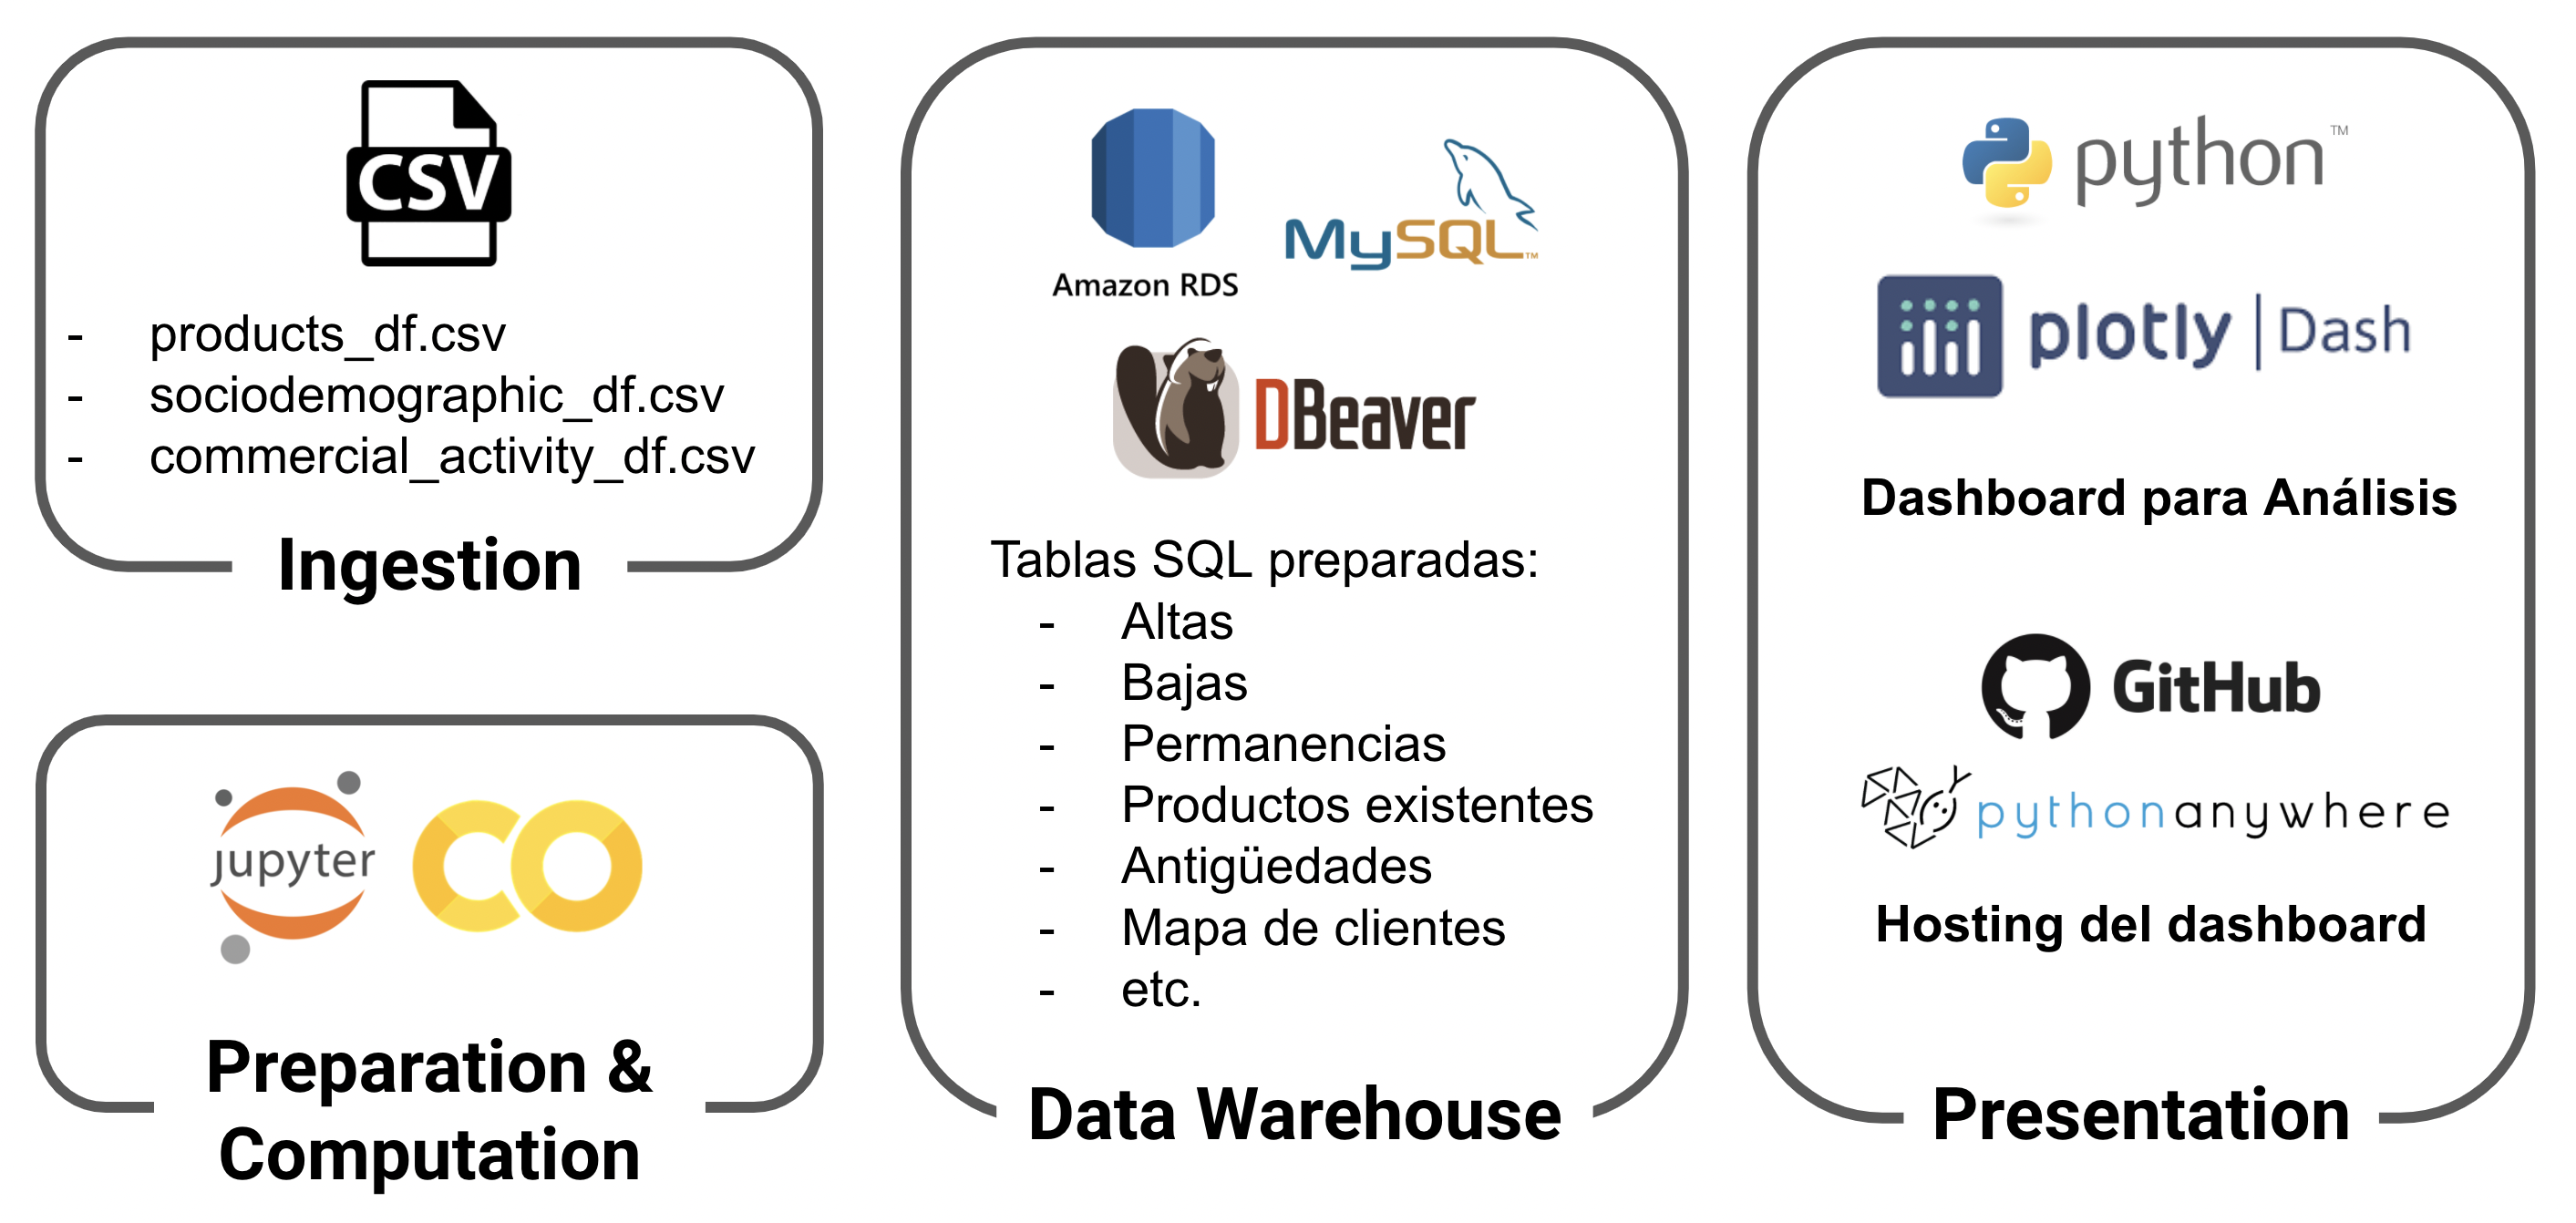

In [1]:
from IPython.display import Image
Image('../input/easymoneygrupo5/dashboard_structure.png', height = 300) 

**Importación del dataset y los paquetes**

Primero se importan los paquetes necesarios y se instalan algunas dependencias.

In [2]:
!pip install xlrd

     |████████████████████████████████| 96 kB 2.5 MB/s 


In [3]:
# DataFrame y matrices
import numpy as np 
import pandas as pd

import os

# Visualizacion
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
import plotly.express as px
import plotly.graph_objects as go

# Mapa
import folium

# Tree map
import squarify 

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
PATH_DATA = "../input/easymoneygrupo5/"
#PATH_DATA = '/content/drive/MyDrive/Nuclio Data Science - Proyecto Final/data/'
#PATH_DATA = '/Users/carlosperezricardo/Documents/data/'

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## Obtención de las altas y bajas <a class="anchor" id="2"></a> 

[Tabla de Contenidos](#0)

El principal reto en esta tarea es determinar el número de bajas y altas de productos en cada partición. Para determinar las altas que se han cobrado se debe cumplir que el cliente almenos haya pasado 3 meses de permanencia con el producto, por lo que hay que tener en cuenta la evolución del status de un producto para saber si finalmente se recibieron ingresos.

Una vez conocidas las altas se podrán determinar los ingresos. Para ello, primero se importa el dataset de *products_df.csv*. 

In [6]:
products = pd.read_csv(PATH_DATA+'products_df.csv')
products.drop('Unnamed: 0', axis=1, inplace=True)
products.head(3).T

0           1           2
pk_cid                 1375586     1050611     1050612
pk_partition        2018-01-28  2018-01-28  2018-01-28
short_term_deposit           0           0           0
loans                        0           0           0
mortgage                     0           0           0
funds                        0           0           0
securities                   0           0           0
long_term_deposit            0           0           0
em_account_pp                0           0           0
credit_card                  0           0           0
payroll                    0.0         0.0         0.0
pension_plan               0.0         0.0         0.0
payroll_account              0           0           0
emc_account                  0           0           0
debit_card                   0           0           0
em_account_p                 0           0           0
em_acount                    1           1           1

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   short_term_deposit  int64  
 3   loans               int64  
 4   mortgage            int64  
 5   funds               int64  
 6   securities          int64  
 7   long_term_deposit   int64  
 8   em_account_pp       int64  
 9   credit_card         int64  
 10  payroll             float64
 11  pension_plan        float64
 12  payroll_account     int64  
 13  emc_account         int64  
 14  debit_card          int64  
 15  em_account_p        int64  
 16  em_acount           int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 773.4+ MB


Como se observó en el EDA [PONER LINK], el dataset de productos tiene 17 columnas, 14 de las cuales equivalen a productos indicando con 0 o 1 si el status del producto (es decir si está dado de alta o no). Existen 17 particiones o históricos, que reflejan el estado de los productos en ese mes.

Seguidamente se implementa una función llamada *altas_bajas_contrataciones* que permite obtener las altas según si son altas nuevas, si son altas pendientes de cobrar (es decir que el producto sigue contratado pero no ha cumplido la permanencia) y las altas finalmente cobradas. Como también obtener las bajas de productos con cobro y sin cobro (no se cobra productos de clientes que no han cumplido la permanencia de 3 meses).

In [8]:
# Codificar variables logicas (1/0 = bool)
boolean_cols = ["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "payroll", "pension_plan"] 
# payroll y pension_plan tienen nulos en el dataset completo

for x in boolean_cols:
    products[x] = products[x].astype(bool)
    
products_sorted = products.sort_values(by=['pk_cid', 'pk_partition'])

In [9]:
partitions = ['2018-01-28','2018-02-28','2018-03-28','2018-04-28','2018-05-28','2018-06-28','2018-07-28','2018-08-28','2018-09-28','2018-10-28','2018-11-28','2018-12-28','2019-01-28','2019-02-28','2019-03-28','2019-04-28','2019-05-28']
list_products = ["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card",  "pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount"]

In [10]:
def altas_bajas_contrataciones( products_sorted, prod ):

  prod_df = pd.DataFrame()

  prev_month2 = 'prev_month'
  prev_month1 = 'prev_month'
  col_diff = 'diff'

  prod_df = products_sorted.loc[:,['pk_cid','pk_partition',prod]] # para evitar warning
  prod_df['prev_month1'] = prod_df.groupby('pk_cid')[prod].shift(1)
  prod_df['prev_month2'] = prod_df.groupby('pk_cid')[prod].shift(2)
  prod_df['prev_month3'] = prod_df.groupby('pk_cid')[prod].shift(3)
  #prod_df['diff'] = prod_df.loc[:,prod] - prod_df.loc[:,'prev_month1']

  prod_df.fillna(-2, inplace=True)

  ## ALTAS
  # nuevas contrataciones (nuevas de este mes aún por cobrar - llevan 1 mes)
  cond1 = (prod_df[prod]==1) & ((prod_df['prev_month1'] == 0) | ((prod_df['prev_month1'] == -2) & (prod_df['pk_partition']!='2018-01-28')))
  nuevas_contrataciones = prod_df[ cond1 ] 
  #nuevas_contrataciones = prod_df[ prod_df[ 'diff' ] == 1 ] 
  nuevas_contrataciones = nuevas_contrataciones.groupby(['pk_partition'])['pk_cid'].count().sort_index()

  # nuevas contrataciones (del mes anterior aún por cobrar - llevan 2 meses y no se han dado de baja)
  cond2 = (prod_df[prod]==1) & (prod_df['prev_month1']==1) & ((prod_df['prev_month2']==0) | ((prod_df['prev_month2'] == -2) & (prod_df['pk_partition']!='2018-02-28')))
  contrataciones_pendientes = prod_df[ cond2 ] 
  contrataciones_pendientes = contrataciones_pendientes.groupby(['pk_partition'])['pk_cid'].count().sort_index()

  # nuevas contrataciones (ya cobrados - llevan 3 meses y no se han dado de baja)
  cond3 = (prod_df[prod]==1) & (prod_df['prev_month1']==1) & (prod_df['prev_month2']==1) & ((prod_df['prev_month3']==0) | ((prod_df['prev_month3'] == -2) & (prod_df['pk_partition']!='2018-03-28')))
  contrataciones_cobradas = prod_df[ cond3 ] 
  contrataciones_cobradas = contrataciones_cobradas.groupby(['pk_partition'])['pk_cid'].count().sort_index()

  ## BAJAS
  # bajas de contrataciones no cobradas
  cond41 = (prod_df[prod]==0) & (prod_df['prev_month1']==1) & (prod_df['prev_month2']==0) & (prod_df['prev_month3']==-2) & (prod_df['pk_partition']!='2018-03-28')
  cond42 = (prod_df[prod]==0) & (prod_df['prev_month1']==1) & (prod_df['prev_month2']==-2) & (prod_df['pk_partition']!='2018-02-28')
  cond43 = (prod_df[prod]==0) & (prod_df['prev_month1']==1) & (prod_df['prev_month2']==0) 
  cond44 = (prod_df[prod]==0) & (prod_df['prev_month1']==1) & (prod_df['prev_month2']==1) & (prod_df['prev_month3']==0) 
  bajas_no_cobradas = prod_df[ cond41 | cond42 | cond43 | cond44 ] 
  bajas_no_cobradas = bajas_no_cobradas.groupby(['pk_partition'])['pk_cid'].count().sort_index()

  # bajas de contrataciones ya cobradas
  cond5 = (prod_df[prod]==0) & (prod_df['prev_month1']==1) & (prod_df['prev_month2']==1) & (prod_df['prev_month3']==1)
  bajas_cobradas = prod_df[ cond5 ] 
  bajas_cobradas = bajas_cobradas.groupby(['pk_partition'])['pk_cid'].count().sort_index()

  return nuevas_contrataciones, contrataciones_pendientes, contrataciones_cobradas, bajas_no_cobradas, bajas_cobradas

In [11]:
# esto tarda unos minutos
contrataciones_nuevas = pd.DataFrame( range(len(partitions)), index=partitions )
contrataciones_pendientes = pd.DataFrame( range(len(partitions)), index=partitions )
contrataciones_cobradas = pd.DataFrame( range(len(partitions)), index=partitions )

bajas_sin_cobro = pd.DataFrame( range(len(partitions)), index=partitions )
bajas_con_cobro = pd.DataFrame( range(len(partitions)), index=partitions )

for prod in list_products:
    altas_nuevas, altas_pendientes, altas_cobradas, bajas_no_cobradas, bajas_cobradas = altas_bajas_contrataciones( products_sorted, prod )
    
    # Altas
    contrataciones_nuevas[prod] = altas_nuevas
    contrataciones_pendientes[prod] = altas_pendientes
    contrataciones_cobradas[prod] = altas_cobradas

    # Bajas
    bajas_sin_cobro[prod] = bajas_no_cobradas
    bajas_con_cobro[prod] = bajas_cobradas
    
    print(prod)

short_term_deposit
loans
mortgage
funds
securities
long_term_deposit
em_account_pp
credit_card
pension_plan
payroll_account
emc_account
debit_card
em_account_p
em_acount


En el siguiente dataset *contrataciones_nuevas* se pueden observar el número de contrataciones nuevas. Una contratación nueva es aquella en la que el cliente el mes anterior no tenía solicitado este producto y decide contratarlo. En las filas tenemos las particiones y en las columnas los productos. 

In [12]:
contrataciones_nuevas.drop(0, axis=1, inplace=True)
contrataciones_nuevas.fillna(0, inplace=True)

contrataciones_pendientes.drop(0, axis=1, inplace=True)
contrataciones_pendientes.fillna(0, inplace=True)

contrataciones_cobradas.drop(0, axis=1, inplace=True)
contrataciones_cobradas.fillna(0, inplace=True)

bajas_sin_cobro.drop(0, axis=1, inplace=True)
bajas_sin_cobro.fillna(0, inplace=True)

bajas_con_cobro.drop(0, axis=1, inplace=True)
bajas_con_cobro.fillna(0, inplace=True)

In [13]:
contrataciones_nuevas

short_term_deposit  loans  mortgage  funds  securities  \
2018-01-28                0.00   0.00      0.00   0.00        0.00   
2018-02-28              665.00   0.00      0.00  97.00       68.00   
2018-03-28              652.00   4.00      2.00 119.00       47.00   
2018-04-28              419.00   3.00      1.00 127.00       45.00   
2018-05-28              383.00   3.00      1.00  83.00       47.00   
2018-06-28              443.00   0.00      1.00  53.00       42.00   
2018-07-28              451.00   1.00      1.00  54.00       59.00   
2018-08-28              434.00   2.00      0.00  63.00      101.00   
2018-09-28              498.00   2.00      0.00  38.00       77.00   
2018-10-28              412.00   2.00      0.00  40.00      179.00   
2018-11-28               96.00   0.00      0.00  52.00       39.00   
2018-12-28                6.00   1.00      0.00  60.00       86.00   
2019-01-28                0.00   1.00      1.00  36.00      254.00   
2019-02-28                0.00   1.00      0.00  25.00      120.00   
2019-03-28                0.00   3.00      0.00  28.00       65.00   
2019-04-28                0.00   2.00      3.00  26.00       44.00   
2019-05-28                0.00   0.00      0.00  18.00       39.00   

            long_term_deposit  em_account_pp  credit_card  pension_plan  \
2018-01-28               0.00           0.00         0.00          0.00   
2018-02-28             225.00           0.00       510.00      2,018.00   
2018-03-28             261.00           0.00       735.00      1,742.00   
2018-04-28             249.00           0.00       652.00      1,863.00   
2018-05-28             355.00           0.00       621.00      1,614.00   
2018-06-28             387.00           0.00       749.00      2,694.00   
2018-07-28             450.00           0.00       760.00      2,506.00   
2018-08-28             345.00           0.00       694.00      1,665.00   
2018-09-28             497.00           0.00       749.00      2,190.00   
2018-10-28             506.00           0.00       743.00      2,410.00   
2018-11-28             366.00           0.00       713.00      2,370.00   
2018-12-28             464.00           0.00       664.00      2,683.00   
2019-01-28             194.00           0.00       653.00      1,707.00   
2019-02-28             219.00           0.00       708.00      4,691.00   
2019-03-28              76.00           0.00       741.00      2,458.00   
2019-04-28              27.00           0.00       713.00      2,323.00   
2019-05-28              12.00           0.00       761.00      2,819.00   

            payroll_account  emc_account  debit_card  em_account_p  em_acount  
2018-01-28             0.00         0.00        0.00          0.00       0.00  
2018-02-28           974.00       807.00    3,708.00          0.00   4,156.00  
2018-03-28         1,015.00       915.00    4,058.00          0.00   4,021.00  
2018-04-28         1,098.00       840.00    3,500.00          0.00   3,608.00  
2018-05-28         1,125.00       865.00    3,184.00          0.00   3,754.00  
2018-06-28         1,119.00       685.00    3,690.00          0.00   5,565.00  
2018-07-28         1,649.00       552.00    3,969.00          0.00  13,289.00  
2018-08-28         1,556.00       448.00    3,659.00          0.00  14,888.00  
2018-09-28         1,075.00       586.00    5,288.00          0.00  18,404.00  
2018-10-28         1,398.00       569.00    6,319.00          0.00  19,963.00  
2018-11-28         1,861.00       943.00    5,258.00          0.00  11,358.00  
2018-12-28         2,294.00       901.00    5,154.00          0.00   8,060.00  
2019-01-28         1,365.00     1,178.00    4,694.00          0.00   6,288.00  
2019-02-28         1,379.00     1,235.00    6,138.00          0.00   4,997.00  
2019-03-28         1,516.00     1,033.00    5,580.00          0.00   5,538.00  
2019-04-28         1,475.00     1,283.00    5,005.00          0.00   4,231.00  
2019-05-28         1,531.00     1,607.00

Finalmente estas tablas se guardan en csv y posteriormente son convertidas a tablas en SQL. Cómo se puede observar para la obtención de las altas no hará falta cargar el archivo de productos de dimensiones mucho más grandes y tan sólo bastará con cargar la tabla o csv resumen. Este paso se conoce como *Data Preparation y Computation*.

In [14]:
run = False
if run == True:
    contrataciones_nuevas.to_csv(PATH_DATA+'contrataciones_nuevas.csv')
    contrataciones_pendientes.to_csv(PATH_DATA+'contrataciones_pendientes.csv')
    contrataciones_cobradas.to_csv(PATH_DATA+'contrataciones_cobradas.csv')
    bajas_sin_cobro.to_csv(PATH_DATA+'bajas_sin_cobro.csv')
    bajas_con_cobro.to_csv(PATH_DATA+'bajas_con_cobro.csv')

In [15]:
# limpiamos memoria
del products

## Obtención de los ingresos <a class="anchor" id="3"></a>

[Tabla de Contenidos](#0)

Una vez obtenidas las altas y bajas se pueden obtener los ingresos. Como se comenta en el correo correspondiente a la Tarea 3: Recomendación, los ingresos por cada producto son diferentes. Los productos se engloban en 3 grupos principales. Los ingresos por cada tipo son los siguientes:
- cuenta vendida (10 €)
- productos de ahorro e inversión (40 €)
- productos de financiación (60 €)

Con estos valores es posible obtener los ingresos por cada grupo y los ingresos totales. 

In [16]:
contrataciones_nuevas = pd.read_csv(PATH_DATA+'contrataciones_nuevas.csv', encoding='utf-8', index_col=0)
contrataciones_pendientes = pd.read_csv(PATH_DATA+'contrataciones_pendientes.csv', encoding='utf-8', index_col=0)
contrataciones_cobradas = pd.read_csv(PATH_DATA+'contrataciones_cobradas.csv', encoding='utf-8', index_col=0)

bajas_sin_cobro = pd.read_csv(PATH_DATA+'bajas_sin_cobro.csv', encoding='utf-8', index_col=0)
bajas_con_cobro = pd.read_csv(PATH_DATA+'bajas_con_cobro.csv', encoding='utf-8', index_col=0)

productos_exist_df = pd.read_csv(PATH_DATA + 'productos_existentes.csv')

In [17]:
products_dict = {"short_term_deposit":"ahorro e inversión", "loans":"financiación", "mortgage":"financiación", 
    "funds":"ahorro e inversión", "securities":"ahorro e inversión", "long_term_deposit":"ahorro e inversión", 
    "em_account_pp":"cuenta", "credit_card":"financiación", "payroll_account":"cuenta", 
    "emc_account":"cuenta", "debit_card":"financiación", "em_account_p":"cuenta", "em_acount":"cuenta", "pension_plan":"ahorro e inversión"}

cost_product = {'cuenta':10, 'ahorro e inversión':40, 'financiación':60}

partitions = ['2018-01-28','2018-02-28','2018-03-28','2018-04-28','2018-05-28','2018-06-28', \
    '2018-07-28','2018-08-28','2018-09-28','2018-10-28','2018-11-28','2018-12-28','2019-01-28', \
        '2019-02-28','2019-03-28','2019-04-28','2019-05-28']

list_products = ["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp",\
                "credit_card", "payroll_account", "pension_plan", "emc_account", "debit_card", "em_account_p", "em_acount"]

In [18]:
def tipos_producto(df, products_dict):
    ahorros = df.copy(deep=True)
    financiacion = df.copy(deep=True)
    cuentas = df.copy(deep=True)

    for key, value in products_dict.items():
        if value == 'ahorro e inversión':
            ahorros[key] = df[key]
        else:
            ahorros.drop(columns=key, inplace=True)
        if value == "financiación":
            financiacion[key] = df[key]
        else:
            financiacion.drop(columns=key, inplace=True)
        if value == "cuenta":
            cuentas[key] = df[key]
        else:
            cuentas.drop(columns=key, inplace=True)
            
    return ahorros, financiacion, cuentas

In [19]:
# Obtencion de ingresos
ingresos_df = contrataciones_cobradas.copy(deep=True)
ingresos_perdidos_df = bajas_sin_cobro.copy(deep=True)


for key, value in products_dict.items():
  ingresos_df[key] = ingresos_df[key]*cost_product[value] 
  ingresos_perdidos_df[key] = ingresos_perdidos_df[key]*cost_product[value] 

ingresos_df.drop( partitions[:3], axis=0, inplace=True )
ingresos_perdidos_df.drop( partitions[:3], axis=0, inplace=True )

ahorros_df, financiacion_df, cuentas_df = tipos_producto(ingresos_df, products_dict)

In [20]:
ahorros_df

short_term_deposit    funds  securities  long_term_deposit  \
2018-04-28           26,080.00 3,720.00    2,080.00           8,880.00   
2018-05-28           25,680.00 4,560.00    1,560.00          10,400.00   
2018-06-28           16,320.00 4,600.00    1,560.00           9,720.00   
2018-07-28           15,160.00 3,080.00    1,400.00          13,880.00   
2018-08-28           17,560.00 2,000.00    1,240.00          15,400.00   
2018-09-28           17,720.00 2,080.00    2,120.00          17,800.00   
2018-10-28           17,080.00 2,280.00    3,760.00          13,640.00   
2018-11-28           19,680.00 1,400.00    2,360.00          19,680.00   
2018-12-28           16,360.00 1,480.00    6,800.00          20,040.00   
2019-01-28            3,800.00 1,960.00    1,400.00          14,480.00   
2019-02-28              240.00 2,120.00    2,920.00          18,360.00   
2019-03-28                0.00 1,400.00    9,440.00           7,600.00   
2019-04-28                0.00   840.00    3,840.00           8,680.00   
2019-05-28                0.00   840.00    2,200.00           3,000.00   

            pension_plan  
2018-04-28     52,120.00  
2018-05-28     39,720.00  
2018-06-28     32,760.00  
2018-07-28     40,520.00  
2018-08-28     73,760.00  
2018-09-28     47,400.00  
2018-10-28     35,480.00  
2018-11-28     51,120.00  
2018-12-28     64,040.00  
2019-01-28     49,560.00  
2019-02-28     44,680.00  
2019-03-28     35,240.00  
2019-04-28    128,440.00  
2019-05-28     62,920.00

Los ingresos se pueden agrupar según el tipo de producto: ahorros e inversión, financiación y cuentas. Los ingresos de cad tipo pueden representarse en una barra horizontal stacked como se muestra a continuación. 

De la última partición de otros datasets ya preprocesados o tablas intermedias se pueden obtener el número de clientes de nueva entrada, el número de usuarios activos y los productos vendidos este último mes.

Con estos datos se ofrece una visión del balance de este mes. 

In [21]:
print('Ingresos totales: {} €'.format(ingresos_df.sum(axis=1)[ partitions[-1] ]))
print(' Ahorro e inversión: {} €'.format(ahorros_df.sum(axis=1)[ partitions[-1] ]))
print(' Financiación: {} €'.format(financiacion_df.sum(axis=1)[ partitions[-1] ]))
print(' Cuentas: {} €'.format(cuentas_df.sum(axis=1)[ partitions[-1] ]))

Ingresos totales: 337520.0 €
 Ahorro e inversión: 68960.0 €
 Financiación: 202200.0 €
 Cuentas: 66360.0 €


In [22]:
def fig_resumen_mes(financiacion_df, ahorros_df, cuentas_df):
  resumen_mes = pd.DataFrame( [financiacion_df.sum(axis=1)['2019-05-28'], ahorros_df.sum(axis=1)['2019-05-28'], cuentas_df.sum(axis=1)['2019-05-28']], index=['Financiacion', 'Ahorros', 'Cuentas'], columns=['ingresos'])
  resumen_mes = resumen_mes.reset_index()
  resumen_mes.columns = ['tipo','ingresos']
 
  fig = px.bar(resumen_mes, x="ingresos", y=[1,1,1], color='tipo', orientation='h')

  fig.update_layout(legend=dict(
      orientation="h",
      yanchor="bottom",
      y=1.02,
      xanchor="center",
      x=0.5,
      font=dict(
              family="Courier",
              size=18,
              color="black"
      )
  ))

  fig.update_yaxes(visible=False, showticklabels=False)
  
  return fig

fig = fig_resumen_mes(financiacion_df, ahorros_df, cuentas_df)
fig.show()

In [23]:
last_month_sells = contrataciones_cobradas.loc['2019-05-28']
sold_products = last_month_sells [ last_month_sells != 0 ].sort_values()

fig = go.Figure()
for key, value in zip(sold_products.index, sold_products):
    fig.add_trace(go.Bar(x=[key], y=[value], name=key, text=[value],
            textposition='auto'))

fig.update_yaxes(visible=False, showticklabels=False)
fig.update_layout(title={'text':'Productos vendidos en el último mes', 'x':0.1,'y':0.75})

In [24]:
del last_month_sells, sold_products

## Evolución de históricos <a class="anchor" id="4"></a>

[Tabla de Contenidos](#0)

En esta sección se pretende obtener la evolución en el tiempo de tanto las altas, bajas, productos contratados e ingresos. 

Una gráfica interesante es ver cuáles hubieran sido los ingresos por cada mes si la conversión hubiera sido del 100%, es decir que todos los clientes que solicitaron el producto hubieran pasado los 3 meses de permanencia y por lo tanto se les hubiera cobrado por el producto.

In [25]:
def alta_baja_total (data, name):
  totales = pd.DataFrame(data.sum(axis='columns')).reset_index()  
  totales.columns = ['pk_partition',name]

  return totales

In [26]:
# Resumen total altas e ingresos altas
altas_nuevas = alta_baja_total (contrataciones_nuevas, 'altas')
ingresos_ganados = alta_baja_total (ingresos_df, 'altas')
altas_pendientes = alta_baja_total (contrataciones_pendientes, 'altas')

altas_por_cobrar = altas_nuevas.set_index('pk_partition') + altas_pendientes.set_index('pk_partition')
altas_por_cobrar = altas_por_cobrar.reset_index()

altas_cobradas = alta_baja_total (contrataciones_cobradas, 'altas').set_index('pk_partition')

altas_totales = altas_por_cobrar.set_index('pk_partition')  + altas_cobradas
altas_totales.reset_index(inplace=True)
altas_cobradas.reset_index(inplace=True)

# Resumen total bajas e ingresos bajas

bajas_no_cobro = alta_baja_total (bajas_sin_cobro, 'bajas')
ingresos_perdidos = alta_baja_total (ingresos_perdidos_df, 'altas')
bajas_si_cobro = alta_baja_total (bajas_con_cobro, 'bajas')

bajas_totales = bajas_no_cobro.set_index('pk_partition') + bajas_si_cobro.set_index('pk_partition') 
bajas_totales.reset_index(inplace=True)

# Ingresos potenciales

ingresos_potenciales = ingresos_perdidos.set_index('pk_partition') + ingresos_ganados.set_index('pk_partition')
ingresos_potenciales = ingresos_potenciales.reset_index()

In [27]:
altas_totales.T

0           1           2           3           4   \
pk_partition  2018-01-28  2018-02-28  2018-03-28  2018-04-28  2018-05-28   
altas                0.0    13,228.0    24,009.0    32,383.0    30,529.0   

                      5           6           7           8           9   \
pk_partition  2018-06-28  2018-07-28  2018-08-28  2018-09-28  2018-10-28   
altas           32,778.0    44,286.0    54,274.0    68,445.0    77,299.0   

                      10          11          12          13          14  \
pk_partition  2018-11-28  2018-12-28  2019-01-28  2019-02-28  2019-03-28   
altas           74,641.0    66,295.0    49,338.0    45,715.0    43,597.0   

                      15          16  
pk_partition  2019-04-28  2019-05-28  
altas           41,756.0    38,935.0

In [28]:
ingresos_potenciales.T

0           1           2           3           4   \
pk_partition  2018-04-28  2018-05-28  2018-06-28  2018-07-28  2018-08-28   
altas          437,260.0   478,000.0   375,480.0   408,600.0   533,190.0   

                      5           6           7           8           9   \
pk_partition  2018-09-28  2018-10-28  2018-11-28  2018-12-28  2019-01-28   
altas          528,950.0   575,450.0   714,070.0   723,580.0   675,780.0   

                      10          11          12          13  
pk_partition  2019-02-28  2019-03-28  2019-04-28  2019-05-28  
altas          561,920.0   490,090.0   674,700.0   574,620.0

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ingresos_potenciales["pk_partition"], y=ingresos_potenciales["altas"], 
    name='Ganancias con conversión 100%',  fill='tozeroy', line_color='indianred'))
fig.add_trace(go.Scatter(x=ingresos_ganados["pk_partition"], y=ingresos_ganados["altas"], 
    name='Ganacias Reales', fill='tozeroy', line_color='blue'))

maximums = np.array([ingresos_potenciales['altas'].max(), ingresos_ganados['altas'].max()])
fig.update_yaxes(range=[-500, maximums.max()*1.05])
fig.update_layout(yaxis_title='Ingresos [€]')
#fig.update_layout(title='Cashflow')
fig.show()

En la siguiente gráfica pueden diferenciarse las altas en:
- Altas nuevas
- Altas pendientes de cobro
- Altas recién cobradas

Puede observarse que los cálculos de altas según su estado están bien calculados, dado que no se pueden cobrar más productos de los que se dieron de alta hace 3 meses, como tampoco se pueden tener más productos pendientes de cobro que altas en el mes anterior. 

Similarmente también se dividen las bajas en cada mes en bajas de productos en las que se llegó a cobrar y de las que no. 

In [30]:
fig = go.Figure()

inicio = 3
#fig.add_trace(go.Scatter(x=altas_totales["pk_partition"][inicio:], y=altas_totales["altas"][inicio:], name='Altas totales'))
altas_nuevas= altas_nuevas[inicio:]
altas_pendientes = altas_pendientes[inicio:]
altas_cobradas = altas_cobradas[inicio:]

fig.add_trace(go.Scatter(x=altas_nuevas["pk_partition"], y=altas_nuevas["altas"], name='Nuevas altas'))
fig.add_trace(go.Scatter(x=altas_pendientes["pk_partition"], y=altas_pendientes["altas"], name='Altas pendientes de cobro'))
fig.add_trace(go.Scatter(x=altas_cobradas["pk_partition"], y=altas_cobradas["altas"], name='Altas recién cobradas'))

maximums = np.array([altas_nuevas['altas'].max(), altas_pendientes['altas'].max(), altas_cobradas['altas'].max()])
fig.update_yaxes(range=[0, maximums.max()*1.05])
fig.update_layout(yaxis_title='Cantidad de productos')

In [31]:
fig = go.Figure()

inicio = 3
fig.add_trace(go.Scatter(x=bajas_totales["pk_partition"][inicio:], y=bajas_totales["bajas"][inicio:], name='Bajas totales'))

fig.add_trace(go.Scatter(x=bajas_no_cobro["pk_partition"][inicio:], y=bajas_no_cobro["bajas"][inicio:], name='Bajas sin cobro'))
fig.add_trace(go.Scatter(x=bajas_si_cobro["pk_partition"][inicio:], y=bajas_si_cobro["bajas"][inicio:], name='Bajas con cobro'))

#maximums = np.array([bajas_no_cobro['bajas'].max(), bajas_si_cobro['bajas'].max()])
#fig.update_yaxes(range=[0, maximums.max()*1.05])
fig.update_layout(yaxis_title='Cantidad de productos')
fig.update_layout(title='Bajas de Productos')
fig.show()

## Conversión <a class="anchor" id="5"></a>

[Tabla de Contenidos](#0)

Conocidas las altas nuevas en cada mes y las altas finalmente cobradas cada mes, se puede obtener la conversión entre el número de productos dados de alta hace 3 meses y el número de productos que se han finalmente cobrado este mes. 

$$conversion [\%] = \frac{ contrataciones_{nuevas - 3 \; meses \; antes} }{ contrataciones_{cobradas} } \cdot 100$$

In [32]:
conversiones = pd.DataFrame()
for ix in range(len(partitions)): 
  if ix >= 3:
    total = contrataciones_nuevas.loc[partitions[ix-2]]
    cobra = contrataciones_cobradas.loc[partitions[ix]]
    conversiones[partitions[ix]] = cobra/total*100

conversiones = conversiones.fillna(0).T

In [33]:
conversiones

short_term_deposit  loans  mortgage  funds  securities  \
2018-04-28               98.05   0.00      0.00  95.88       76.47   
2018-05-28               98.47 100.00    100.00  95.80       82.98   
2018-06-28               97.37 100.00    100.00  90.55       86.67   
2018-07-28               98.96 100.00    100.00  92.77       74.47   
2018-08-28               99.10   0.00    100.00  94.34       73.81   
2018-09-28               98.23 100.00    100.00  96.30       89.83   
2018-10-28               98.39 100.00      0.00  90.48       93.07   
2018-11-28               98.80 100.00      0.00  92.11       76.62   
2018-12-28               99.27 100.00      0.00  92.50       94.97   
2019-01-28               98.96   0.00      0.00  94.23       89.74   
2019-02-28              100.00 100.00      0.00  88.33       84.88   
2019-03-28                0.00 100.00    100.00  97.22       92.91   
2019-04-28                0.00 100.00      0.00  84.00       80.00   
2019-05-28                0.00 100.00      0.00  75.00       84.62   

            long_term_deposit  em_account_pp  credit_card  pension_plan  \
2018-04-28              98.67           0.00        50.39         64.57   
2018-05-28              99.62           0.00        50.61         57.00   
2018-06-28              97.59           0.00        53.68         43.96   
2018-07-28              97.75           0.00        45.41         62.76   
2018-08-28              99.48           0.00        47.00         68.45   
2018-09-28              98.89           0.00        46.32         47.29   
2018-10-28              98.84           0.00        43.37         53.27   
2018-11-28              98.99           0.00        44.46         58.36   
2018-12-28              99.01           0.00        46.70         66.43   
2019-01-28              98.91           0.00        46.28         52.28   
2019-02-28              98.92           0.00        45.63         41.63   
2019-03-28              97.94           0.00        42.73         51.61   
2019-04-28              99.09           0.00        47.03         68.45   
2019-05-28              98.68           0.00        48.04         64.00   

            payroll_account  emc_account  debit_card  em_account_p  em_acount  
2018-04-28            88.71        85.87       49.87          0.00      78.71  
2018-05-28            89.85        91.26       51.01          0.00      79.58  
2018-06-28            86.52        86.79       43.54          0.00      78.55  
2018-07-28            86.13        87.63       46.20          0.00      77.09  
2018-08-28            90.97        89.64       44.85          0.00      78.60  
2018-09-28            91.87        87.50       40.01          0.00      91.83  
2018-10-28            93.57        88.84       47.12          0.00      92.44  
2018-11-28            89.21        87.37       48.15          0.00      92.26  
2018-12-28            88.63        88.58       50.91          0.00      92.16  
2019-01-28            92.91        86.74       51.12          0.00      88.51  
2019-02-28            90.93        87.79       44.82          0.00      83.50  
2019-03-28            89.89        88.62       44.29          0.00      79.85  
2019-04-28            91.08        91.01       50.52          0.00      80.57  
2019-05-28            90.24        91.97       53.96          0.00      77.97

In [34]:
conversion_df = pd.DataFrame(conversiones.min(axis=0), columns=['min'])
conversion_df['mean'] = conversiones.mean(axis=0)
conversion_df['max'] = conversiones.max(axis=0)
conversion_df.reset_index(inplace=True)

conversion_df['tipo'] = conversion_df['index'].replace(products_dict)

fig = px.bar(conversion_df, x='index', y='mean', color='tipo')
fig.update_layout(xaxis_title='')
fig.update_layout(yaxis_title='Conversión [%]')
fig.update_layout(title='Conversión media de cada producto')
fig.show()

In [35]:
conversion_df.set_index('index', inplace=True)

Dado la metodología de cobro de la compañía, se puede obtener una predicción de los ingresos que se recibirán los 2 próximos meses, dado que las altas de este mes serán las altas cobradas de aquí 2 meses, teniendo en cuenta la conversión.

Por ello se plantean tres casos de forecasting de ingresos:
- Worst Case. Nos quedamos con la conversión mínima de cada producto.
- Expected Case. Nos quedamos con la conversión media de cada producto.
- Best Case. Nos quedamos con la conversión máxima de cada producto.

Por lo que se augura que los ingresos los próximos 2 meses estén entre en un rango de valores. Finalmente las conversiones medias de todos los productos considerando el Worst, Expected y Best Case son los siguientes: 44.24%, 63,38%, 74,7%.

Este enfoque es más realista que establecer una conversión de 90% u otro valor, dado que esperar tener una conversión mejor que la máxima histórica es demasiado ambicioso, sin embargo poder reproducir los mismos resultados ya previamente obtenidos es más factible. 

In [36]:
# Forecast
def ingresos_forecast(contrataciones_nuevas, conversion):
    forecast = pd.DataFrame()
    new_partitions = {'2019-06-28':'2019-04-28','2019-07-28':'2019-05-28'}
    for key, val in new_partitions.items():
        new_row = pd.DataFrame(contrataciones_nuevas.loc[val]).T.reset_index()
        new_row['index'] = key
        new_row.rename(columns={'index': 'pk_partition'}, inplace=True)
        forecast = pd.concat( [forecast, new_row*conversion/100] )
    
    forecast['pk_partition'] = new_partitions.keys()
    forecast.set_index('pk_partition', inplace=True)
    
    return forecast

ingresos_futuros = contrataciones_nuevas.copy(deep=True)

for key, value in products_dict.items():
  ingresos_futuros[key] = ingresos_futuros[key]*cost_product[value] 


worst_case = ingresos_forecast(ingresos_futuros, conversion_df['min'])
common_case = ingresos_forecast(ingresos_futuros, conversion_df['mean'])
best_case = ingresos_forecast(ingresos_futuros, conversion_df['max'])

In [37]:
worst_case

credit_card  debit_card  em_account_p  em_account_pp  em_acount  \
pk_partition                                                                    
2019-06-28      18,278.13  120,150.26          0.00           0.00  32,617.25   
2019-07-28      19,508.64  123,391.08          0.00           0.00  31,106.26   

              emc_account  funds  loans  long_term_deposit  mortgage  \
pk_partition                                                           
2019-06-28      11,017.58 780.00   0.00           1,053.98      0.00   
2019-07-28      13,799.89 540.00   0.00             468.43      0.00   

              payroll_account  pension_plan  securities  short_term_deposit  
pk_partition                                                                 
2019-06-28          12,704.67     38,684.92    1,299.05                0.00  
2019-07-28          13,187.01     46,944.81    1,151.43                0.00

In [38]:
def calculate_case( case, last_ingresos ):
    ingresos = alta_baja_total (case, 'altas')
    ingresos = ingresos.append( last_ingresos.iloc[-1] )

    return ingresos.sort_values('pk_partition')

worst_ingresos = calculate_case( worst_case, ingresos_ganados )
expected_ingresos = calculate_case( common_case, ingresos_ganados )
best_ingresos = calculate_case( best_case, ingresos_ganados )

In [39]:
worst_mean = int( conversion_df['min'].mean()*100 )/100
expected_mean = int( conversion_df['mean'].mean()*100 )/100
best_mean = int( conversion_df['max'].mean()*100 )/100

worst_ingresos

pk_partition      altas
13   2019-05-28 337,520.00
0    2019-06-28 236,585.84
1    2019-07-28 250,097.55

In [40]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ingresos_ganados["pk_partition"], y=ingresos_ganados["altas"], name='Ingresos hasta la fecha'))

fig.add_trace(go.Scatter(x=worst_ingresos["pk_partition"], y=worst_ingresos["altas"], name=str('Worst Case: {}%'.format( worst_mean ))))
fig.add_trace(go.Scatter(x=worst_ingresos["pk_partition"], y=expected_ingresos["altas"], name= str('Expected Case: {}%'.format( expected_mean ))))
fig.add_trace(go.Scatter(x=worst_ingresos["pk_partition"], y=best_ingresos["altas"], name= ('Best Case: {}%'.format( best_mean ))))

maximums = np.array([ingresos_ganados['altas'].max(), best_ingresos['altas'].max()])
fig.update_yaxes(range=[0, maximums.max()*1.05])
fig.update_layout(yaxis_title='Ingresos[€]')
fig.update_layout(title='Ingresos Forecasting')
fig.show()

Seguidamente, se obtiene la evolución temporal de productos y se obtiene el número de productos actual. Y después se dividen las altas y bajas dependiendo de su tipo de producto.

In [41]:
prod_ahorros, prod_financiacion, prod_cuentas = tipos_producto(productos_exist_df, products_dict)

altas_ahorros, altas_financiacion, altas_cuentas = tipos_producto(contrataciones_cobradas, products_dict)
bajas_ahorros, bajas_financiacion, bajas_cuentas = tipos_producto(bajas_sin_cobro + bajas_con_cobro, products_dict)

prod_ahorros

pk_partition  short_term_deposit  funds  securities  long_term_deposit  \
0    2018-01-28                 883    786         932               4884   
1    2018-02-28                1343    872         965               4956   
2    2018-03-28                1664    969         965               4965   
3    2018-04-28                1740   1084         983               5107   
4    2018-05-28                1455   1145        1012               5356   
5    2018-06-28                1244   1159        1019               5588   
6    2018-07-28                1282   1172        1053               5796   
7    2018-08-28                1335   1219        1133               5923   
8    2018-09-28                1386   1237        1201               6158   
9    2018-10-28                1374   1249        1348               6380   
10   2018-11-28                1018   1282        1360               6447   
11   2018-12-28                 528   1322        1420               6749   
12   2019-01-28                 125   1330        1655               6659   
13   2019-02-28                  11   1316        1747               6658   
14   2019-03-28                   2   1322        1769               6537   
15   2019-04-28                   2   1320        1782               6368   
16   2019-05-28                   2   1315        1789               6129   

    pension_plan  
0           8852  
1           9510  
2           9892  
3          10570  
4          10158  
5          11635  
6          12779  
7          12126  
8          12624  
9          13223  
10         13818  
11         15324  
12         12538  
13         15265  
14         15976  
15         16220  
16         17353

In [42]:
# Totales
def obtener_prod_totales(df):
  totales = df.sum(axis='columns').reset_index()
  totales.columns = ['pk_partition','productos']
  return totales

productos_totales = obtener_prod_totales(productos_exist_df)

ahorros_totales = obtener_prod_totales(prod_ahorros)
financiacion_totales = obtener_prod_totales(prod_financiacion)
cuentas_totales = obtener_prod_totales(prod_cuentas)

fig = go.Figure()
fig.add_trace(go.Scatter(x=productos_totales["pk_partition"], y=productos_totales["productos"], name='Totales'))

fig.add_trace(go.Scatter(x=productos_totales["pk_partition"], y=ahorros_totales["productos"], name='Ahorros'))
fig.add_trace(go.Scatter(x=productos_totales["pk_partition"], y=financiacion_totales["productos"], name='Financiación'))
fig.add_trace(go.Scatter(x=productos_totales["pk_partition"], y=cuentas_totales["productos"], name='Cuentas'))
fig.update_yaxes(range=[0, productos_totales.max()['productos']*1.05])
fig.update_layout(title='Evolución de productos',
                   yaxis_title='Cantidad de productos')
fig.show()

In [43]:
del productos_totales, ahorros_totales, financiacion_totales, cuentas_totales

La última gráfica no aporta mucho valor dado que se espera que la cantidad de productos contratados como también la cantidad de usuarios aumente con el tiempo, pero no define qué bien o mal se está haciendo y cómo se progresa. Por lo que esta gráfica no se presentará en el dashboard.

Similarmente también se puede el número de productos en la última partición. Seguidamente también se presentan las altas desglosadas en cada tipo de producto, así como las totales. 

In [44]:
def tipo_producto_totales (df, ahorros, financiacion, cuentas):

    totales = alta_baja_total (df, 'value')

    ahorros_totales = alta_baja_total(ahorros, 'value')
    financiacion_totales = alta_baja_total(financiacion, 'value')
    cuentas_totales = alta_baja_total(cuentas, 'value')
 
    fig = go.Figure()
    inicio = 1
    fig.add_trace(go.Scatter(x=totales["pk_partition"][inicio:], y=totales["value"][inicio:], name='Totales'))

    fig.add_trace(go.Scatter(x=totales["pk_partition"][inicio:], y=ahorros_totales["value"][inicio:], name='Ahorros'))
    fig.add_trace(go.Scatter(x=totales["pk_partition"][inicio:], y=financiacion_totales["value"][inicio:], name='Financiación'))
    fig.add_trace(go.Scatter(x=totales["pk_partition"][inicio:], y=cuentas_totales["value"][inicio:], name='Cuentas'))

    fig.update_yaxes(range=[0, totales.max()['value']*1.05])

    return fig


fig = tipo_producto_totales (contrataciones_nuevas, altas_ahorros, altas_financiacion, altas_cuentas)

fig.update_layout(title='Evolución de altas',
                   yaxis_title='Número de altas')
fig.show()

Finalmente se obtiene la evolución de los ingresos mensuales considerando todos los productos y agrupados en los 3 tipos de productos.

In [45]:
def obtener_ingresos_totales(df):
    totales = pd.DataFrame(df.sum(axis='columns')).reset_index()
    totales.columns = ['pk_partition','ingresos']
    return totales

totales_ingresos = obtener_ingresos_totales(ingresos_df)

totales_ahorros = obtener_ingresos_totales(ahorros_df)
totales_financiacion = obtener_ingresos_totales(financiacion_df)
totales_cuentas = obtener_ingresos_totales(cuentas_df)

fig = go.Figure()
fig.add_trace(go.Scatter(x=totales_ingresos['pk_partition'], y=totales_ingresos['ingresos'], name='Total'))

fig.add_trace(go.Scatter(x=totales_ingresos['pk_partition'], y=totales_ahorros['ingresos'], name='Ahorros'))
fig.add_trace(go.Scatter(x=totales_ingresos['pk_partition'], y=totales_financiacion['ingresos'], name='Financiacion'))
fig.add_trace(go.Scatter(x=totales_ingresos['pk_partition'], y=totales_cuentas['ingresos'], name='Cuentas'))

fig.update_yaxes(range=[0, totales_ingresos.max()['ingresos']*1.05])
fig.update_layout(title= 'Evolución de los Ingresos',
                   yaxis_title='Ingresos mensuales')
fig.show()

In [46]:
# limpiamos memoria
try:
    del conversiones, totales_ahorros, totales_financiacion, totales_cuentas
except:
    pass

## Análisis Ventas <a class="anchor" id="6"></a>

[Tabla de Contenidos](#0)

En esta parte hacemos un análisis de la evolución de la cartera de productos que tenemos en el mercado, crecimiento mensual en términos absolutos y relativos y composición. 

### Organizamos el dataset

In [47]:
productos = pd.read_csv(PATH_DATA+'products_df.csv')
productos.drop('Unnamed: 0', axis=1, inplace=True)

# para aligerar el fichero cambio el tipo de datos a int8 para las columnas de productos
for i in productos.columns:
        if (productos[i].dtype=="int64" and [i]!=["pk_cid"]):
            productos[i]=productos[i].astype("int8")
        else:            
            productos[i]=productos[i]

In [48]:
productos_his = pd.DataFrame(productos.groupby(['pk_partition'])[productos.columns[2:]].sum())
productos_his = productos_his.reset_index()

In [49]:
# Borramos payroll porque es un servicio no producto
productos_his. drop('payroll', axis=1, inplace=True)
productos_his

pk_partition  short_term_deposit  loans  mortgage    funds  securities  \
0    2018-01-28              883.00  19.00     15.00   786.00      932.00   
1    2018-02-28            1,343.00  19.00     15.00   872.00      965.00   
2    2018-03-28            1,664.00  23.00     17.00   969.00      965.00   
3    2018-04-28            1,740.00  24.00     17.00 1,084.00      983.00   
4    2018-05-28            1,455.00  27.00     18.00 1,145.00    1,012.00   
5    2018-06-28            1,244.00  27.00     19.00 1,159.00    1,019.00   
6    2018-07-28            1,282.00  28.00     20.00 1,172.00    1,053.00   
7    2018-08-28            1,335.00  29.00     20.00 1,219.00    1,133.00   
8    2018-09-28            1,386.00  31.00     20.00 1,237.00    1,201.00   
9    2018-10-28            1,374.00  33.00     19.00 1,249.00    1,348.00   
10   2018-11-28            1,018.00  32.00     19.00 1,282.00    1,360.00   
11   2018-12-28              528.00  30.00     19.00 1,322.00    1,420.00   
12   2019-01-28              125.00  28.00     20.00 1,330.00    1,655.00   
13   2019-02-28               11.00  29.00     20.00 1,316.00    1,747.00   
14   2019-03-28                2.00  29.00     20.00 1,322.00    1,769.00   
15   2019-04-28                2.00  30.00     23.00 1,320.00    1,782.00   
16   2019-05-28                2.00  30.00     23.00 1,315.00    1,789.00   

    long_term_deposit  em_account_pp  credit_card  pension_plan  \
0            4,884.00           0.00     3,325.00      8,835.00   
1            4,956.00           0.00     3,282.00      9,496.00   
2            4,965.00           0.00     3,511.00      9,882.00   
3            5,107.00           0.00     3,725.00     10,560.00   
4            5,356.00           0.00     3,797.00     10,148.00   
5            5,588.00           0.00     4,002.00     11,635.00   
6            5,796.00           0.00     4,137.00     12,779.00   
7            5,923.00           0.00     4,206.00     12,126.00   
8            6,158.00           0.00     4,289.00     12,624.00   
9            6,380.00           0.00     4,385.00     13,223.00   
10           6,447.00           0.00     4,512.00     13,818.00   
11           6,749.00           0.00     4,536.00     15,324.00   
12           6,659.00           0.00     4,493.00     12,538.00   
13           6,658.00           0.00     4,542.00     15,265.00   
14           6,537.00           0.00     4,576.00     15,976.00   
15           6,368.00           0.00     4,747.00     16,220.00   
16           6,129.00           0.00     4,801.00     17,353.00   

    payroll_account  emc_account  debit_card  em_account_p  em_acount  
0         13,478.00    15,320.00   24,696.00          2.00 215,293.00  
1         14,246.00    15,827.00   25,448.00          2.00 217,098.00  
2         14,989.00    16,428.00   27,046.00          2.00 218,683.00  
3         15,825.00    16,947.00   27,764.00          2.00 219,816.00  
4         16,697.00    17,569.00   27,911.00          2.00 221,291.00  
5         15,540.00    17,950.00   28,828.00          2.00 224,328.00  
6         16,916.00    18,185.00   29,578.00          2.00 234,324.00  
7         18,118.00    18,333.00   29,205.00          2.00 245,980.00  
8         18,862.00    18,618.00   31,684.00          2.00 261,210.00  
9         19,945.00    18,844.00   34,372.00          2.00 277,707.00  
10        21,437.00    19,494.00   35,466.00          2.00 284,900.00  
11        21,359.00    20,043.00   37,430.00          2.00 288,928.00  
12        22,324.00    20,921.00   37,350.00          2.00 291,786.00  
13        23,264.00    21,796.00   39,399.00          2.00 292,988.00  
14        24,390.00    22,480.00   41,390.00          2.00 295,046.00  
15        25,501.00    23,455.00   42,140.00          2.00 295,844.00  
16        26,529.00    24,751.00   43,261.00          2.00 296,380.00

In [50]:
# Calculamos el total de productos contratados para cada mes
productos_his['total'] = productos_his.sum(axis=1)

productos_his["date"]=productos_his["pk_partition"]
productos_his["date"] = pd.to_datetime(productos_his["pk_partition"], format = "%Y-%m-%d")

# set index con date y borramos pk_partition
productos_his.set_index('date', inplace=True)
productos_his.drop('pk_partition', axis=1, inplace=True)

In [51]:
run = False
if run == True:
    productos_his.to_csv(PATH_DATA+'productos_his.csv')

In [52]:
# Gráfico con la evolución total de los productos 
fig = go.Figure(go.Indicator(
    mode = "number+delta",
    value = productos_his.iloc[-1,-1],
    delta = {"reference": productos_his.iloc[-2,-1], "valueformat": ".0f"},
    title = {"text": "Total último mes"},
    domain = {'x': [0.8, 1], 'y': [0, 0.5]}))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_his['total'], 
    name='total', fill='tozeroy', line_color='green'))

fig.update_layout(title='Evolución cartera de productos total', yaxis_title='Unidades')
fig.show()

Vemos en el gráfico anterior que en el último mes tenemos un total de 422K contratos y que en el último mes se firmaron 5000 nuevos contratos. La tendencia es creciente desde enero de 2018.

In [53]:
# Para ver la evolución de los productos dividimos el gráfico en dos partes para una mejor visualización
# Parte 1
df2 = px.data.medals_wide()

fig = px.bar(productos_his, x=productos_his.index, y=['em_acount', 'debit_card', 'payroll_account', 'emc_account', 'pension_plan'], title="Histórico de productos - Top-5 Ventas", opacity=0.80)
fig.show()

In [54]:
# parte 2
df1 = px.data.medals_wide()

fig = px.bar(productos_his, x=productos_his.index, y=['long_term_deposit', 'credit_card', 'securities', 'funds',  'loans', 'mortgage', 'short_term_deposit',  'em_account_p',   'em_account_pp', ], title="Histórico de productos - Restante", opacity=0.80)
fig.show()

Los dos gráficos anteriores nos indican como han evolucionado nuestros productos a lo largo de estos 17 meses. Observamos que, mientras nuestro top ventas (em account) se ha estancado, han aumentado la venta de debit cards, payroll account y pension plan. Por otra parte, los depósitos a corto plazo casi están desapareciendo y los depósitos de largo plazo están decreciendo. 

In [55]:
# Treemap para ver la distribución de los productos en el último mes
df2 = productos_his.iloc[[-1]]
df2=df2.T

df2.columns = ['total_mes']
df2['producto']=df2.index
df2['distribucion']=df2['total_mes']*100/422365

df2.drop(["total"], inplace=True)

In [56]:
fig = px.treemap(df2, path=['producto'], values='distribucion', title="Distribución productos - Último mes", )

fig.update_traces(opacity=0.8)

fig.show()

El tree map nos indica que el 70% de los contratos son de em_account, un 10% son debit cards y un 6% son payroll accounts. El restante 14% se distribuyen entre el resto de los 10 productos que tenemos en nuestra cartera.

In [57]:
# Cálculo de la tasa de crecimiento promedio mensual del último mes respecto al mismo mes del año anterior para cada producto
productos_var_mean12=[]
productos_var_mean12=pd.DataFrame(productos_var_mean12, index=range(1))
for i,j in zip(productos_his.columns, range(0, productos_his.shape[1])):
    productos_var_mean12[i] = (((productos_his.iat[-1,j]/productos_his.iat[0,j])**(1/13))-1)*100
productos_var_mean12.index = ['var12']

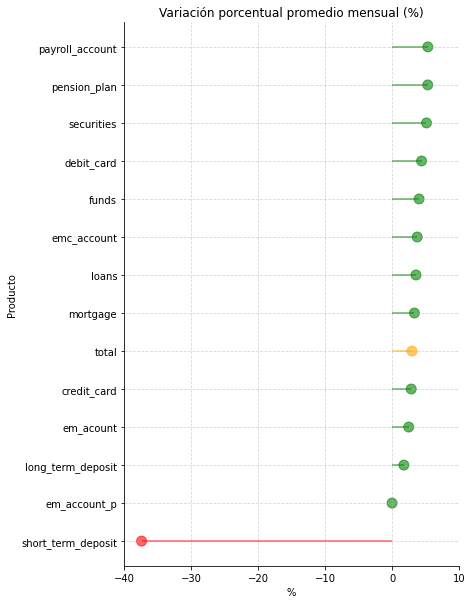

In [58]:
# gráfico de lollipop
# preparación de los datos
df=productos_var_mean12.T.copy(deep=True)
df.rename(columns={'var12':"x_plot"}, inplace=True)
df.dropna(inplace=True)
df.sort_values("x_plot", inplace = True)
df.reset_index(inplace = True)
df.rename(columns={'index':'productos'}, inplace=True)
df

df["color"] = df['productos'].apply(lambda x: "orange" if x == 'total' else ("red" if x== 'short_term_deposit' else "green"))

# instancia el gráfico
fig = plt.figure(figsize = (6, 10))
ax = fig.add_subplot()

ax.hlines(y = df.index, 
          xmin = 0,
          xmax = df["x_plot"],
          color = df["color"],
          alpha = 0.6)

# plot the dots
ax.scatter(x = df["x_plot"],
          y = df.index,
          s = 100,
          color = df["color"],
          alpha = 0.6)

# set title
ax.set_title("Variación porcentual promedio mensual (%)")

# autoscale
ax.autoscale_view()

# change x lim
ax.set_xlim(-40, 10)

# set labels
ax.set_xlabel("%")
ax.set_ylabel("Producto")

# instead of y = 1, 2, 3...
# put the products on the y axis
ax.set_yticks(df.index)
ax.set_yticklabels(df['productos'])

# change the spines to make it nicer
ax.spines["right"].set_color("None")
ax.spines["top"].set_color("None")

# add a grid
ax.grid(linestyle='--', alpha=0.5);

El gráfico anterior podemos identificar cuáles son los productos que más y menos han crecido durante el último año.

In [59]:
run = False
if run == True:
    fig.savefig('lollipop.png')

In [60]:
# Cálculo de las ventas para cada mes
productos_vtas=productos_his.index
productos_vtas=pd.DataFrame(productos_vtas)
productos_vtas.set_index('date', inplace=True)
for i in productos_his.columns:
    productos_vtas[i] = productos_his[i] - productos_his[i].shift(1)

# Tabla de contratos mensual
productos_vtas

short_term_deposit  loans  mortgage  funds  securities  \
date                                                                 
2018-01-28                 NaN    NaN       NaN    NaN         NaN   
2018-02-28              460.00   0.00      0.00  86.00       33.00   
2018-03-28              321.00   4.00      2.00  97.00        0.00   
2018-04-28               76.00   1.00      0.00 115.00       18.00   
2018-05-28             -285.00   3.00      1.00  61.00       29.00   
2018-06-28             -211.00   0.00      1.00  14.00        7.00   
2018-07-28               38.00   1.00      1.00  13.00       34.00   
2018-08-28               53.00   1.00      0.00  47.00       80.00   
2018-09-28               51.00   2.00      0.00  18.00       68.00   
2018-10-28              -12.00   2.00     -1.00  12.00      147.00   
2018-11-28             -356.00  -1.00      0.00  33.00       12.00   
2018-12-28             -490.00  -2.00      0.00  40.00       60.00   
2019-01-28             -403.00  -2.00      1.00   8.00      235.00   
2019-02-28             -114.00   1.00      0.00 -14.00       92.00   
2019-03-28               -9.00   0.00      0.00   6.00       22.00   
2019-04-28                0.00   1.00      3.00  -2.00       13.00   
2019-05-28                0.00   0.00      0.00  -5.00        7.00   

            long_term_deposit  em_account_pp  credit_card  pension_plan  \
date                                                                      
2018-01-28                NaN            NaN          NaN           NaN   
2018-02-28              72.00           0.00       -43.00        661.00   
2018-03-28               9.00           0.00       229.00        386.00   
2018-04-28             142.00           0.00       214.00        678.00   
2018-05-28             249.00           0.00        72.00       -412.00   
2018-06-28             232.00           0.00       205.00      1,487.00   
2018-07-28             208.00           0.00       135.00      1,144.00   
2018-08-28             127.00           0.00        69.00       -653.00   
2018-09-28             235.00           0.00        83.00        498.00   
2018-10-28             222.00           0.00        96.00        599.00   
2018-11-28              67.00           0.00       127.00        595.00   
2018-12-28             302.00           0.00        24.00      1,506.00   
2019-01-28             -90.00           0.00       -43.00     -2,786.00   
2019-02-28              -1.00           0.00        49.00      2,727.00   
2019-03-28            -121.00           0.00        34.00        711.00   
2019-04-28            -169.00           0.00       171.00        244.00   
2019-05-28            -239.00           0.00        54.00      1,133.00   

            payroll_account  emc_account  debit_card  em_account_p  em_acount  \
date                                                                            
2018-01-28              NaN          NaN         NaN           NaN        NaN   
2018-02-28           768.00       507.00      752.00          0.00   1,805.00   
2018-03-28           743.00       601.00    1,598.00          0.00   1,585.00   
2018-04-28           836.00       519.00      718.00          0.00   1,133.00   
2018-05-28           872.00       622.00      147.00          0.00   1,475.00   
2018-06-28        -1,157.00       381.00      917.00          0.00   3,037.00   
2018-07-28         1,376.00       235.00      750.00          0.00   9,996.00   
2018-08-28         1,202.00       148.00     -373.00          0.00  11,656.00   
2018-09-28           744.00       285.00    2,479.00          0.00  15,230.00   
2018-10-28         1,083.00       226.00    2,688.00          0.00  16,497.00   
2018-11-28         1,492.00       650.00    1,094.00          0.00   7,193.00   
2018-12-28           -78.00       549.00    1,964.00          0.00   4,028.00   
2019-01-28           965.00       878.00      -80.00          0.00   2,858.00   
2019-02-28           940.00       875.00

In [61]:
# Variación porcentual mensual por mes con respecto al mes anterior y producto
productos_crec=productos_his.index
productos_crec=pd.DataFrame(productos_crec)
productos_crec.set_index('date', inplace=True)
for i in productos_his.columns:
    productos_crec[i] = ((productos_his[i] - productos_his[i].shift(1))/productos_his[i].shift(1))*100
productos_crec

short_term_deposit  loans  mortgage  funds  securities  \
date                                                                 
2018-01-28                 NaN    NaN       NaN    NaN         NaN   
2018-02-28               52.10   0.00      0.00  10.94        3.54   
2018-03-28               23.90  21.05     13.33  11.12        0.00   
2018-04-28                4.57   4.35      0.00  11.87        1.87   
2018-05-28              -16.38  12.50      5.88   5.63        2.95   
2018-06-28              -14.50   0.00      5.56   1.22        0.69   
2018-07-28                3.05   3.70      5.26   1.12        3.34   
2018-08-28                4.13   3.57      0.00   4.01        7.60   
2018-09-28                3.82   6.90      0.00   1.48        6.00   
2018-10-28               -0.87   6.45     -5.00   0.97       12.24   
2018-11-28              -25.91  -3.03      0.00   2.64        0.89   
2018-12-28              -48.13  -6.25      0.00   3.12        4.41   
2019-01-28              -76.33  -6.67      5.26   0.61       16.55   
2019-02-28              -91.20   3.57      0.00  -1.05        5.56   
2019-03-28              -81.82   0.00      0.00   0.46        1.26   
2019-04-28                0.00   3.45     15.00  -0.15        0.73   
2019-05-28                0.00   0.00      0.00  -0.38        0.39   

            long_term_deposit  em_account_pp  credit_card  pension_plan  \
date                                                                      
2018-01-28                NaN            NaN          NaN           NaN   
2018-02-28               1.47            NaN        -1.29          7.48   
2018-03-28               0.18            NaN         6.98          4.06   
2018-04-28               2.86            NaN         6.10          6.86   
2018-05-28               4.88            NaN         1.93         -3.90   
2018-06-28               4.33            NaN         5.40         14.65   
2018-07-28               3.72            NaN         3.37          9.83   
2018-08-28               2.19            NaN         1.67         -5.11   
2018-09-28               3.97            NaN         1.97          4.11   
2018-10-28               3.61            NaN         2.24          4.74   
2018-11-28               1.05            NaN         2.90          4.50   
2018-12-28               4.68            NaN         0.53         10.90   
2019-01-28              -1.33            NaN        -0.95        -18.18   
2019-02-28              -0.02            NaN         1.09         21.75   
2019-03-28              -1.82            NaN         0.75          4.66   
2019-04-28              -2.59            NaN         3.74          1.53   
2019-05-28              -3.75            NaN         1.14          6.99   

            payroll_account  emc_account  debit_card  em_account_p  em_acount  \
date                                                                            
2018-01-28              NaN          NaN         NaN           NaN        NaN   
2018-02-28             5.70         3.31        3.05          0.00       0.84   
2018-03-28             5.22         3.80        6.28          0.00       0.73   
2018-04-28             5.58         3.16        2.65          0.00       0.52   
2018-05-28             5.51         3.67        0.53          0.00       0.67   
2018-06-28            -6.93         2.17        3.29          0.00       1.37   
2018-07-28             8.85         1.31        2.60          0.00       4.46   
2018-08-28             7.11         0.81       -1.26          0.00       4.97   
2018-09-28             4.11         1.55        8.49          0.00       6.19   
2018-10-28             5.74         1.21        8.48          0.00       6.32   
2018-11-28             7.48         3.45        3.18          0.00       2.59   
2018-12-28            -0.36         2.82        5.54          0.00       1.41   
2019-01-28             4.52         4.38       -0.21          0.00       0.99   
2019-02-28             4.21         4.18

In [62]:
# Para hacer una tabla resumen por producto y comparativa: ventas último mes, ventas mes anterior, ventas respecto mismo mes año anterior y variacion porcentual
#Cventas_mes=productos_vtas.describe().loc[['mean', 'max']].astype(int)
#ventas_mes
tabla_resu=productos_vtas.iloc[[-2,-1]]

In [63]:
tabla_resu=tabla_resu.append(productos_vtas.iloc[[-13]])
tabla_resu

short_term_deposit  loans  mortgage  funds  securities  \
date                                                                 
2019-04-28                0.00   1.00      3.00  -2.00       13.00   
2019-05-28                0.00   0.00      0.00  -5.00        7.00   
2018-05-28             -285.00   3.00      1.00  61.00       29.00   

            long_term_deposit  em_account_pp  credit_card  pension_plan  \
date                                                                      
2019-04-28            -169.00           0.00       171.00        244.00   
2019-05-28            -239.00           0.00        54.00      1,133.00   
2018-05-28             249.00           0.00        72.00       -412.00   

            payroll_account  emc_account  debit_card  em_account_p  em_acount  \
date                                                                            
2019-04-28         1,111.00       975.00      750.00          0.00     798.00   
2019-05-28         1,028.00     1,296.00    1,121.00          0.00     536.00   
2018-05-28           872.00       622.00      147.00          0.00   1,475.00   

              total  
date                 
2019-04-28 3,895.00  
2019-05-28 4,931.00  
2018-05-28 2,834.00

In [64]:
tabla_resu.index = ['vtas_mes_ant', 'vtas_mes', 'vtas_12m']
tabla_resu=tabla_resu.append(productos_var_mean12)

var1=productos_crec.iloc[[-1]]
var1.index = ['var1']

tabla_resu=tabla_resu.append(var1)
tabla_resu.fillna(0, inplace=True)
tabla_resu=tabla_resu.T

In [65]:
# Preparando los datos para hacer la tabla en dash
df=tabla_resu.copy(deep=True)

In [66]:
df['producto']=tabla_resu.index
df=df.reindex(["producto", "vtas_mes", "vtas_mes_ant", "vtas_12m", "var1", "var12" ], axis=1)

df['var1']=df['var1'].map('{:,.2f}'.format)
df['var12']=df['var12'].map('{:,.2f}'.format)

# preparando la tabla

fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Producto<b>', '<b>vtas_mes<b>', '<b>vtas_mes_ant<b>', '<b>vtas_12m<b>'],
                fill_color='green',
                align='right',
                font=dict(color='white')
                ),

    cells=dict(values=[df.producto, df.vtas_mes, df.vtas_mes_ant, df.vtas_12m, ],
               fill_color='whitesmoke',
               align='right'),
               ),

])

fig.update_layout(width=700, height=600, title='Resumen cartera de productos')


fig.show()

A continuación, incorporamos en el dashboard dos etiquetas grandes que indiquen la tasa de crecimiento con respecto al mes anterior y la tasa promedio de los últimos 12 meses (total productos). Observamos que la tasa promedio mensual de los últimos 12 meses es mucho mayor a la del último mes.

In [67]:
df['var12']=df['var12'].astype('float')
df['var1']=df['var1'].astype('float')

In [68]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = df.iloc[-1,-2],
    title = {"text": "Variación porcentual (%) <br><span style='font-size:0.8em;color:green'>Mes anterior</span>"},
    delta = {'reference': df.iloc[-1,2], 'relative': True},
    domain = {'x': [0.7, 0.5], 'y': [0, 1]}))

#fig.update_layout(width=1000, height=300)

fig.show()

In [69]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = df.iloc[-1,-1],
    #title = {"text": "Variación porcentual (%)<br><span style='font-size:0.8em;color:gray'>Subtitle</span><br><span style='font-size:0.8em;color:gray'>Subsubtitle</span>"}
    title = {"text": "Variación porcentual (%) <br><span style='font-size:0.8em;color:green'>Media últimos 12 meses</span>"},
    delta = {'reference': df.iloc[-1,2], 'relative': True},
    domain = {'x': [0.1, 1], 'y': [0.1, 0.3]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = df.iloc[-1,-2],
    title = {"text": "Variación porcentual (%) <br><span style='font-size:0.8em;color:green'>Mes anterior</span>"},
    delta = {'reference': df.iloc[-1,2], 'relative': True},
    domain = {'x': [0.1, 1], 'y': [0.5, 0.9]}))

#fig.update_layout(width=1000, height=300)

fig.show()

El siguiente conjunto de gráfico muestra por producto y mes a mes el variación porcentual, de este modo podemos ver los productos de nuestra cartera mas y menos estable a lo largo de los 17 meses.

In [70]:
productos_crec.columns.names = ['productos']

fig = px.area(productos_crec, facet_col="productos", facet_col_wrap=3, range_y=[-20, 20])

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title= 'Evolución variación porcentual mensual por producto (%)', showlegend=False)

fig.show()

In [71]:
# Agrupamos los productos por tipo y vemos como se comporta la variación porcentual mes a mes.

# ahorro_inv = ("short_term_deposit", "funds", "securities","long_term_deposit","pension_plan")

fig = go.Figure()

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['short_term_deposit'], 
    name='short_term_deposit',  fill='tozeroy', line_color='green'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['funds'], 
    name='funds', fill='tozeroy', line_color='orange'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['securities'], 
    name='securities', fill='tozeroy', line_color='indianred'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['long_term_deposit'], 
    name='long_term_deposit', fill='tozeroy', line_color='blue'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['pension_plan'], 
    name='pension_plan', fill='tozeroy', line_color='gray'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['total'], 
    name='total', fill='tozeroy', line_color='red'))


fig.update_yaxes(range=[-100, 60])
fig.update_layout(yaxis_title='Variación mensual (%)', title= 'Productos de ahorro e inversión')
fig.show()

In [72]:
# Financiaciación
fig = go.Figure()

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['loans'], 
    name='loans', fill='tozeroy', line_color='green'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['mortgage'], 
    name='mortgage', fill='tozeroy', line_color='gray'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['credit_card'], 
    name='credit_card', fill='tozeroy', line_color='orange'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['debit_card'], 
    name='debit_card', fill='tozeroy', line_color='blue'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['total'], 
    name='total', fill='tozeroy', line_color='red'))

fig.update_yaxes(range=[-10, 25])
fig.update_layout(yaxis_title='Variación mensual (%)', title= 'Productos de financiación')
fig.show()

In [73]:
# cuenta = ("em_account_pp", "payroll_account", "emc_account","em_account_p", "em_acount")

fig = go.Figure()

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['em_account_pp'], 
    name='account_pp',  fill='tozeroy', line_color='indianred'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['payroll_account'], 
    name='payroll_account', fill='tozeroy', line_color='green'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['emc_account'], 
    name='emc_account', fill='tozeroy', line_color='gray'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['em_account_p'], 
    name='em_account_p', fill='tozeroy', line_color='orange'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['em_acount'], 
    name='em_acount', fill='tozeroy', line_color='blue'))

fig.add_trace(go.Scatter(x=productos_his.index, y=productos_crec['total'], 
    name='total', fill='tozeroy', line_color='red'))


fig.update_yaxes(range=[-10, 10])
fig.update_layout(yaxis_title='Variación mensual (%)', title= 'Productos de cuentas')
fig.show()

In [74]:
del productos, productos_his, productos_var_mean12, df2

## Mapa de clientes <a class="anchor" id="6"></a>

[Tabla de Contenidos](#0)

Del campo county_id y region_code en socialdemographic_df es posible obtener tanto altas, bajas, número de productos o ingresos de cada región y país. Por lo que también es posible si se tienen la latitud y longitud de cada capital, graficar un mapa con la cantidad de clientes de cada sitio del planeta.

En este caso se representarán tan sólo los clientes activos de cada región y país. Para obtener los ingresos de cada región o país, habría que tras obtener los ingresos por cada clientes agruparlos por su localidad, algo que es más laborioso, pero posible de realizar. 

In [75]:
sociodemographic_df = pd.read_csv(PATH_DATA+'sociodemographic_df.csv')
sociodemographic_df.drop('Unnamed: 0', axis=1, inplace=True)
products_df = pd.read_csv(PATH_DATA+'products_df.csv')
products_df.drop('Unnamed: 0', axis=1, inplace=True)
commercial_df = pd.read_csv(PATH_DATA+'commercial_activity_df.csv')
commercial_df .drop('Unnamed: 0', axis=1, inplace=True)

sociodemographic_df.head()

pk_cid pk_partition country_id  region_code gender  age deceased  \
0  1375586   2018-01-28         ES        29.00      H   35        N   
1  1050611   2018-01-28         ES        13.00      V   23        N   
2  1050612   2018-01-28         ES        13.00      V   23        N   
3  1050613   2018-01-28         ES        50.00      H   22        N   
4  1050614   2018-01-28         ES        50.00      V   23        N   

      salary  
0  87,218.10  
1  35,548.74  
2 122,179.11  
3 119,775.54  
4        NaN

In [76]:
socioproducts = pd.merge(sociodemographic_df, products_df, how='inner', on=['pk_cid','pk_partition'])
socioproductscommercial = pd.merge(socioproducts, commercial_df, how='inner', on=['pk_cid','pk_partition'])
socioproductscommercial.head()

pk_cid pk_partition country_id  region_code gender  age deceased  \
0  1375586   2018-01-28         ES        29.00      H   35        N   
1  1050611   2018-01-28         ES        13.00      V   23        N   
2  1050612   2018-01-28         ES        13.00      V   23        N   
3  1050613   2018-01-28         ES        50.00      H   22        N   
4  1050614   2018-01-28         ES        50.00      V   23        N   

      salary  short_term_deposit  loans  ...  pension_plan  payroll_account  \
0  87,218.10                   0      0  ...          0.00                0   
1  35,548.74                   0      0  ...          0.00                0   
2 122,179.11                   0      0  ...          0.00                0   
3 119,775.54                   1      0  ...          0.00                0   
4        NaN                   0      0  ...          0.00                0   

   emc_account  debit_card  em_account_p  em_acount  entry_date  \
0            0           0             0          1  2018-01-12   
1            0           0             0          1  2015-08-10   
2            0           0             0          1  2015-08-10   
3            0           0             0          0  2015-08-10   
4            0           0             0          1  2015-08-10   

   entry_channel  active_customer             segment  
0            KHL             1.00   02 - PARTICULARES  
1            KHE             0.00  03 - UNIVERSITARIO  
2            KHE             0.00  03 - UNIVERSITARIO  
3            KHD             0.00  03 - UNIVERSITARIO  
4            KHE             1.00  03 - UNIVERSITARIO  

[5 rows x 27 columns]

Los países están codificados con 2 letras  <a href="https://laendercode.net/es/2-letter-code/br">Código Países</a>, además dada la larga lista de países sería interesante agruparlos por continente (dejando a España fuera de la categoría Europa pese a estar en ella dado que la mayoría de clientes son españoles).

In [77]:
paises_code = {'ES': ['ES','Spain'], 'GB':['EU','United Kingdom'], 'US':['NA','US'], 
    'FR':['EU','France'], 'CH':['EU','Switzerland'], 'DE':['EU','Germany'], 'BE':['EU','Belgium'], 
    'BR':['SA','Brazil'], 'VE':['SA','Venezuela'], 'MX':['SA','Mexico'], 'AR':['SA','Argentina'], 
    'IE':['EU','Ireland'], 'PL':['EU','Poland'], 'IT':['EU','Italy'], 'AT':['EU','Austria'], 
    'SE':['EU','Sweden'], 'CL':['SA','Chile'], 'MA':['AF','Morocco'], 'CO':['SA','Colombia'], 
    'DZ':['AF','Algeria'], 'SN':['AF','Senegal'], 'ET':['AF','Ethiopia'], 'RU':['EU','Russia'], 
    'GA':['AF','Gambia'], 'SA':['AS','Saudi Arabia'], 'MR':['AF','Mautirania'], 'HU':['EU','Hungary'], 
    'JM':['SA','Jamaica'], 'CM':['AF','Cameroon'], 'CI':['AF',"Cote d'Ivoire"], 'RO':['EU','Romania'], 
    'PE':['SA','Peru'], 'DO':['SA','Dominican Republic'], 'QA':['AS','Qatar'], 'PT':['EU','Portugal'], 
    'LU':['EU','Luxembourg'], 'DJ':['AF','Djibouti'], 'GT':['SA','Guatemala'], 'CN':['AS','China'], 
    'NO':['EU','Norway'], 'CA':['NA','Canada']}

continente = {'ES':'España', 'EU':'Europa', 'SA':'Sur América', 'NA':'Norte América', 'AS': 'Asia', 'AF':'África'}

El campo region_code corresponde a la Comunidad Autónoma en España <a href="https://es.wikipedia.org/wiki/Anexo:Provincias_de_Espa%C3%B1a_por_c%C3%B3digo_postal">Provincias en España</a>. En el siguiente diccionario se listan todos los códigos y comunidades autónomas con la correspondiente capital.

Si desea mostrar cualquier parámetro en un mapa para ello, se deberá entrar la longitud y latitud de cada capital (ya sea capital de país o de región).

Del dataset de time_series_global del Covid de la escuela de ingeniería de John Hopkins <a href="https://github.com/CSSEGISandData/COVID-19">Time Series Covid-19</a> (con el que se trabajó con Joseph) se pueden obtener las longitudes y latitudes de los países, guardamos en un csv esta información. 

Por otro lado la información de las comunidades autónomas se puede encontrar en <a href="https://www.businessintelligence.info/resources/assets/listado-longitud-latitud-municipios-espana.html">Latitud y Longitud de ciudades españolas</a>. Podría realizarse webscraping para obtener las coordenadas, sin embargo se ha optado por descargar el excel con esta lista, leer el excel y hacer un join con la información para así poder diferenciar las regiones dentro de España.

In [78]:
spanish_regions_code = {1:['Elciego', 'País Vasco'], 2:['Albacete', 'Castilla-La Mancha'], 3:['Alicante/Alacant', 'Com. Valenciana'],4:['Almería','Andalucía'],5:['Ávila','Castilla y León'], 6:['Badajoz','Extremadura'],	7:['Palma','Islas Baleares'], 8:['Barcelona','Cataluña'],9:['Burgos','Castilla y León'], 10: ['Cáceres','Extremadura'], 11: ['Cádiz','Andalucía'], 12: ['Castellón de la Plana/Castelló de la Plana','Com. Valenciana'], 13: ['Ciudad Real','Castilla-La Mancha'], 14: ['Córdoba','Andalucía'], 15: ['Coruña (A)','Galicia'], 16: ['Cuenca','Castilla-La Mancha'], 17: ['Girona','Cataluña'], 18: ['Granada','Andalucía'], 19: ['Guadalajara','Castilla-La Mancha'], 20: ['Donostia-San Sebastián','País Vasco'], 21: ['Huelva','Andalucía'], 22: ['Huesca','Aragón'], 23: ['Jaén','Andalucía'], 24: ['León','Castilla y León'], 25: ['Lleida','Cataluña'], 26: ['Logroño','La Rioja'], 27: ['Lugo','Galicia'], 28: ['Madrid','Madrid'], 29: ['Málaga','Andalucía'], 30: ['Murcia','Murcia'], 31: ['Pamplona/Iruña','Com. de Navarra'], 32: ['Ourense','Galicia'], 33: ['Oviedo','Princ. de Asturias'], 34: ['Palencia','Castilla y León'], 35: ['Palmas de Gran Canaria (Las)','Islas Canarias'], 36: ['Pontevedra','Galicia'], 37: ['Salamanca','Castilla y León'], 38: ['Santa Cruz de Tenerife','Islas Canarias'], 39: ['Santander','Cantabria'], 40: ['Segovia','Castilla y León'], 41: ['Sevilla','Andalucía'], 42: ['Soria','Castilla y León'], 43: ['Tarragona','Cataluña'], 44: ['Teruel','Aragón'], 45: ['Toledo','Castilla-La Mancha'], 46: ['Valencia','Com. Valenciana'], 47: ['Valladolid','Castilla y León'], 48: ['Bilbao','País Vasco'], 49: ['Zamora','Castilla y León'], 50: ['Zaragoza','Aragón'], 51: ['Ceuta','Ceuta y Melilla'], 52: ['Melilla','Ceuta y Melilla']}
spanish_regions_code

{1: ['Elciego', 'País Vasco'],
 2: ['Albacete', 'Castilla-La Mancha'],
 3: ['Alicante/Alacant', 'Com. Valenciana'],
 4: ['Almería', 'Andalucía'],
 5: ['Ávila', 'Castilla y León'],
 6: ['Badajoz', 'Extremadura'],
 7: ['Palma', 'Islas Baleares'],
 8: ['Barcelona', 'Cataluña'],
 9: ['Burgos', 'Castilla y León'],
 10: ['Cáceres', 'Extremadura'],
 11: ['Cádiz', 'Andalucía'],
 12: ['Castellón de la Plana/Castelló de la Plana', 'Com. Valenciana'],
 13: ['Ciudad Real', 'Castilla-La Mancha'],
 14: ['Córdoba', 'Andalucía'],
 15: ['Coruña (A)', 'Galicia'],
 16: ['Cuenca', 'Castilla-La Mancha'],
 17: ['Girona', 'Cataluña'],
 18: ['Granada', 'Andalucía'],
 19: ['Guadalajara', 'Castilla-La Mancha'],
 20: ['Donostia-San Sebastián', 'País Vasco'],
 21: ['Huelva', 'Andalucía'],
 22: ['Huesca', 'Aragón'],
 23: ['Jaén', 'Andalucía'],
 24: ['León', 'Castilla y León'],
 25: ['Lleida', 'Cataluña'],
 26: ['Logroño', 'La Rioja'],
 27: ['Lugo', 'Galicia'],
 28: ['Madrid', 'Madrid'],
 29: ['Málaga', 'Andalucía'

In [79]:
country_lon_lat = pd.read_csv(PATH_DATA+'country_lon_lat.csv', encoding='utf-8', index_col=0)

# China y Canada faltan!
country_lon_lat = country_lon_lat.append( {'Country/Region': 'China', 'Lat':35.86166, 'Long':104.195397}, ignore_index=True)
country_lon_lat = country_lon_lat.append( {'Country/Region': 'Canada', 'Lat':56.130366, 'Long':-106.346771}, ignore_index=True)
country_lon_lat.head()

Country/Region    Lat  Long
0    Afghanistan  33.94 67.71
1        Albania  41.15 20.17
2        Algeria  28.03  1.66
3        Andorra  42.51  1.52
4         Angola -11.20 17.87

In [80]:
lon_lat = pd.read_excel(PATH_DATA+'listado-longitud-latitud-municipios-espana.xls', skiprows=2)
lon_lat.head()

Comunidad Provincia  Población  Latitud  Longitud  Altitud  Habitantes  \
0  Andalucía   Almería       Abla    37.14     -2.78   871.17        1504   
1  Andalucía   Almería   Abrucena    37.13     -2.80   976.94        1341   
2  Andalucía   Almería       Adra    36.75     -3.02    10.98       24373   
3  Andalucía   Almería  Albánchez    37.29     -2.18   481.31         815   
4  Andalucía   Almería  Alboloduy    37.03     -2.62   388.43         674   

   Hombres  Mujeres  
0      783      721  
1      682      659  
2    12338    12035  
3      422      393  
4      334      340

In [81]:
spain = pd.DataFrame(spanish_regions_code).T
spain.columns = ['Ciudad','Com.Autonoma']
spain.head()

Ciudad        Com.Autonoma
1           Elciego          País Vasco
2          Albacete  Castilla-La Mancha
3  Alicante/Alacant     Com. Valenciana
4           Almería           Andalucía
5             Ávila     Castilla y León

In [82]:
spain_lot_lat = pd.merge(spain, lon_lat[['Provincia','Población','Latitud','Longitud']], left_on='Ciudad', right_on='Población', how='left')
spain_lot_lat.head(30)

Ciudad        Com.Autonoma  \
0                                      Elciego          País Vasco   
1                                     Albacete  Castilla-La Mancha   
2                             Alicante/Alacant     Com. Valenciana   
3                                      Almería           Andalucía   
4                                        Ávila     Castilla y León   
5                                      Badajoz         Extremadura   
6                                        Palma      Islas Baleares   
7                                    Barcelona            Cataluña   
8                                       Burgos     Castilla y León   
9                                      Cáceres         Extremadura   
10                                       Cádiz           Andalucía   
11  Castellón de la Plana/Castelló de la Plana     Com. Valenciana   
12                                 Ciudad Real  Castilla-La Mancha   
13                                     Córdoba           Andalucía   
14                                  Coruña (A)             Galicia   
15                                      Cuenca  Castilla-La Mancha   
16                                      Girona            Cataluña   
17                                     Granada           Andalucía   
18                                 Guadalajara  Castilla-La Mancha   
19                      Donostia-San Sebastián          País Vasco   
20                                      Huelva           Andalucía   
21                                      Huesca              Aragón   
22                                        Jaén           Andalucía   
23                                        León     Castilla y León   
24                                      Lleida            Cataluña   
25                                     Logroño            La Rioja   
26                                        Lugo             Galicia   
27                                      Madrid              Madrid   
28                                      Málaga           Andalucía   
29                                      Murcia              Murcia   

             Provincia                                   Población  Latitud  \
0                Álava                                     Elciego    42.52   
1             Albacete                                    Albacete    39.00   
2     Alicante/Alacant                            Alicante/Alacant    38.35   
3              Almería                                     Almería    36.84   
4                Ávila                                       Ávila    40.66   
5              Badajoz                                     Badajoz    38.88   
6        Illes Balears                                       Palma    39.57   
7            Barcelona                                   Barcelona    41.39   
8               Burgos                                      Burgos    42.34   
9              Cáceres                                     Cáceres    39.48   
10               Cádiz                                       Cádiz    36.53   
11  Castellón/Castelló  Castellón de la Plana/Castelló de la Plana    39.99   
12         Ciudad Real                                 Ciudad Real    38.99   
13             Córdoba                                     Córdoba    37.88   
14            A Coruña                                  Coruña (A)    43.37   
15              Cuenca                                      Cuenca    40.07   
16              Girona                                      Girona    41.98   
17             Granada                                     Granada    37.18   
18         Guadalajara                                 Guadalajara    40.63   
19           Guipúzcoa                      Donostia-San Sebastián    43.32   
20              Huelva                                      Huelva    37.26   
21              Huesca                                      Huesca    42.14   
22                Jaén                              

Finalmente se representan en el mapa los clientes activos siendo éstos clientes con almenos 1 producto contratado y siendo activos en la plataforma, es decir, active_customer = 1. 

In [83]:
active_clients = socioproductscommercial.copy(deep=True)
active_clients['num_products'] = active_clients[list_products].sum(axis=1)
active_clients = active_clients[ (active_clients['num_products'] != 0) & (active_clients['active_customer'] != 0) & (active_clients['pk_partition'] == '2019-05-28') ]
active_clients.head()

pk_cid pk_partition country_id  region_code gender  age deceased  \
5519929  657826   2019-05-28         ES        25.00      H   44        N   
5519931  657986   2019-05-28         ES        41.00      H   39        N   
5519932  657905   2019-05-28         ES        28.00      H   85        N   
5519933  657336   2019-05-28         ES        28.00      V   38        N   
5519935  658184   2019-05-28         ES        28.00      V   42        N   

            salary  short_term_deposit  loans  ...  payroll_account  \
5519929  54,493.38                   0      0  ...                0   
5519931 100,993.17                   0      0  ...                1   
5519932 154,059.09                   0      0  ...                0   
5519933        NaN                   0      0  ...                0   
5519935 183,036.72                   0      0  ...                1   

         emc_account  debit_card  em_account_p  em_acount  entry_date  \
5519929            0           0             0          1  2015-05-24   
5519931            1           1             0          0  2016-02-18   
5519932            0           0             0          1  2017-02-07   
5519933            0           0             0          1  2019-03-28   
5519935            1           1             0          0  2015-05-15   

         entry_channel  active_customer            segment  num_products  
5519929            013             1.00  02 - PARTICULARES          1.00  
5519931            KAF             1.00  02 - PARTICULARES          5.00  
5519932            KAT             1.00           01 - TOP          2.00  
5519933            KAT             1.00  02 - PARTICULARES          1.00  
5519935            KAT             1.00  02 - PARTICULARES          5.00  

[5 rows x 28 columns]

In [84]:
country_match = {}
for key, value in paises_code.items():
  country_match[key] = value[1]

active_clients['Pais'] = active_clients['country_id'].replace(country_match)

In [85]:
region_match = {}
for key, value in spanish_regions_code.items():
  region_match[key] = value[0]

active_clients['Region'] = active_clients['region_code'].replace(region_match)

In [86]:
clients_df = pd.merge(active_clients, country_lon_lat, how='left', left_on ='Pais', right_on='Country/Region')
clients_df = pd.merge(clients_df, spain_lot_lat, how='left', left_on ='Region', right_on='Ciudad')

clients_df['Lat'] = np.where( clients_df['Latitud'].isna(), clients_df['Lat'], clients_df['Latitud'] )
clients_df['Long'] = np.where( clients_df['Longitud'].isna(), clients_df['Long'], clients_df['Longitud'] )

clients_df['Region'].fillna('', inplace=True)

clients_df.head()

pk_cid pk_partition country_id  region_code gender  age deceased  \
0  657826   2019-05-28         ES        25.00      H   44        N   
1  657986   2019-05-28         ES        41.00      H   39        N   
2  657905   2019-05-28         ES        28.00      H   85        N   
3  657336   2019-05-28         ES        28.00      V   38        N   
4  658184   2019-05-28         ES        28.00      V   42        N   

      salary  short_term_deposit  loans  ...   Region  Country/Region   Lat  \
0  54,493.38                   0      0  ...   Lleida           Spain 41.61   
1 100,993.17                   0      0  ...  Sevilla           Spain 37.38   
2 154,059.09                   0      0  ...   Madrid           Spain 40.42   
3        NaN                   0      0  ...   Madrid           Spain 40.42   
4 183,036.72                   0      0  ...   Madrid           Spain 40.42   

   Long   Ciudad  Com.Autonoma  Provincia  Población  Latitud  Longitud  
0  0.63   Lleida      Cataluña     Lleida     Lleida    41.61      0.63  
1 -6.00  Sevilla     Andalucía    Sevilla    Sevilla    37.38     -6.00  
2 -3.70   Madrid        Madrid     Madrid     Madrid    40.42     -3.70  
3 -3.70   Madrid        Madrid     Madrid     Madrid    40.42     -3.70  
4 -3.70   Madrid        Madrid     Madrid     Madrid    40.42     -3.70  

[5 rows x 39 columns]

In [87]:
results_df = clients_df.groupby(['Pais','Region','Lat','Long'])[['pk_cid']].count()
results_df.reset_index(inplace=True)
results_df

Pais Region    Lat    Long  pk_cid
0          Algeria         28.03    1.66       1
1        Argentina        -38.42  -63.62       3
2          Austria         47.52   14.55       3
3          Belgium         50.83    4.47       2
4           Brazil        -14.23  -51.93       2
..             ...    ...    ...     ...     ...
76           Spain  Ávila  40.66   -4.70     812
77     Switzerland         46.82    8.23      11
78              US         40.00 -100.00       8
79  United Kingdom         55.38   -3.44      25
80       Venezuela          6.42  -66.59       2

[81 rows x 5 columns]

In [88]:
if run == True:
    results_df.to_csv(PATH_DATA+'mapa_clientes.csv')

In [89]:
#import calmap

mapa_global = folium.Map(location=[40, 1], tiles='cartodbpositron',
               min_zoom=5, max_zoom=5, zoom_start=5)

for i in range(0, len(results_df)):
    folium.Circle(
        location=[results_df.iloc[i]['Lat'], results_df.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(results_df.iloc[i]['Pais'])+
                    '<li><bold>Province : '+str(results_df.iloc[i]['Region']+
                    '<li><bold>Active Users : '+str(results_df.iloc[i]['pk_cid'])),
        radius=int(17000)).add_to(mapa_global)
        #radius=int(results_df.iloc[i]['pk_cid'])**1.1).add_to(mapa_global)
        
mapa_global

In [90]:
del spain, results_df, mapa_global, clients_df, active_clients

Dado que el proceso para la obtención de esta gráfica es largo y tarda bastante al tener que leer los 3 datasets (y como el dashboard estará en un servidor por lo que cuanto menos demanda de RAM y menor el tiempo de ejecución mucho mejor). 

Se guarda en un csv el número de clientes activos por cada país y región. Este csv después es convertido a una tabla SQL y así tan sólo basta con leer los datos de la tabla y poder obtener la imagen.

## Tipos de clientes <a class="anchor" id="7"></a>

### Clientes activos <a class="anchor" id="71"></a>

[Tabla de Contenidos](#0)

Como se mencionaba anteriormente, se pueden obtener los clientes activos siendo éstos clientes con almenos con al menos 1 producto contratado y siendo activos en la plataforma (active_customer = 1). En este caso, se puede obtener el número de clientes activos por producto y en cada partición.

In [91]:
commercial_products = pd.merge(commercial_df, products_df, on=['pk_cid','pk_partition'], how='left')
commercial_products_sorted = commercial_products.sort_values(by=['pk_cid', 'pk_partition'])

In [92]:
active_customers = commercial_products_sorted [ (commercial_products_sorted[list_products].max(axis=1) == 1) & (commercial_products_sorted['active_customer'] == 1) ]

active_customers_df = pd.DataFrame()

for prod in list_products:
    df_ = commercial_products_sorted [ (commercial_products_sorted[prod] == 1) & (commercial_products_sorted['active_customer'] == 1)]
    active_customers_df[prod] = df_.groupby('pk_partition')[prod].count()

active_customers_df['totales'] = active_customers.groupby('pk_partition')['pk_cid'].count()
active_customers_df.fillna(0, inplace=True)
active_customers_df

short_term_deposit  loans  mortgage  funds  securities  \
pk_partition                                                           
2018-01-28                   558     18        15    769         918   
2018-02-28                   891     18        15    856         951   
2018-03-28                  1141     22        17    955         954   
2018-04-28                  1278     24        17   1070         972   
2018-05-28                  1194     27        18   1133        1001   
2018-06-28                  1171     27        19   1155        1012   
2018-07-28                  1282     28        20   1171        1048   
2018-08-28                  1335     29        20   1218        1128   
2018-09-28                  1386     31        20   1236        1196   
2018-10-28                  1374     33        19   1248        1342   
2018-11-28                  1018     32        19   1281        1354   
2018-12-28                   528     30        19   1321        1414   
2019-01-28                   125     28        20   1329        1650   
2019-02-28                    11     29        20   1314        1740   
2019-03-28                     2     29        20   1320        1763   
2019-04-28                     2     30        23   1318        1777   
2019-05-28                     2     30        23   1313        1785   

              long_term_deposit  em_account_pp  credit_card  payroll_account  \
pk_partition                                                                   
2018-01-28                 4690           0.00         3180            12855   
2018-02-28                 4790           0.00         3153            13603   
2018-03-28                 4852           0.00         3391            14331   
2018-04-28                 5018           0.00         3615            15169   
2018-05-28                 5285           0.00         3700            16018   
2018-06-28                 5552           0.00         3939            15183   
2018-07-28                 5796           0.00         4121            16561   
2018-08-28                 5923           0.00         4196            17689   
2018-09-28                 6158           0.00         4270            18380   
2018-10-28                 6380           0.00         4366            19344   
2018-11-28                 6447           0.00         4494            20751   
2018-12-28                 6749           0.00         4511            20961   
2019-01-28                 6659           0.00         4463            21843   
2019-02-28                 6658           0.00         4512            22690   
2019-03-28                 6537           0.00         4549            23748   
2019-04-28                 6368           0.00         4721            24778   
2019-05-28                 6129           0.00         4779            25723   

              pension_plan  emc_account  debit_card  em_account_p  em_acount  \
pk_partition                                                                   
2018-01-28            8616        12912       23845             2      88544   
2018-02-28            9299        13371       24630             2      90352   
2018-03-28            9720        13931       26260             2      92087   
2018-04-28           10411        14432       27125             2      93553   
2018-05-28           10036        15001       27485             2      95196   
2018-06-28           11533        15411       28558             2      98219   
2018-07-28           12684        15731       29369             2     103879   
2018-08-28           12050        15840       28987             2     109605   
2018-09-28           12607        16098       31254             2     117190   
2018-10-28           13203        16281       34024             2     123284   
2018-11-28           13796        16870       35194             2     125795   
2018-12-28           15299        17433       37134             2     128481   
2019

In [93]:
if run == True:
    active_customers_df.to_csv(PATH_DATA+'usuarios_activos.csv')

In [94]:
resumen_usuarios = active_customers_df[['totales']]
resumen_usuarios.reset_index(inplace=True)

Otra manera de representar una evolución temporal es con una gráfica polar, donde en cada una de las direcciones ($\theta$) se colocan los meses y en los radios los valores en estos meses. En este caso se representan los usuarios activos.

Este tipo de gráfica permite observar estacionalidades y cómo se evoluciona año tras año. Una gráfica similar que muestra el potencial que tienen las gráficas polares para la representación de series temporales puede observarse en <a href="https://otexts.com/fpp2/seasonal-plots.html">Seasonal plots en Forecasting: Principles and Practice</a>.

In [95]:
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

resumen_usuarios['pk_partition'] = pd.to_datetime(resumen_usuarios['pk_partition'])
resumen_usuarios['month'] = resumen_usuarios['pk_partition'].dt.month
resumen_usuarios['year'] = resumen_usuarios['pk_partition'].dt.year

months = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}

resumen_usuarios['month_name'] = resumen_usuarios['month'].map(months)

month_map = {'Enero':4,'Febrero':3,'Marzo':2,'Abril':1,'Mayo':12,'Junio':10,'Julio':10,'Agosto':9,'Septiembre':8,'Octubre':7,'Noviembre':6,'Diciembre':5}
resumen_usuarios = resumen_usuarios.sort_values('month')

resumen_usuarios['order'] = resumen_usuarios['month_name'].map(month_map)
resumen_usuarios = resumen_usuarios.sort_values('order')

df_2019 = resumen_usuarios[resumen_usuarios['year'] == 2019]
df_2018 = resumen_usuarios[resumen_usuarios['year'] == 2018]

#
df_2018 = df_2018.append( {'pk_partition':'enero', 'ingresos':np.nan, 'month':1, 'month_name':months[1], 'order':month_map[months[1]]}, ignore_index=True )
df_2018 = df_2018.sort_values('order')

fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=df_2018['totales'], theta=df_2018['month_name'], name='2018', mode='markers', marker=dict(size=20)))
fig.add_trace(go.Scatterpolar(r=df_2019['totales'], theta=df_2019['month_name'], name='2019', mode='markers', marker=dict(size=20)))

fig.update_layout(
    polar = dict(
      radialaxis = dict(
        angle = -90,
        tickangle = -90 # so that tick labels are not upside down
      )
    )
)

fig.show()

### Nuevos clientes <a class="anchor" id="72"></a>

[Tabla de Contenidos](#0)

Un punto importante que se remarcaba en los emails era conocer el número de clientes nuevos cada mes. Una vez conocidos, es posible determinar que altas provienen de clientes de nueva entrada o de clientes recurrentes.

Un cliente nuevo se considera alguien que aparece por primera vez en la base de datos y solicita un producto. Sin embargo, aquellos clientes que aparezcan en la base de datos por primera vez, pero que no soliciten ningún producto en su entrada no se consideran como clientes nuevos. 

In [96]:
commercial_products = pd.merge(commercial_df, products_df, on=['pk_cid','pk_partition'], how='left')

In [97]:
from datetime import datetime as dt
# 2015-02-29 = esta fecha no existe!

wrong_dates = {'2015-02-29': '2015-02-28', '2019-02-29':'2019-02-28'}

commercial_products['entry_date'] = commercial_products['entry_date'].replace(wrong_dates)
commercial_products['entry_date'] = pd.to_datetime(commercial_products['entry_date'], format='%Y-%m-%d')

commercial_products['pk_partition'] = commercial_products['pk_partition'].replace(wrong_dates)
commercial_products['pk_partition'] = pd.to_datetime(commercial_products['pk_partition'], format='%Y-%m-%d')

In [98]:
for x in list_products:
    commercial_products[x] = commercial_products[x].astype(bool)

In [99]:
commercial_products_sorted = commercial_products.sort_values(by=['pk_cid', 'pk_partition'])

In [100]:
commercial_products_sorted['status'] = commercial_products_sorted [list_products].max(axis='columns')
commercial_products_sorted['status_shift'] = commercial_products_sorted .groupby('pk_cid')['status'].shift(1)
commercial_products_sorted['diff'] = commercial_products_sorted['status'] - commercial_products_sorted['status_shift']

# son nuevos si no tenian status_shift 
new_clients_df = commercial_products_sorted [ (commercial_products_sorted['status'] == 1) & (commercial_products_sorted['status_shift'].isna()) ]
new_clients_df = new_clients_df[ new_clients_df['pk_partition'] != '2018-01-28' ]

#new_clients_df['buy'] = new_clients_df[list_products].sum(axis=1)

new_clients_df

pk_cid pk_partition entry_date entry_channel  active_customer  \
1479563    15891   2018-07-28 2018-07-28           KAT             1.00   
1222863    17980   2018-05-28 2018-05-04           KFA             1.00   
729004     21719   2018-04-28 2018-04-09           KAT             1.00   
4480613    22635   2019-02-28 2019-02-03           KAT             1.00   
1222877    22648   2018-05-28 2018-05-06           KAT             0.00   
...          ...          ...        ...           ...              ...   
5679860  1553456   2019-05-28 2019-05-30           NaN             1.00   
5679799  1553541   2019-05-28 2019-05-31           NaN             1.00   
5679954  1553559   2019-05-28 2019-05-31           NaN             1.00   
5679949  1553565   2019-05-28 2019-05-31           NaN             0.00   
5679945  1553571   2019-05-28 2019-05-31           NaN             1.00   

                   segment  short_term_deposit  loans  mortgage  funds  ...  \
1479563                NaN               False  False     False  False  ...   
1222863           01 - TOP               False  False     False   True  ...   
729004   02 - PARTICULARES               False  False     False  False  ...   
4480613                NaN               False  False     False  False  ...   
1222877  02 - PARTICULARES               False  False     False  False  ...   
...                    ...                 ...    ...       ...    ...  ...   
5679860                NaN               False  False     False  False  ...   
5679799                NaN               False  False     False  False  ...   
5679954                NaN               False  False     False  False  ...   
5679949                NaN               False  False     False  False  ...   
5679945                NaN               False  False     False  False  ...   

         payroll  pension_plan  payroll_account  emc_account  debit_card  \
1479563     0.00         False            False        False       False   
1222863     0.00         False            False        False       False   
729004      0.00         False             True        False       False   
4480613     0.00         False            False        False       False   
1222877     0.00         False            False        False       False   
...          ...           ...              ...          ...         ...   
5679860     0.00         False            False        False       False   
5679799     0.00         False            False        False       False   
5679954     0.00         False            False        False       False   
5679949     0.00         False            False        False       False   
5679945     0.00         False            False        False       False   

         em_account_p  em_acount  status  status_shift  diff  
1479563         False       True    True           NaN   NaN  
1222863         False      False    True           NaN   NaN  
729004          False      False    True           NaN   NaN  
4480613         False       True    True           NaN   NaN  
1222877         False       True    True           NaN   NaN  
...               ...        ...     ...           ...   ...  
5679860         False       True    True           NaN   NaN  
5679799         False       True    True           NaN   NaN  
5679954         False       True    True           NaN   NaN  
5679949         False       True    True           NaN   NaN  
5679945         False       True    True           NaN   NaN  

[93570 rows x 24 columns]

In [101]:
products_new_clients = new_clients_df.groupby('pk_partition')[list_products].sum()

products_new_clients.reset_index()

pk_partition  short_term_deposit  loans  mortgage  funds  securities  \
0    2018-02-28                 401      0         0      1           3   
1    2018-03-28                 254      0         0      4           2   
2    2018-04-28                 191      1         0      4           3   
3    2018-05-28                 174      0         0      6           6   
4    2018-06-28                 197      0         0      1           7   
5    2018-07-28                 225      0         0      1           6   
6    2018-08-28                 167      0         0      0           2   
7    2018-09-28                 169      0         0      2           3   
8    2018-10-28                 112      0         0      2           3   
9    2018-11-28                   4      0         0      2           2   
10   2018-12-28                   0      0         0      1           5   
11   2019-01-28                   0      0         0      2           4   
12   2019-02-28                   0      0         0      0           5   
13   2019-03-28                   0      1         0      0           2   
14   2019-04-28                   0      0         0      2           3   
15   2019-05-28                   0      0         0      0           0   

    long_term_deposit  em_account_pp  credit_card  payroll_account  \
0                  26              0           29               59   
1                  46              0           31               52   
2                  46              0           14               63   
3                  58              0           14               63   
4                  68              0           20               56   
5                  73              0           17               72   
6                  34              0            2               36   
7                  53              0            3               35   
8                  65              0            1               41   
9                  54              0            3               92   
10                 66              0            1              152   
11                 20              0            2               54   
12                 23              0            1               46   
13                  3              0            6               30   
14                  1              0            7               40   
15                  0              0            3               20   

    pension_plan  emc_account  debit_card  em_account_p  em_acount  
0             55           14          91             0       3286  
1             83           13         117             0       3004  
2             60           15          93             0       2605  
3             47           12          73             0       2680  
4             63            6          76             0       2497  
5             96           12         104             0      12087  
6             37            6          66             0      10710  
7             44            9          89             0      15717  
8             55           11          89             0      15884  
9             61            7          74             0       8193  
10            60            9          71             0       2883  
11            47            9          73             0       3576  
12            44           13          83             0       2437  
13            33            8          81             0       2438  
14            49           16          56             0       1650  
15            28           14          55             0       1569

Finalmente podemos obtener el número de clientes nuevos para cada producto en cada una de las particiones, como también el número de nuevos clientes totales. Nótese que la suma de clientes por productos no es igual a la total, dado que un cliente puede darse de alta con varios productos su primera vez (algo poco común como se observará más adelante). 

Los clientes totales tan sólo muestran los clientes nuevos en total, indiferentemente si se han dado de alta con 1 o más productos. 

In [102]:
# Nuevos clientes
new_clients = pd.DataFrame(new_clients_df.groupby('pk_partition')['loans'].count())
new_clients.reset_index(inplace=True)
new_clients.columns = ['pk_partition','totales']

# Productos de nuevos clientes
products_new_clients = new_clients_df.groupby('pk_partition')[list_products].sum()
products_new_clients.reset_index(inplace=True)

products_new_clients = pd.merge( products_new_clients, new_clients, on='pk_partition', how='left')

products_new_clients

pk_partition  short_term_deposit  loans  mortgage  funds  securities  \
0    2018-02-28                 401      0         0      1           3   
1    2018-03-28                 254      0         0      4           2   
2    2018-04-28                 191      1         0      4           3   
3    2018-05-28                 174      0         0      6           6   
4    2018-06-28                 197      0         0      1           7   
5    2018-07-28                 225      0         0      1           6   
6    2018-08-28                 167      0         0      0           2   
7    2018-09-28                 169      0         0      2           3   
8    2018-10-28                 112      0         0      2           3   
9    2018-11-28                   4      0         0      2           2   
10   2018-12-28                   0      0         0      1           5   
11   2019-01-28                   0      0         0      2           4   
12   2019-02-28                   0      0         0      0           5   
13   2019-03-28                   0      1         0      0           2   
14   2019-04-28                   0      0         0      2           3   
15   2019-05-28                   0      0         0      0           0   

    long_term_deposit  em_account_pp  credit_card  payroll_account  \
0                  26              0           29               59   
1                  46              0           31               52   
2                  46              0           14               63   
3                  58              0           14               63   
4                  68              0           20               56   
5                  73              0           17               72   
6                  34              0            2               36   
7                  53              0            3               35   
8                  65              0            1               41   
9                  54              0            3               92   
10                 66              0            1              152   
11                 20              0            2               54   
12                 23              0            1               46   
13                  3              0            6               30   
14                  1              0            7               40   
15                  0              0            3               20   

    pension_plan  emc_account  debit_card  em_account_p  em_acount  totales  
0             55           14          91             0       3286     3619  
1             83           13         117             0       3004     3236  
2             60           15          93             0       2605     2812  
3             47           12          73             0       2680     2874  
4             63            6          76             0       2497     2697  
5             96           12         104             0      12087    12328  
6             37            6          66             0      10710    10834  
7             44            9          89             0      15717    15849  
8             55           11          89             0      15884    16016  
9             61            7          74             0       8193     8312  
10            60            9          71             0       2883     3069  
11            47            9          73             0       3576     3646  
12            44           13          83             0       2437     2498  
13            33            8          81             0       2438     2481  
14            49           16          56             0       1650     1703  
15            28           14          55             0       1569     1596

In [103]:
if run == True:
    products_new_clients.to_csv(PATH_DATA + 'clientes_primerizos.csv')

In [104]:
#list_ingresos = []
#for key, value in products_dict.items():
#    products_new_clients[key+'_revenue'] = products_new_clients[key] * cost_product[value]
#    list_ingresos.append(key+'_revenue')

#products_new_clients['total_ingresos'] = products_new_clients[list_ingresos].sum(axis=1)
#products_new_clients


Conocidos los productos que solicitan los que los clientes de nueva entrada, es posible conocer que productos son más solicitados por éstos. En la siguiente gráfica se observa la cantidad de productos agrupados por tipo de producto.

Sin duda, em_acount es el más exitoso entre los clientes de nueva entrada. 

In [105]:
ahorros, financiacion, cuentas = tipos_producto(products_new_clients, products_dict)

ahorros_list = []
financiacion_list = []
cuentas_list = []

for key, val in products_dict.items():
  if val == 'ahorro e inversión':
    ahorros_list.append(key)
  if val == 'financiación':
    financiacion_list.append(key)
  if val == 'cuenta':
    cuentas_list.append(key)

fig = go.Figure()

x = ['ahorro e inversión']
for key, value in zip(ahorros_list, ahorros[ahorros_list].sum(axis=0)):
  fig.add_trace(go.Bar(x=x, y=[value], name=key))

x = ['financiación']
for key, value in zip(financiacion_list, financiacion[financiacion_list].sum(axis=0)):
  fig.add_trace(go.Bar(x=x, y=[value], name=key))

x = ['cuenta']
for key, value in zip(cuentas_list, cuentas[cuentas_list].sum(axis=0)):
  fig.add_trace(go.Bar(x=x, y=[value], name=key))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})

fig.show()

### Clientes recurrentes <a class="anchor" id="73"></a>

[Tabla de Contenidos](#0)

Una vez obtenidos los clientes nuevos y las altas que éstos generan, y conocidas las altas en total, es posible diferenciar entre las altas que provienen de clientes de nueva entrada o de clientes recurrentes. 

Dado que:
$$altas_{totales} = altas_{clientes \; nuevos} +  altas_{clientes \; recurrentes}$$

In [106]:
totales = alta_baja_total (contrataciones_nuevas, 'value')
#totales.set_index('pk_partition', inplace=True)
totales = totales.iloc[1:]
  
try: 
    products_new_clients.set_index('pk_partition', inplace=True)
except: 
    pass

new = products_new_clients[list_products].sum(axis=1).to_frame().reset_index()
new.columns = ['pk_partition','new']
totales['pk_partition'] = pd.to_datetime( totales['pk_partition'] )

totales = pd.merge(totales, new, how='left', on='pk_partition')
#totales['new'] = products_new_clients[list_products].sum(axis=1)
totales['recurrent'] = totales['value'] - totales['new']

In [107]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=totales["pk_partition"], y= totales["value"], name='Totales'))
fig.add_trace(go.Scatter(x=totales["pk_partition"], y= totales["recurrent"], name='Clientes Recurrentes'))
fig.add_trace(go.Scatter(x=totales["pk_partition"], y= totales["new"], name='Clientes Nuevos'))

fig.update_yaxes(range=[0, totales.max()['value']*1.05])
fig.update_layout(title= 'Evolución de las altas',
                   yaxis_title='Altas mensuales')

fig.show()

### Clientes pagadores y no pagadores <a class="anchor" id="74"></a>

[Tabla de Contenidos](#0)

Otra métrica interesante a obtener es la evolución temporal de los clientes según si son pagadores o no. Siendo un cliente pagador alguien que compró un producto y un no pagador alguien que estando en nuestra base de datos nunca compró un producto.

El reto en este punto es diferenciar los clientes según su actividad en cada producto. Es decir, puede ocurrir que un cliente no cumpla la permanencia en un producto pero sí lo haga en otro producto ese mismo mes, por lo que se debe particularizar en cada producto para después poder obtener qué clientes son pagadores o no.

In [108]:
commercial_products_sorted = commercial_products.sort_values(by=['pk_cid', 'pk_partition'])
commercial_products_sorted

pk_cid pk_partition entry_date entry_channel  active_customer  \
1479563    15891   2018-07-28 2018-07-28           KAT             1.00   
2168122    15891   2018-08-28 2018-07-28           KAT             0.00   
2962973    16063   2018-11-28 2018-11-19           KAT             1.00   
3628236    16063   2018-12-28 2018-11-19           KAT             1.00   
4028169    16063   2019-01-28 2018-11-19           KAT             1.00   
...          ...          ...        ...           ...              ...   
5679916  1553685   2019-05-28 2019-05-31           NaN             0.00   
5679915  1553686   2019-05-28 2019-05-31           NaN             0.00   
5679914  1553687   2019-05-28 2019-05-31           NaN             0.00   
5679913  1553688   2019-05-28 2019-05-31           NaN             0.00   
5679912  1553689   2019-05-28 2019-05-31           NaN             0.00   

                   segment  short_term_deposit  loans  mortgage  funds  ...  \
1479563                NaN               False  False     False  False  ...   
2168122  02 - PARTICULARES               False  False     False  False  ...   
2962973                NaN               False  False     False  False  ...   
3628236  02 - PARTICULARES               False  False     False  False  ...   
4028169  02 - PARTICULARES               False  False     False  False  ...   
...                    ...                 ...    ...       ...    ...  ...   
5679916                NaN               False  False     False  False  ...   
5679915                NaN               False  False     False  False  ...   
5679914                NaN               False  False     False  False  ...   
5679913                NaN               False  False     False  False  ...   
5679912                NaN               False  False     False  False  ...   

         long_term_deposit  em_account_pp  credit_card  payroll  pension_plan  \
1479563              False          False        False     0.00         False   
2168122              False          False        False     0.00         False   
2962973              False          False        False     0.00         False   
3628236              False          False        False     0.00         False   
4028169              False          False        False     0.00         False   
...                    ...            ...          ...      ...           ...   
5679916              False          False        False     0.00         False   
5679915              False          False        False     0.00         False   
5679914              False          False        False     0.00         False   
5679913              False          False        False     0.00         False   
5679912              False          False        False     0.00         False   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  
1479563            False        False       False         False       True  
2168122            False        False       False         False      False  
2962973            False        False       False         False      False  
3628236            False        False       False         False      False  
4028169            False        False       False         False      False  
...                  ...          ...         ...           ...        ...  
5679916            False        False       False         False      False  
5679915            False        False       False         False      False  
5679914            False        False       False         False      False  
5679913            False        False       False         False      False  
5679912            False        False       False         False      False  

[5962924 rows x 21 columns]

In [109]:
len(commercial_products_sorted['pk_cid'].unique())

456373

In [110]:
# Hay clientes que pueden ser no pagadores: se dan de alta de un producto (no pasan 3 meses), se dan de alta de otro en el mes 3... Hay que mirar por producto
paying_customers = {}
for prod in list_products:
    comm = commercial_products_sorted[['pk_partition','pk_cid',prod]]
    comm['prev_month1'] = comm.groupby('pk_cid')[prod].shift(1)
    comm['prev_month2'] = comm.groupby('pk_cid')[prod].shift(2)
    comm['prev_month3'] = comm.groupby('pk_cid')[prod].shift(3)

    condition = (comm['prev_month1']==1) & (comm['prev_month2']==1) & \
        ( (comm['prev_month3']==1) | ((comm['prev_month3'].isna()) | (comm['pk_partition']=='2018-03-28')))
    #condition = (comm['prev_month1']==1) & (comm['prev_month2']==1) & (comm['prev_month3']==1)

    commercial_products_sorted[prod] = condition
    #add_df = comm.groupby('pk_partition')[prod].sum()
#paying_customers_df['totales'] = paying_customers.groupby('pk_partition')['loans'].count()
#paying_customers_df

commercial_products_sorted.head()

pk_cid pk_partition entry_date entry_channel  active_customer  \
1479563   15891   2018-07-28 2018-07-28           KAT             1.00   
2168122   15891   2018-08-28 2018-07-28           KAT             0.00   
2962973   16063   2018-11-28 2018-11-19           KAT             1.00   
3628236   16063   2018-12-28 2018-11-19           KAT             1.00   
4028169   16063   2019-01-28 2018-11-19           KAT             1.00   

                   segment  short_term_deposit  loans  mortgage  funds  ...  \
1479563                NaN               False  False     False  False  ...   
2168122  02 - PARTICULARES               False  False     False  False  ...   
2962973                NaN               False  False     False  False  ...   
3628236  02 - PARTICULARES               False  False     False  False  ...   
4028169  02 - PARTICULARES               False  False     False  False  ...   

         long_term_deposit  em_account_pp  credit_card  payroll  pension_plan  \
1479563              False          False        False     0.00         False   
2168122              False          False        False     0.00         False   
2962973              False          False        False     0.00         False   
3628236              False          False        False     0.00         False   
4028169              False          False        False     0.00         False   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  
1479563            False        False       False         False      False  
2168122            False        False       False         False      False  
2962973            False        False       False         False      False  
3628236            False        False       False         False      False  
4028169            False        False       False         False      False  

[5 rows x 21 columns]

In [111]:
commercial_products_sorted['status'] = commercial_products_sorted[list_products].max(axis='columns')
paying_customers_df = commercial_products_sorted.groupby('pk_partition')[list_products].sum()
paying_customers_df['totales'] = commercial_products_sorted.groupby('pk_partition')['status'].sum()
paying_customers_df

short_term_deposit  loans  mortgage  funds  securities  \
pk_partition                                                           
2018-01-28                     0      0         0      0           0   
2018-02-28                     0      0         0      0           0   
2018-03-28                   678     19        15    775         897   
2018-04-28                   750     19        15    758         865   
2018-05-28                   925     17        14    845         898   
2018-06-28                   848     22        16    942         923   
2018-07-28                   593     24        17   1031         946   
2018-08-28                   586     27        18   1069         966   
2018-09-28                   677     26        19   1104         983   
2018-10-28                   623     27        20   1138        1027   
2018-11-28                   634     29        19   1176        1104   
2018-12-28                   622     30        19   1193        1149   
2019-01-28                   431     29        19   1213        1299   
2019-02-28                   119     26        19   1240        1324   
2019-03-28                    11     27        19   1257        1381   
2019-04-28                     2     25        20   1272        1605   
2019-05-28                     2     26        20   1272        1680   

              long_term_deposit  em_account_pp  credit_card  payroll_account  \
pk_partition                                                                   
2018-01-28                    0              0            0                0   
2018-02-28                    0              0            0                0   
2018-03-28                 4731              0         2772            13272   
2018-04-28                 4507              0         2443            13132   
2018-05-28                 4644              0         2558            13828   
2018-06-28                 4800              0         2707            14615   
2018-07-28                 4909              0         2878            13471   
2018-08-28                 5028              0         2896            14270   
2018-09-28                 5205              0         3000            15075   
2018-10-28                 5352              0         3086            16333   
2018-11-28                 5433              0         3152            17579   
2018-12-28                 5644              0         3287            18313   
2019-01-28                 5974              0         3397            17390   
2019-02-28                 6070              0         3398            18948   
2019-03-28                 6267              0         3422            20668   
2019-04-28                 6267              0         3385            21623   
2019-05-28                 6268              0         3501            22622   

              pension_plan  emc_account  debit_card  em_account_p  em_acount  \
pk_partition                                                                   
2018-01-28               0            0           0             0          0   
2018-02-28               0            0           0             0          0   
2018-03-28            7485        15020       21728             2     212942   
2018-04-28            6582        14787       20763             2     213960   
2018-05-28            7463        15262       21829             2     215385   
2018-06-28            7609        15936       22901             2     216712   
2018-07-28            7772        16481       23389             2     217994   
2018-08-28            8099        17004       23439             2     218404   
2018-09-28            8980        17395       23680             2     230138   
2018-10-28            9303        17618       24340             2     238971   
2018-11-28            9251        17754       25028             2     255370   
2018-12-28            9709        18035       26532             2     269881   
2019

In [112]:
if run == True:
    paying_customers_df.to_csv(PATH_DATA+'clientes_pagadores.csv')

In [113]:
commercial_products_sorted = commercial_products.sort_values(by=['pk_cid', 'pk_partition'])
commercial_products_sorted['status'] = commercial_products_sorted[list_products].max(axis='columns')

In [114]:
total_customers_df = commercial_products_sorted[ commercial_products_sorted['status']==1].groupby('pk_partition')[list_products].sum()
total_customers_df['totales'] = commercial_products_sorted[ commercial_products_sorted['status']==1].groupby('pk_partition')['loans'].count()
total_customers_df

short_term_deposit  loans  mortgage  funds  securities  \
pk_partition                                                           
2018-01-28                   883     19        15    786         932   
2018-02-28                  1343     19        15    872         965   
2018-03-28                  1664     23        17    969         965   
2018-04-28                  1740     24        17   1084         983   
2018-05-28                  1455     27        18   1145        1012   
2018-06-28                  1244     27        19   1159        1019   
2018-07-28                  1282     28        20   1172        1053   
2018-08-28                  1335     29        20   1219        1133   
2018-09-28                  1386     31        20   1237        1201   
2018-10-28                  1374     33        19   1249        1348   
2018-11-28                  1018     32        19   1282        1360   
2018-12-28                   528     30        19   1322        1420   
2019-01-28                   125     28        20   1330        1655   
2019-02-28                    11     29        20   1316        1747   
2019-03-28                     2     29        20   1322        1769   
2019-04-28                     2     30        23   1320        1782   
2019-05-28                     2     30        23   1315        1789   

              long_term_deposit  em_account_pp  credit_card  payroll_account  \
pk_partition                                                                   
2018-01-28                 4884              0         3325            13478   
2018-02-28                 4956              0         3282            14246   
2018-03-28                 4965              0         3511            14989   
2018-04-28                 5107              0         3725            15825   
2018-05-28                 5356              0         3797            16697   
2018-06-28                 5588              0         4002            15540   
2018-07-28                 5796              0         4137            16916   
2018-08-28                 5923              0         4206            18118   
2018-09-28                 6158              0         4289            18862   
2018-10-28                 6380              0         4385            19945   
2018-11-28                 6447              0         4512            21437   
2018-12-28                 6749              0         4536            21359   
2019-01-28                 6659              0         4493            22324   
2019-02-28                 6658              0         4542            23264   
2019-03-28                 6537              0         4576            24390   
2019-04-28                 6368              0         4747            25501   
2019-05-28                 6129              0         4801            26529   

              pension_plan  emc_account  debit_card  em_account_p  em_acount  \
pk_partition                                                                   
2018-01-28            8852        15320       24696             2     215293   
2018-02-28            9510        15827       25448             2     217098   
2018-03-28            9892        16428       27046             2     218683   
2018-04-28           10570        16947       27764             2     219816   
2018-05-28           10158        17569       27911             2     221291   
2018-06-28           11635        17950       28828             2     224328   
2018-07-28           12779        18185       29578             2     234324   
2018-08-28           12126        18333       29205             2     245980   
2018-09-28           12624        18618       31684             2     261210   
2018-10-28           13223        18844       34372             2     277707   
2018-11-28           13818        19494       35466             2     284900   
2018-12-28           15324        20043       37430             2     288928   
2019

In [115]:
if run == True:
    total_customers_df.to_csv(PATH_DATA+'clientes_totales.csv')

In [116]:
fig = go.Figure()
fig.add_trace( go.Scatter(x=total_customers_df.index[2:], y=total_customers_df['totales'][2:],
                    mode='lines',name='Clientes Totales' ))
fig.add_trace( go.Scatter(x=paying_customers_df.index[2:], y= paying_customers_df['totales'][2:],
                    mode='lines',name='Clientes Pagadores' ))

fig.update_yaxes(range=[0, total_customers_df['totales'].max()*1.05])
fig.show()


Pese a que esta métrica pueda parecer interesante, los resultados que se observan en la gráfica no permiten extraer demasiadas conclusiones. Por lo que esta gráfica no se presentará en el dashboard, quizás otro tipo de visualización diferenciando por tipo de producto o cambiando las condiciones de que se considera un cliente pagador permitirían obtener conclusiones. 

## Customer Lifetime Value <a class="anchor" id="8"></a>

[Tabla de Contenidos](#0)

El <a href="https://www.inboundcycle.com/blog-de-inbound-marketing/customer-lifetime-value-cltv-como-calcularlo">Customer Lifetime Value</a> (CLV) o valor del tiempo de vida del cliente es un pronóstico sobre la cantidad de dinero que espera recibir la empresa por parte de un usuario, durante todo el tiempo en que este siga siendo su cliente.

Seguidamente, se calcula el dinero recibido por cada cliente y se hace la media. Dado los requisitos de permanencia para el cobro, los datos de las primeras particiones se pierden, por lo que en lugar de obtener el CLV en toda su vida, se obtiene el CLV en un año, siendo el dinero que se obtiene de media por cliente.

Nótese que para el cálculo del CLV tan sólo se consideran los clientes que han comprado algún producto.

In [117]:
commercial_products_sorted = commercial_products.sort_values(by=['pk_cid', 'pk_partition'])

In [118]:
for prod in list_products:
    comm = commercial_products_sorted[['pk_partition','pk_cid',prod]]
    comm['prev_month1'] = comm.groupby('pk_cid')[prod].shift(1)
    comm['prev_month2'] = comm.groupby('pk_cid')[prod].shift(2)
    comm['prev_month3'] = comm.groupby('pk_cid')[prod].shift(3)

    comm.fillna(-2, inplace=True)

    condition = (comm['prev_month1']==1) & (comm['prev_month2']==1) & \
        ((comm['prev_month3']==0) | ((comm['prev_month3']==-2) & (comm['pk_partition']!='2018-03-28')))

    commercial_products_sorted[prod] = condition

commercial_products_sorted

pk_cid pk_partition entry_date entry_channel  active_customer  \
1479563    15891   2018-07-28 2018-07-28           KAT             1.00   
2168122    15891   2018-08-28 2018-07-28           KAT             0.00   
2962973    16063   2018-11-28 2018-11-19           KAT             1.00   
3628236    16063   2018-12-28 2018-11-19           KAT             1.00   
4028169    16063   2019-01-28 2018-11-19           KAT             1.00   
...          ...          ...        ...           ...              ...   
5679916  1553685   2019-05-28 2019-05-31           NaN             0.00   
5679915  1553686   2019-05-28 2019-05-31           NaN             0.00   
5679914  1553687   2019-05-28 2019-05-31           NaN             0.00   
5679913  1553688   2019-05-28 2019-05-31           NaN             0.00   
5679912  1553689   2019-05-28 2019-05-31           NaN             0.00   

                   segment  short_term_deposit  loans  mortgage  funds  ...  \
1479563                NaN               False  False     False  False  ...   
2168122  02 - PARTICULARES               False  False     False  False  ...   
2962973                NaN               False  False     False  False  ...   
3628236  02 - PARTICULARES               False  False     False  False  ...   
4028169  02 - PARTICULARES               False  False     False  False  ...   
...                    ...                 ...    ...       ...    ...  ...   
5679916                NaN               False  False     False  False  ...   
5679915                NaN               False  False     False  False  ...   
5679914                NaN               False  False     False  False  ...   
5679913                NaN               False  False     False  False  ...   
5679912                NaN               False  False     False  False  ...   

         long_term_deposit  em_account_pp  credit_card  payroll  pension_plan  \
1479563              False          False        False     0.00         False   
2168122              False          False        False     0.00         False   
2962973              False          False        False     0.00         False   
3628236              False          False        False     0.00         False   
4028169              False          False        False     0.00         False   
...                    ...            ...          ...      ...           ...   
5679916              False          False        False     0.00         False   
5679915              False          False        False     0.00         False   
5679914              False          False        False     0.00         False   
5679913              False          False        False     0.00         False   
5679912              False          False        False     0.00         False   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  
1479563            False        False       False         False      False  
2168122            False        False       False         False      False  
2962973            False        False       False         False      False  
3628236            False        False       False         False      False  
4028169            False        False       False         False      False  
...                  ...          ...         ...           ...        ...  
5679916            False        False       False         False      False  
5679915            False        False       False         False      False  
5679914            False        False       False         False      False  
5679913            False        False       False         False      False  
5679912            False        False       False         False      False  

[5962924 rows x 21 columns]

In [119]:
# last year
commercial_products_sorted['pk_partition'] = commercial_products_sorted['pk_partition'].astype(object)
commercial_products_sorted['pk_partition_num'] = commercial_products_sorted['pk_partition'].apply( lambda x : str(x.year) + str(x.month) + str(x.day) )
commercial_products_sorted['pk_partition_num'] = commercial_products_sorted['pk_partition_num'].astype(int)

commercial_products_sorted = commercial_products_sorted[ commercial_products_sorted['pk_partition_num'] >= 20180528 ]

customers_pay = commercial_products_sorted.groupby('pk_cid')[list_products].sum()

resumen_clv = customers_pay[list_products].sum()

In [120]:
ingresos_per_customer = commercial_products_sorted.copy(deep=True)
ingresos_per_customer['buy'] = ingresos_per_customer[list_products].max(axis=1)
ingresos_per_customer

pk_cid         pk_partition entry_date entry_channel  \
2962973    16063  2018-11-28 00:00:00 2018-11-19           KAT   
3628236    16063  2018-12-28 00:00:00 2018-11-19           KAT   
3628238    16203  2018-12-28 00:00:00 2018-12-23           KAT   
2943633    16502  2018-10-28 00:00:00 2018-09-30           KHN   
2962972    16502  2018-11-28 00:00:00 2018-09-30           KHN   
...          ...                  ...        ...           ...   
3682198  1520372  2018-12-28 00:00:00 2018-12-31           NaN   
3682199  1520373  2018-12-28 00:00:00 2018-12-31           NaN   
3682200  1520374  2018-12-28 00:00:00 2018-12-31           NaN   
3682201  1520375  2018-12-28 00:00:00 2018-12-31           NaN   
3682202  1520376  2018-12-28 00:00:00 2018-12-31           NaN   

         active_customer            segment  short_term_deposit  loans  \
2962973             1.00                NaN               False  False   
3628236             1.00  02 - PARTICULARES               False  False   
3628238             0.00                NaN               False  False   
2943633             1.00  02 - PARTICULARES               False  False   
2962972             1.00  02 - PARTICULARES               False  False   
...                  ...                ...                 ...    ...   
3682198             0.00                NaN               False  False   
3682199             0.00                NaN               False  False   
3682200             0.00                NaN               False  False   
3682201             0.00                NaN               False  False   
3682202             0.00                NaN               False  False   

         mortgage  funds  ...  credit_card  payroll  pension_plan  \
2962973     False  False  ...        False     0.00         False   
3628236     False  False  ...        False     0.00         False   
3628238     False  False  ...        False     0.00         False   
2943633     False  False  ...        False     0.00         False   
2962972     False  False  ...        False     0.00         False   
...           ...    ...  ...          ...      ...           ...   
3682198     False  False  ...        False     0.00         False   
3682199     False  False  ...        False     0.00         False   
3682200     False  False  ...        False     0.00         False   
3682201     False  False  ...        False     0.00         False   
3682202     False  False  ...        False     0.00         False   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  \
2962973            False        False       False         False      False   
3628236            False        False       False         False      False   
3628238            False        False       False         False      False   
2943633            False        False       False         False      False   
2962972            False        False       False         False      False   
...                  ...          ...         ...           ...        ...   
3682198            False        False       False         False      False   
3682199            False        False       False         False      False   
3682200            False        False       False         False      False   
3682201            False        False       False         False      False   
3682202            False        False       False         False      False   

         pk_partition_num    buy  
2962973          20181128  False  
3628236          20181228  False  
3628238          20181228  False  
2943633          20181028  False  
2962972          20181128  False  
...                   ...    ...  
3682198          20181228  False  
3682199          20181228  False  
3682200          20181228  False  
3682201          20181228  False  
3682202          20181228  False  

[1241168 rows x 23 columns]

El CLV anual de un cliente es de 21.08 €, lo que indica que un cliente pagador de media se gasta 21.08 € al año. Los clientes que han comprado algún producto en el último año equivale al 5.69 % de la cartera de clientes, es decir los clientes que aparecen en nuestra base de datos. 

In [121]:
ingresos_per_customer = commercial_products_sorted.copy(deep=True)
ingresos_per_customer['buy'] = ingresos_per_customer[list_products].max(axis=1)
pct_buyers = ingresos_per_customer['buy'].sum(axis=0)/ingresos_per_customer.shape[0]*100

ingresos_per_customer = ingresos_per_customer[ ingresos_per_customer['buy'] == True ]

for key, value in products_dict.items():
  ingresos_per_customer[key] = ingresos_per_customer[key]*cost_product[value] 

ingresos_per_customer['total'] = ingresos_per_customer[list_products].sum(axis='columns')

In [122]:
resumen_clv['mean_clv'] = ingresos_per_customer['total'].mean()
resumen_clv['pct_buyers'] = pct_buyers
resumen_clv

short_term_deposit    1,337.00
loans                     6.00
mortgage                  0.00
funds                   134.00
securities              341.00
long_term_deposit     1,338.00
em_account_pp             0.00
credit_card           1,461.00
payroll_account       3,795.00
pension_plan          4,536.00
emc_account           1,476.00
debit_card            8,911.00
em_account_p              0.00
em_acount            50,577.00
mean_clv                 21.08
pct_buyers                5.69
dtype: float64

Como se observó anteriormente la mayoría de clientes se dan de alta con cuentas y el producto más vendido es la em_acount por lo que la distribución está concentrada en los 10 euros (precio de una cuenta). La distribución tiene está skewed hacia la derecha.

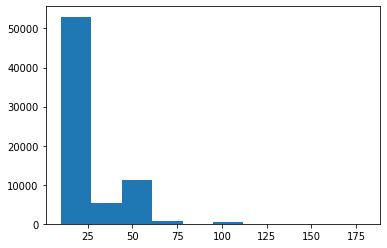

In [123]:
plt.hist( ingresos_per_customer['total'] )
plt.show()

In [124]:
resumen_clv = pd.DataFrame(resumen_clv).T
if run == True:
    resumen_clv.to_csv(PATH_DATA+'resumen_ultimo_anyo.csv')

## Evolución por tipo de productos <a class="anchor" id="9"></a>

[Tabla de Contenidos](#0)

Como se ha realizado anteriormente en este apartado se pretende obtener la evolución de altas, bajas, productos e ingresos para un tipo de producto (ahorros e inversión, financiación y cuentas) para ello se construyen una serie de funciones que devuelven el dataframe con los resultados y la figura para ser mostrada.

Como se observará más adelante los productos en un mismo tipo comparten características y es una buena manera de reducir el número de variables a comparar o a tener en cuenta.

In [125]:
altas_ahorros, altas_financiacion, altas_cuentas = tipos_producto(contrataciones_nuevas, products_dict)
bajas_ahorros, bajas_financiacion, bajas_cuentas = tipos_producto(bajas_sin_cobro+bajas_con_cobro, products_dict)

In [126]:
tipo_producto = 'Ahorros e inversión' # Ahorros e inversión - Financiación - Cuentas
tipo_producto = 'Financiacion'

if tipo_producto == 'Ahorros e inversión':
  tipo_ingresos = ahorros_df.copy(deep=True)
  tipo_productos = prod_ahorros.copy(deep=True)
  tipo_altas = altas_ahorros.copy(deep=True)
  tipo_bajas = bajas_ahorros.copy(deep=True)
elif tipo_producto == 'Financiacion':
  tipo_ingresos = financiacion_df.copy(deep=True)
  tipo_productos = prod_financiacion.copy(deep=True)
  tipo_altas = altas_financiacion.copy(deep=True)
  tipo_bajas = bajas_financiacion.copy(deep=True)
elif tipo_producto == 'Cuentas':
  tipo_ingresos = cuenta_df.copy(deep=True)
  tipo_productos = prod_cuentas.copy(deep=True)
  tipo_altas = altas_cuentas.copy(deep=True)
  tipo_bajas = bajas_cuentas.copy(deep=True)

tipo_ingresos

loans  mortgage  credit_card  debit_card
2018-04-28   0.00      0.00    15,420.00  110,940.00
2018-05-28 240.00    120.00    22,320.00  124,200.00
2018-06-28 180.00     60.00    21,000.00   91,440.00
2018-07-28 180.00     60.00    16,920.00   88,260.00
2018-08-28   0.00     60.00    21,120.00   99,300.00
2018-09-28  60.00     60.00    21,120.00   95,280.00
2018-10-28 120.00      0.00    18,060.00  103,440.00
2018-11-28 120.00      0.00    19,980.00  152,760.00
2018-12-28 120.00      0.00    20,820.00  193,020.00
2019-01-28   0.00      0.00    19,800.00  161,280.00
2019-02-28  60.00      0.00    18,180.00  138,600.00
2019-03-28  60.00     60.00    16,740.00  124,740.00
2019-04-28  60.00      0.00    19,980.00  186,060.00
2019-05-28 180.00      0.00    21,360.00  180,660.00

In [127]:
tipo_ingresos.columns.to_list()

['loans', 'mortgage', 'credit_card', 'debit_card']

In [128]:
ingresos_totales = alta_baja_total(tipo_ingresos,'ingresos')
ingresos_totales
  
fig = go.Figure()
fig.add_trace(go.Scatter(x=ingresos_totales['pk_partition'], y=ingresos_totales['ingresos'], name='Totales'))

for prod in tipo_ingresos.columns:
  ing = tipo_ingresos
  ing = ing[prod]
  fig.add_trace(go.Scatter(x=ingresos_totales['pk_partition'], y=ing, name=prod))
  
fig.update_layout(title= 'Evolución de los Ingresos ({})'.format(tipo_producto),
                   yaxis_title='Ingresos mensuales')

fig.show()

In [129]:
prod_totales = obtener_prod_totales(tipo_productos)
prod_totales
  
fig = go.Figure()
fig.add_trace(go.Scatter(x=prod_totales['pk_partition'], y=prod_totales['productos'], name='Totales'))

for prod in tipo_productos.columns:
  ing = tipo_productos
  ing = ing[prod]
  fig.add_trace(go.Scatter(x=prod_totales['pk_partition'], y=ing, name=prod))
  
fig.update_layout(title= 'Evolución de los productos ({})'.format(tipo_producto),
                   yaxis_title='Productos')

fig.show()

En las gráficas de arriba, se muestran los ingresos y productos existentes en para los productos de financiación, el tipo de producto puede ser cambiado y así se hace en el dashboard. Seguidamente se obtienen las altas y bajas, en el dashboard tan sólo le presentan las bajas y los ingresos, dado que son los cálculos más relevantes. 

In [130]:
def altas_bajas_por_tipo (df):

  totales = alta_baja_total(df, 'ingresos')
  totales = totales.iloc[3:]

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=totales['pk_partition'], y=totales['ingresos'], name='Totales'))

  for prod in df.columns:
    ing = df[3:]
    ing = ing[prod]
    fig.add_trace(go.Scatter(x=totales['pk_partition'], y=ing, name=prod))

  return fig

fig = altas_bajas_por_tipo (tipo_altas) 

fig.update_layout(title= 'Evolución de las altas ({})'.format(tipo_producto),
                   yaxis_title='Altas de productos mensuales')

fig.show()

In [131]:
fig = altas_bajas_por_tipo (tipo_bajas) 

fig.update_layout(title= 'Evolución de las bajas ({})'.format(tipo_producto),
                   yaxis_title='Bajas de productos mensuales')

fig.show()

### Churn Rate <a class="anchor" id="91"></a>

[Tabla de Contenidos](#0)

Una vez obtenidas las bajas y el número de productos contratados, es posible obtener una métrica relevante para el negocio: el Churn Rate. 

El <a href="https://www.inboundcycle.com/blog-de-inbound-marketing/que-es-el-churn-rate-o-tasa-de-cancelacion">Churn Rate</a> o tasa de cancelación de clientes en español es un término empresarial propio de los negocios online que hace referencia a la rotación, migración y cancelación de las suscripciones de los clientes. Por lo tanto, debe establecerse como una forma de determinar la cantidad de personas que están están dejando de ser usuarios en un período de tiempo específico. 

Se define con la formula:

$$churn \; rate = \frac{clientes \; que \; abandonan}{ clientes \; al \; inicio + nuevos \; clientes }$$

Esta métrica suele contabilizarse de manera mensual, es decir clientes que abandonaron, clientes al inicio y nuevos clientes en un mes dado, como también la media de todos los meses.

In [132]:
# Global
try:
    tipo_productos.set_index('pk_partition', inplace=True)
except:
    pass

churn_global = pd.DataFrame(tipo_productos.sum(axis=1))
churn_global.columns = ['productos']
churn_global['old'] = churn_global['productos'].shift(1)

churn_global['altas'] = pd.DataFrame(tipo_altas.sum(axis=1))
churn_global['bajas'] = pd.DataFrame(tipo_bajas.sum(axis=1))
churn_global['churn_rate'] = churn_global['bajas']/(churn_global['old'] + churn_global['altas'])*100
churn_global = churn_global[1:]

churn_global

productos       old    altas    bajas  churn_rate
pk_partition                                                   
2018-02-28        28764 28,055.00 4,218.00     0.00        0.00
2018-03-28        30597 28,764.00 4,799.00 1,567.00        4.67
2018-04-28        31530 30,597.00 4,156.00 3,145.00        9.05
2018-05-28        31753 31,530.00 3,809.00 3,555.00       10.06
2018-06-28        32876 31,753.00 4,440.00 3,256.00        9.00
2018-07-28        33763 32,876.00 4,731.00 4,032.00       10.72
2018-08-28        33460 33,763.00 4,355.00 4,621.00       12.12
2018-09-28        36024 33,460.00 6,039.00 3,445.00        8.72
2018-10-28        38809 36,024.00 7,064.00 4,234.00        9.83
2018-11-28        40029 38,809.00 5,971.00 4,722.00       10.54
2018-12-28        42015 40,029.00 5,819.00 3,805.00        8.30
2019-01-28        41891 42,015.00 5,349.00 5,430.00       11.46
2019-02-28        43990 41,891.00 6,847.00 4,721.00        9.69
2019-03-28        46015 43,990.00 6,324.00 4,263.00        8.47
2019-04-28        46940 46,015.00 5,723.00 4,766.00        9.21
2019-05-28        48115 46,940.00 5,901.00 4,707.00        8.91

In [133]:
print('El Churn Rate medio de {} es del {:3f} %'.format(tipo_producto, churn_global['churn_rate'].mean()))

El Churn Rate medio de Financiacion es del 8.797134 %


In [134]:
# Global (all)
churn_all = tipo_productos.copy(deep=True)
churn_cols = []

for x in churn_all.columns:
  churn_all['old'] = churn_all[x].shift(1)
  churn_all['altas'] = tipo_altas[x]
  churn_all['bajas'] = tipo_bajas[x]
  name = x+'_rate'
  churn_all[name] = churn_all['bajas']/(churn_all['old'] + churn_all['altas'])*100
  churn_cols.append(name)

churn_all = churn_all[3:]
churn_all = churn_all.reset_index()
#churn_global

fig = go.Figure()
for x in churn_cols:
  fig.add_trace(go.Scatter(x=churn_all['pk_partition'], y=churn_all[x], name=x[:-5]))

fig.show()

El Churn Rate calculado anteriormente tiene en cuenta todos los productos en este tipo de producto. Sin embargo, como se ha observa en la gráfica la evolución del churn rate de cada producto es diferente por lo que un churn rate global puede ocultar deficiencias o flaquezas de alguno de los productos.

Enseguida se calcula el churn rate individual de un producto.

In [135]:
# Particular
prod = 'credit_card'
churn_local = tipo_productos[[prod]]
churn_local['old'] = churn_local[prod].shift(1)

churn_local['altas'] = tipo_altas[[prod]]
churn_local['bajas'] = tipo_bajas[[prod]]
churn_local['churn_rate'] = churn_local['bajas']/(churn_local['old'] + churn_local['altas'])*100
churn_local = churn_local[1:]

churn_local = churn_local.reset_index()
churn_local

pk_partition  credit_card      old  altas  bajas  churn_rate
0    2018-02-28         3282 3,325.00 510.00   0.00        0.00
1    2018-03-28         3511 3,282.00 735.00 171.00        4.26
2    2018-04-28         3725 3,511.00 652.00 410.00        9.85
3    2018-05-28         3797 3,725.00 621.00 552.00       12.70
4    2018-06-28         4002 3,797.00 749.00 516.00       11.35
5    2018-07-28         4137 4,002.00 760.00 670.00       14.07
6    2018-08-28         4206 4,137.00 694.00 618.00       12.79
7    2018-09-28         4289 4,206.00 749.00 660.00       13.32
8    2018-10-28         4385 4,289.00 743.00 646.00       12.84
9    2018-11-28         4512 4,385.00 713.00 584.00       11.46
10   2018-12-28         4536 4,512.00 664.00 640.00       12.36
11   2019-01-28         4493 4,536.00 653.00 696.00       13.41
12   2019-02-28         4542 4,493.00 708.00 659.00       12.67
13   2019-03-28         4576 4,542.00 741.00 707.00       13.38
14   2019-04-28         4747 4,576.00 713.00 542.00       10.25
15   2019-05-28         4801 4,747.00 761.00 706.00       12.82

In [136]:
print('El Churn Rate medio de {} es del {:3f} %'.format(prod, churn_local['churn_rate'].mean()))

El Churn Rate medio de credit_card es del 11.095574 %


In [137]:
fig = px.line(churn_local, x='pk_partition', y='churn_rate')
fig.show()

### Ratio de crecimiento <a class="anchor" id="92"></a>

[Tabla de Contenidos](#0)

Dado que se tiene información de 17 históricos desde Enero de 2018 hasta Mayo de 2019. Una métrica sencilla de interpretar y calcular es comparar el estado actual con un año atrás o con el mes anterior. Un crecimiento positivo significará que la empresa está creciendo. Se define el crecimiento como:

$$ratio \_ crecimiento [\%] = \frac{valor_{actual} - valor_{pasado}}{valor_{pasado}}\cdot 100 $$


Como se comenta en <a href="https://www.amazon.es/Lean-Analytics-utilizar-startup-Emprende/dp/8416125244/ref=sr_1_1?adgrpid=59959394361&dchild=1&gclid=CjwKCAjwkN6EBhBNEiwADVfya4xNYFn73QEXn4GhBkveyY4UrvityCVlnaExapqkyOI2O_KajKpsKxoCPbgQAvD_BwE&hvadid=499055720137&hvdev=c&hvlocphy=1005545&hvnetw=g&hvqmt=e&hvrand=5908958132630783138&hvtargid=kwd-296219379062&hydadcr=443_2419024&keywords=lean+analytics&qid=1620549468&sr=8-1">Lean Analytics</a> de Alistar Croll y  Benjamin Yoskovitz, los ratios son idóneos porque son:

- Simples: Es un numéro único.
- Immediatos: Son fáciles de generar.
- Accionable: Puedes cambiar ciertos parámetros durante el día, semana o mes siguiente para cambiarlo. 

In [138]:
ingresos_tabla = ingresos_df.sum(axis=1).reset_index()
ingresos_tabla.columns = ['pk_partition', 'ingresos']

ingresos_tabla['pk_partition'] = pd.to_datetime( ingresos_tabla['pk_partition'] )
ingresos_tabla['month'] = ingresos_tabla['pk_partition'].dt.month
ingresos_tabla['year'] = ingresos_tabla['pk_partition'].dt.year

year_max = ingresos_tabla['year'].max()
month_max = ingresos_tabla[ ingresos_tabla['year'] == year_max ]['month'].max()

ingresos_resumen = pd.DataFrame()


for month in range(1, month_max+1):
  recent = ingresos_tabla[ (ingresos_tabla['year'] == year_max) & (ingresos_tabla['month'] == month) ] ['ingresos']
  old = ingresos_tabla[ (ingresos_tabla['year'] == year_max-1) & (ingresos_tabla['month'] == month) ]['ingresos']
  ingresos_resumen = ingresos_resumen.append( {'recent':recent, 'old':old, 'rate':round( (recent - old) / old * 100 *10)/10}, ignore_index=True )

#ingresos_resumen[1:]

In [139]:
def calcular_rate (df): # index = pk_partition, 1 column with value
    tabla = df.reset_index()
    tabla.columns = ['pk_partition', 'value']
    tabla = tabla[1:]

    tabla['old'] = tabla['value'].shift(1)

    tabla['rate'] = (tabla['value'] - tabla['old'])/tabla['old']*100
    return tabla

In [140]:
ingresos_df['totales'] = ingresos_df.sum(axis=1)
ingresos_tabla = calcular_rate (ingresos_df[['totales']] )

In [141]:
fig = px.area(ingresos_tabla, x="pk_partition", y="rate")

fig.update_layout(title= 'Evolución del crecimiento mensual (Ingresos)',
                   yaxis_title='Crecimiento mensual')

En la gráfica anterior se muestra el crecimiento mensual o variación percentual respecto al mes anterior de los ingresos. El área sombreada por encima del eje X nos indica meses de crecimiento, mientras que por debajo meses donde los ingresos ese mes fueron menores al mes anterior. Cómo se puede obervar desde Julio de 2019 hasta Enero de 2019 la empresa creció y aumentó sus ingresos.

## Información sociodemográfica por tipo de producto <a class="anchor" id="93"></a>

[Tabla de Contenidos](#0)

El objetivo de este apartado es obtener una serie de gráficas que nos ofrezcan un análisis demográfico de los clientes que tienen contratado X producto, con el objetivo de poder comparar productos según el tipo de clientes que lo contratan. 

En este caso el análisis se hará por tipo de producto. El análisis se realizará con la información de todos los clientes que han solicitado alguna vez el producto. 

In [142]:
recent_comm_prod_df = socioproductscommercial [ commercial_products['pk_partition'] == '2019-05-28' ]

In [143]:
prod = 'securities' 
tipo_prod = products_dict[prod]

products = []

for key, val in products_dict.items():
    if val == tipo_prod:
        products.append(key)

products

['short_term_deposit',
 'funds',
 'securities',
 'long_term_deposit',
 'pension_plan']

In [144]:
c1 = (socioproductscommercial [products[0]] == 1) 
c2 = (socioproductscommercial [products[1]] == 1) 
c3 = (socioproductscommercial [products[2]] == 1) 
c4 = (socioproductscommercial [products[3]] == 1) 

if len(products) == 5:
    c5 = (socioproductscommercial [products[4]] == 1) 
else:
    c5 = (socioproductscommercial [products[0]] == 1) 

info_product = socioproductscommercial [ c1 | c2 | c3 | c4 | c5 ]
info_product = info_product.sort_values(['pk_cid','pk_partition'], ascending=False)
info_product = info_product.groupby('pk_cid').last()

info_product

pk_partition country_id  region_code gender  age deceased     salary  \
pk_cid                                                                         
17457     2018-01-28         ES        28.00      H   53        N 102,405.75   
17970     2018-01-28         ES        28.00      V   75        N        NaN   
17980     2018-05-28         ES        28.00      V   77        N 282,461.79   
19684     2018-01-28         ES        46.00      H   54        N  41,390.16   
20315     2018-01-28         ES        28.00      H   52        N        NaN   
...              ...        ...          ...    ...  ...      ...        ...   
1551597   2019-05-28         ES        28.00      H   46        N        NaN   
1551712   2019-05-28         ES        41.00      V   31        N        NaN   
1551832   2019-05-28         ES        28.00      H   50        N        NaN   
1552055   2019-05-28         ES        46.00      H   46        N        NaN   
1552364   2019-05-28         ES         8.00      H   29        N        NaN   

         short_term_deposit  loans  mortgage  ...  pension_plan  \
pk_cid                                        ...                 
17457                     0      0         0  ...          0.00   
17970                     0      0         0  ...          1.00   
17980                     0      0         0  ...          0.00   
19684                     0      0         0  ...          0.00   
20315                     0      0         0  ...          0.00   
...                     ...    ...       ...  ...           ...   
1551597                   0      0         0  ...          1.00   
1551712                   0      0         0  ...          1.00   
1551832                   0      0         0  ...          1.00   
1552055                   0      0         0  ...          1.00   
1552364                   0      0         0  ...          1.00   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  \
pk_cid                                                                       
17457                  0            0           0             0          1   
17970                  1            1           1             0          0   
17980                  0            0           0             0          0   
19684                  0            0           0             0          1   
20315                  0            0           0             0          0   
...                  ...          ...         ...           ...        ...   
1551597                0            0           0             0          1   
1551712                0            0           0             0          1   
1551832                0            0           0             0          1   
1552055                0            0           1             0          1   
1552364                0            0           0             0          1   

         entry_date  entry_channel  active_customer            segment  
pk_cid                                                                  
17457    2017-09-16            KAT             1.00  02 - PARTICULARES  
17970    2015-04-16            KAT             1.00  02 - PARTICULARES  
17980    2018-05-04            KFA             1.00           01 - TOP  
19684    2017-02-24            007             1.00  02 - PARTICULARES  
20315    2015-02-07            KAT             1.00  02 - PARTICULARES  
...             ...            ...              ...                ...  
1551597  2019-05-19           None             1.00               None  
1551712  2019-05-19           None             1.00               None  
1551832  2019-05-20           None             1.00               None  
1552055  2019-05-22           None             1.00               None  
1552364  2019-05-24           None             1.00               None  

[42418 rows x 26 columns]

### Análisis de Salario <a class="anchor" id="94"></a>

[Tabla de Contenidos](#0)

En la siguiente gráfica se presenta la distribución salarial de cada uno de los productos en los productos de financiación. Dado que los salarios no están normalmente distribuidos y su distribución está esparcida (spread), contiene muchos outliers. Por lo que se propone deshacernos de los outliers en la parte superior y quedarnos tan sólo con los clientes en el 95% inferior, es decir no se consideran el 5% superior.

El resultado es una distribución más uniforme donde pueden apreciarse diferencias entre los productos. Por ejemplo, la mediana de salarios de los clientes que contratan pension_plan es menor que la del resto. 


Como se menciona en <a href="https://www.amazon.es/Practical-Statistics-Data-Scientists-Essential/dp/149207294X">Practical Statistics for Data Scientists: 50+ Essential Concepts Using R and Python</a> de Peter Bruce, Andrew Bruce y Peter Gedeck, cuando hablamos de salario, la mediana es el *estimate* más correcto. En el libro, se pone el ejemplo de la localidad de Medina, Washington que tiene la particularidad de que dos personajes muy importantes viven allí, Jeff Bezos y Bill Gates. Si se calcula el salario medio de los habitantes de esta localidad el resultado es de millones, sin embargo la realidad de los habitantes dista mucho de este estimado, es por ello que la mediana es más adecuada y refleja la realidad de sus habitantes. 

In [145]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, subplot_titles=("Salario (con outliers)","Salario (sin outliers)"), vertical_spacing = 0.1)

colours = {0:['lightseagreen','green'], 1:['lightsalmon','salmon'],2:['palevioletred','indianred'], 
  3:['skyblue','steelblue'],4:['orange','orangered'],5:['fuchsia','magenta']}
i = 0

for p in products:
    salary_box = info_product[ info_product[p] == 1 ]['salary'].dropna()
    salary_box_without = salary_box[ salary_box < np.percentile(salary_box, q = 95) ]
    # Use x instead of y argument for horizontal plot
    fig.add_trace(go.Violin(x=salary_box, name=p, legendgroup=p, 
      fillcolor=colours[i][0], line_color= colours[i][1]), row=1, col=1)
    fig.add_trace(go.Violin(x=salary_box_without, name=p, legendgroup=p, showlegend = False,
      box_visible=True, meanline_visible=True, fillcolor=colours[i][0], line_color=colours[i][1]), row=2, col=1)
    i += 1

fig.update_xaxes(title_text="Salario", row=1, col=1)
fig.update_xaxes(title_text="Salario", row=2, col=1)
fig.update_layout(
    legend=dict(
      orientation="h", yanchor="bottom", y=1.04,
      xanchor="center", x=0.5,
      font=dict(family="Courier",size=14,color="black")
    ))

fig.update_layout(height=1200, width=1000)
fig.show()

El código anterior se encapsula en una función para que así pueda ser utilizada en el dashboard. 

In [146]:
def figura_salarios(info_product):
    fig = make_subplots(rows=2, cols=1, subplot_titles=("Salario (con outliers)","Salario (sin outliers)"), vertical_spacing = 0.1)

    colours = {0:['lightseagreen','green'], 1:['lightsalmon','salmon'],2:['palevioletred','indianred'], 
    3:['skyblue','steelblue'],4:['orange','orangered'],5:['fuchsia','magenta']}
    i = 0

    for p in products:
        salary_box = info_product[ info_product[p] == 1 ]['salary'].dropna()
        try:
            salary_box_without = salary_box[ salary_box < np.percentile(salary_box, q = 95) ]
        except:
            salary_box_without = salary_box
        # Use x instead of y argument for horizontal plot
        fig.add_trace(go.Violin(x=salary_box, name=p, legendgroup=p, 
        fillcolor=colours[i][0], line_color= colours[i][1]), row=1, col=1)
        fig.add_trace(go.Violin(x=salary_box_without, name=p, legendgroup=p, showlegend = False,
        box_visible=True, meanline_visible=True, fillcolor=colours[i][0], line_color=colours[i][1]), row=2, col=1)
        i += 1

    fig.update_xaxes(title_text="Salario", row=1, col=1)
    fig.update_xaxes(title_text="Salario", row=2, col=1)
    fig.update_layout(
        legend=dict(
        orientation="h", yanchor="bottom", y=1.04,
        xanchor="center", x=0.5,
        font=dict(family="Courier",size=14,color="black")
        ))

    fig.update_layout(height=1000, width=700)

    return fig

### Análisis de Edad <a class="anchor" id="95"></a>

[Tabla de Contenidos](#0)

Similarmente al punto anterior, en este caso se calcula la distribución de edades de cada producto. Las información de sus distribuciones puede observarse con mayor facilidad por lo que no es necesario deshacerse de outliers. 

In [147]:
fig = go.Figure()

for p in products:
    age_box = info_product[ info_product[p] == 1 ]['age'].dropna()
    
    # Use x instead of y argument for horizontal plot
    fig.add_trace(go.Box(x=age_box, name=p))

fig.update_layout(xaxis_title="Edad",
    legend=dict(
      orientation="h", yanchor="bottom", y=1.02,
      xanchor="center", x=0.5,
      font=dict(family="Courier",size=14,color="black")
    ))
fig.show()

In [148]:
del info_product

El principal inconveniente al mostrar las gráficas de salarios y edades es que se necesita cargar en memoria todos los valores para así poder representar la distribución. En el apartado de *Estructura del Dashboard* se mencionaba que se han creado unas tablas intermedias en SQL de manera que el tratamiento y preprocesado de datos para la visualización de resultados en el dashboard es ínfima. 

Por ende, se decide que estas dos gráficas son generadas en este notebook y guardadas como archivo .png y serán cargadas como imagen en estático en el dashboard. De esta manera, el tiempo de reload o refresh no se ve afectado, aunque se pierden algunas features que ofrece Plotly como es el hover. 

In [149]:
#! conda install -c plotly plotly-orca

In [150]:
#3 tipos de productos
prods = ['securities','em_acount','loans']

for prod in prods:

    tipo_prod = products_dict[prod]

    products = []

    for key, val in products_dict.items():
        if val == tipo_prod:
            products.append(key)
    
    c1 = (socioproductscommercial [products[0]] == 1) 
    c2 = (socioproductscommercial [products[1]] == 1) 
    c3 = (socioproductscommercial [products[2]] == 1) 
    c4 = (socioproductscommercial [products[3]] == 1) 

    if len(products) == 5:
        c5 = (socioproductscommercial [products[4]] == 1) 
    else:
        c5 = (socioproductscommercial [products[0]] == 1) 

    info_product = socioproductscommercial [ c1 | c2 | c3 | c4 | c5 ]
    info_product = info_product.sort_values(['pk_cid','pk_partition'], ascending=False)
    info_product = info_product.groupby('pk_cid').last()

    # Salarios
    fig1 = go.Figure()

    fig1 = figura_salarios(info_product)

    # Edades
    fig2 = go.Figure()

    for p in products:
        age_box = info_product[ info_product[p] == 1 ]['age'].dropna()
        
        # Use x instead of y argument for horizontal plot
        fig2.add_trace(go.Box(x=age_box, name=p))

    fig2.update_layout(xaxis_title="Edad",
        legend=dict(
        orientation="h", yanchor="bottom", y=1.02,
        xanchor="center", x=0.5,
        font=dict(family="Courier",size=14,color="black")
        ))
    
    fig2.update_layout(height=1000, width=700)

    if tipo_prod == 'financiación':
        tipo_prod = 'financiacion'
    if tipo_prod == 'ahorro e inversión':
        tipo_prod = 'ahorro'
    if tipo_prod == 'cuentas':
        tipo_prod = 'cuenta'

    #fig1.write_image(PATH_DATA + tipo_prod + "_salarios.png")  
    #fig2.write_image(PATH_DATA + tipo_prod + "_edades.png")    

## Análisis demográfico <a class="anchor" id="10"></a>

[Tabla de Contenidos](#0)

En esta sección se realiza un estudio demográfico de los clientes. Dado que la mayoría de clientes son de España se decide dividir los clientes en españoles y no españoles (extranjero). 

### Regiones en España <a class="anchor" id="101"></a>

[Tabla de Contenidos](#0)

Para los clientes de España, hay un campo llamado región que indica la provincia de cada uno de ellos. Por lo que se puede diferenciar y clasificar con más detalle.

In [151]:
info_product_ = socioproductscommercial [ (socioproductscommercial [prod] == 1) ]
info_product_ = info_product_.sort_values(['pk_cid','pk_partition'], ascending=False)
info_product_ = info_product_.groupby('pk_cid').last()

info_product_.head()

pk_partition country_id  region_code gender  age deceased     salary  \
pk_cid                                                                         
808433    2018-05-28         ES        41.00      V   54        N  41,001.57   
1008258   2018-05-28         ES        28.00      V   36        N 219,673.74   
1020462   2018-01-28         ES        38.00      H   35        N 105,267.30   
1022123   2018-01-28         ES        23.00      V   27        N  54,038.43   
1030004   2018-01-28         ES        27.00      V   38        N  60,530.88   

         short_term_deposit  loans  mortgage  ...  pension_plan  \
pk_cid                                        ...                 
808433                    0      1         0  ...          1.00   
1008258                   0      1         0  ...          0.00   
1020462                   0      1         0  ...          0.00   
1022123                   0      1         0  ...          1.00   
1030004                   0      1         0  ...          1.00   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  \
pk_cid                                                                       
808433                 1            0           1             0          0   
1008258                0            0           0             0          0   
1020462                0            0           0             0          0   
1022123                1            0           1             0          0   
1030004                1            1           1             0          0   

         entry_date  entry_channel  active_customer             segment  
pk_cid                                                                   
808433   2016-05-21            KAT             1.00   02 - PARTICULARES  
1008258  2016-11-08            KAT             1.00   02 - PARTICULARES  
1020462  2016-10-14            KFC             1.00   02 - PARTICULARES  
1022123  2015-07-05            KHE             1.00  03 - UNIVERSITARIO  
1030004  2015-07-24            KFC             1.00   02 - PARTICULARES  

[5 rows x 26 columns]

In [152]:
spain = pd.DataFrame(spanish_regions_code).T.reset_index()
spain.columns = ['index','Ciudad','Com.Autonoma']
spain.head()

index            Ciudad        Com.Autonoma
0      1           Elciego          País Vasco
1      2          Albacete  Castilla-La Mancha
2      3  Alicante/Alacant     Com. Valenciana
3      4           Almería           Andalucía
4      5             Ávila     Castilla y León

In [153]:
spain_result = pd.DataFrame(info_product_.groupby('region_code')['pk_partition'].count().sort_values(ascending=False).head(10))
spain_result.reset_index(inplace=True)
spain_result = pd.merge(spain_result, spain, left_on='region_code', right_on='index', how='left')

spain_result 
#result = pd.DataFrame(info_product_.groupby('country_id')['pk_partition'].count().sort_values(ascending=False).head(10))
#result.reset_index(inplace=True)

region_code  pk_partition  index                        Ciudad  \
0        28.00            14     28                        Madrid   
1         8.00             6      8                     Barcelona   
2        46.00             3     46                      Valencia   
3        30.00             2     30                        Murcia   
4        35.00             2     35  Palmas de Gran Canaria (Las)   
5        41.00             2     41                       Sevilla   
6        29.00             2     29                        Málaga   
7        25.00             1     25                        Lleida   
8        27.00             1     27                          Lugo   
9        11.00             1     11                         Cádiz   

      Com.Autonoma  
0           Madrid  
1         Cataluña  
2  Com. Valenciana  
3           Murcia  
4   Islas Canarias  
5        Andalucía  
6        Andalucía  
7         Cataluña  
8          Galicia  
9        Andalucía

In [154]:
fig = px.bar(spain_result, x='Ciudad', y='pk_partition')
fig.show()

In [155]:
info_clients_ = socioproductscommercial.sort_values(['pk_cid','pk_partition'], ascending=False)
info_clients_ = info_clients_.groupby('pk_cid').last()

spain = pd.DataFrame(spanish_regions_code).T.reset_index()
spain.columns = ['index','Ciudad','Com.Autonoma']

spain_result = pd.DataFrame(info_clients_.groupby('region_code')['pk_partition'].count().sort_values(ascending=False))
spain_result.reset_index(inplace=True)
spain_result = pd.merge(spain_result, spain, left_on='region_code', right_on='index', how='left')

spain_result.head(20)

region_code  pk_partition  index                        Ciudad  \
0         28.00         98180     28                        Madrid   
1          8.00         46089      8                     Barcelona   
2         46.00         27716     46                      Valencia   
3         30.00         21765     30                        Murcia   
4         41.00         21313     41                       Sevilla   
5         15.00         18136     15                    Coruña (A)   
6         29.00         13600     29                        Málaga   
7          3.00         13478      3              Alicante/Alacant   
8         36.00         12682     36                    Pontevedra   
9         11.00         11752     11                         Cádiz   
10        33.00         10138     33                        Oviedo   
11        50.00          9947     50                      Zaragoza   
12        35.00          9490     35  Palmas de Gran Canaria (Las)   
13         6.00          8771      6                       Badajoz   
14        47.00          8398     47                    Valladolid   
15        45.00          7803     45                        Toledo   
16        18.00          7723     18                       Granada   
17        37.00          6595     37                     Salamanca   
18        10.00          5836     10                       Cáceres   
19        14.00          5671     14                       Córdoba   

          Com.Autonoma  
0               Madrid  
1             Cataluña  
2      Com. Valenciana  
3               Murcia  
4            Andalucía  
5              Galicia  
6            Andalucía  
7      Com. Valenciana  
8              Galicia  
9            Andalucía  
10  Princ. de Asturias  
11              Aragón  
12      Islas Canarias  
13         Extremadura  
14     Castilla y León  
15  Castilla-La Mancha  
16           Andalucía  
17     Castilla y León  
18         Extremadura  
19           Andalucía

In [156]:
spain_result.columns = ['region_code','number_clients','indice','ciudad','com_autonoma']

# corregimos madrid = Comunidad de Madrid 
correccion = {'Madrid':'Com. de Madrid'}
spain_result['com_autonoma'] = spain_result['com_autonoma'].replace(correccion)

if run == True:
    spain_result.to_csv(PATH_DATA+'espana.csv')

El gráfico de barras está bien para visualizar la información, pero para no saturar el dashboard con tantos gráficos de barras se propone utilizar un tree map para así ofrecer más variedad y diversidad en los gráficos. Las provincias son además agrupadas por Comunidad Autónoma.

In [157]:
#https://plotly.com/python/treemaps/

fig = px.treemap(spain_result, path=['com_autonoma', 'ciudad'], values='number_clients',
                  color='number_clients', 
                  color_continuous_scale='RdBu')
fig.show()

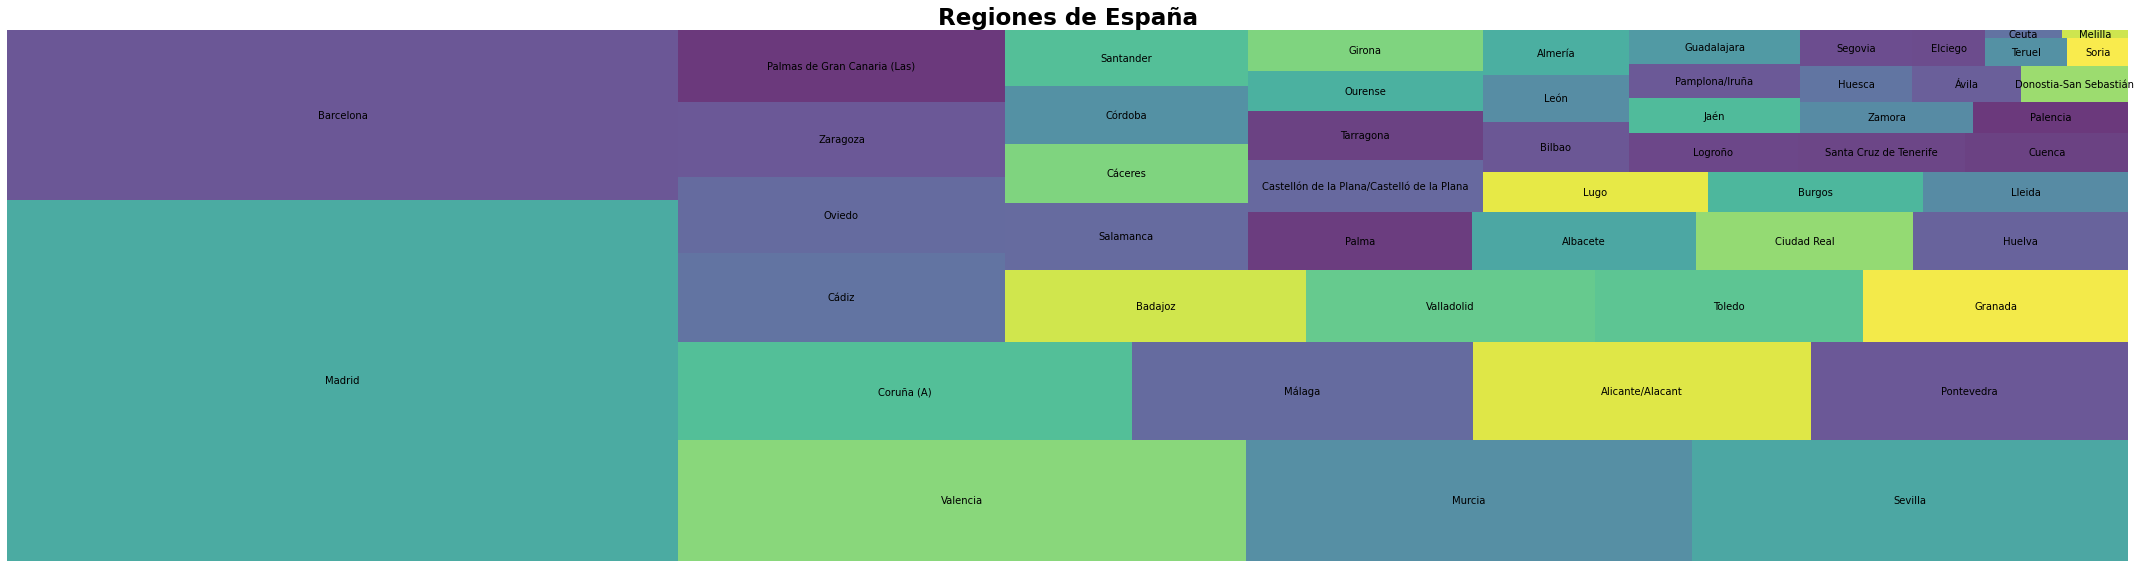

In [158]:
my_values = spain_result['number_clients'] 
labels = spain_result['ciudad']

plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Regiones de España",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()

### Países fuera de España <a class="anchor" id="102"></a>

[Tabla de Contenidos](#0)

En este caso se representan los clientes de fuera de España. Primero se obtiene un gráfico de barras y seguidamente se realiza un treemap agrupando por Continente (o por sub continente dividiendo América en Norte y Sur).

In [159]:
abroad_result = pd.DataFrame(info_clients_.groupby('country_id')['pk_partition'].count().sort_values(ascending=False))
abroad_result.reset_index(inplace=True)
abroad_result = abroad_result[ abroad_result['country_id'] != 'ES']

country_match = {}
continent_match = {}
for key, value in paises_code.items():
  country_match[key] = value[1]
  continent_match[key] = value[0]

abroad_result['Pais'] = abroad_result['country_id'].replace(country_match)
abroad_result['Continente'] = abroad_result['country_id'].replace(continent_match)
abroad_result['Continente'] = abroad_result['Continente'].replace(continente)

abroad_result

country_id  pk_partition                Pais     Continente
1          GB            31      United Kingdom         Europa
2          FR            16              France         Europa
3          US            13                  US  Norte América
4          CH            13         Switzerland         Europa
5          DE            12             Germany         Europa
6          BE             6             Belgium         Europa
7          VE             5           Venezuela    Sur América
8          BR             5              Brazil    Sur América
9          MX             4              Mexico    Sur América
10         IE             4             Ireland         Europa
11         AR             4           Argentina    Sur América
12         AT             3             Austria         Europa
13         IT             3               Italy         Europa
14         PL             3              Poland         Europa
15         MA             2             Morocco         África
16         CA             2              Canada  Norte América
17         CN             2               China           Asia
18         SE             2              Sweden         Europa
19         CL             2               Chile    Sur América
20         CI             1       Cote d'Ivoire         África
21         SN             1             Senegal         África
22         SA             1        Saudi Arabia           Asia
23         RU             1              Russia         Europa
24         QA             1               Qatar           Asia
25         PT             1            Portugal         Europa
26         NO             1              Norway         Europa
27         DJ             1            Djibouti         África
28         MR             1          Mautirania         África
29         DO             1  Dominican Republic    Sur América
30         LU             1          Luxembourg         Europa
31         JM             1             Jamaica    Sur América
32         HU             1             Hungary         Europa
33         CM             1            Cameroon         África
34         GA             1              Gambia         África
35         ET             1            Ethiopia         África
36         CO             1            Colombia    Sur América
37         GT             1           Guatemala    Sur América

In [160]:
abroad_result.columns = ['country_id','number_clients','pais','continente']
if run == True:
    abroad_result.to_csv(PATH_DATA+'extranjero.csv')

In [161]:
fig = px.bar(abroad_result, x='pais', y='number_clients')
fig.show()

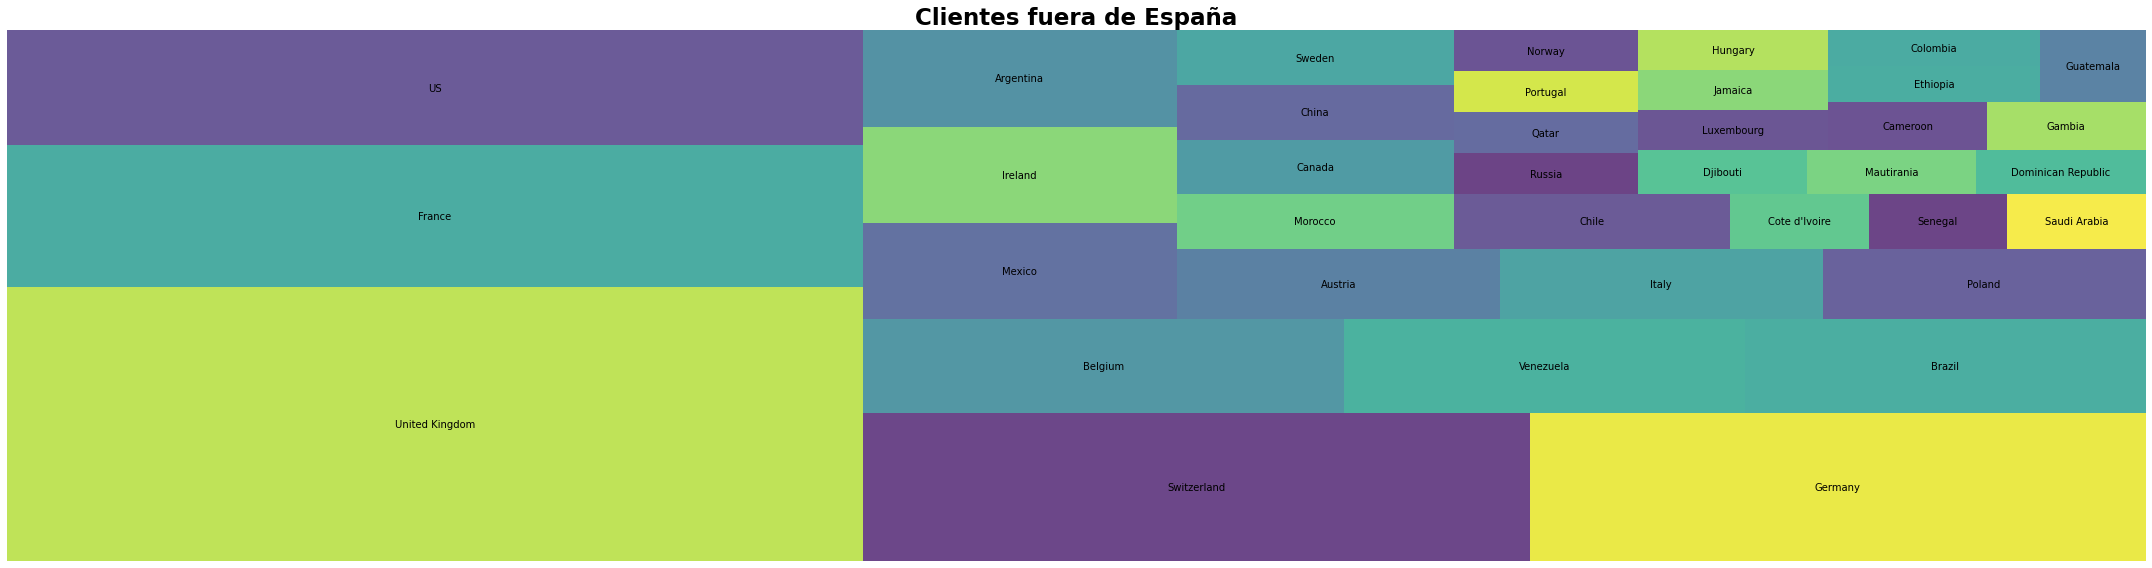

In [162]:
my_values = abroad_result['number_clients'] 
labels = abroad_result['pais']

plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Clientes fuera de España",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()

In [163]:
fig = px.treemap(abroad_result, path=['continente', 'pais'], values='number_clients',
                  color='number_clients', 
                  color_continuous_scale='RdBu')
fig.show()

## Análisis por canal de entrada <a class="anchor" id="11"></a>

[Tabla de Contenidos](#0)

En este apartado se realiza un estudio similar al anterior donde se estudia el canal de entrada de los clientes. Se opta por visualizar esta información en pie chart, aunque también se presenta un gráfico de barras y un tree map.

In [164]:
channel_result = pd.DataFrame(info_clients_.groupby('entry_channel')['pk_partition'].count().sort_values(ascending=False))
channel_result.reset_index(inplace=True)

fig = px.bar(channel_result.head(10) , x='entry_channel', y='pk_partition')
fig.show()

In [165]:
top_channels = channel_result['entry_channel'].head(9).to_list()

channel_result['entry_channel'] = np.where(~channel_result['entry_channel'].isin(top_channels), 'Others',channel_result['entry_channel'])
channel_result = channel_result.groupby('entry_channel').sum()
channel_result.reset_index(inplace=True)

In [166]:
channel_result.columns = ['entry_channel','number_clients']
if run == True:
    channel_result.to_csv(PATH_DATA+'entry_channel.csv')

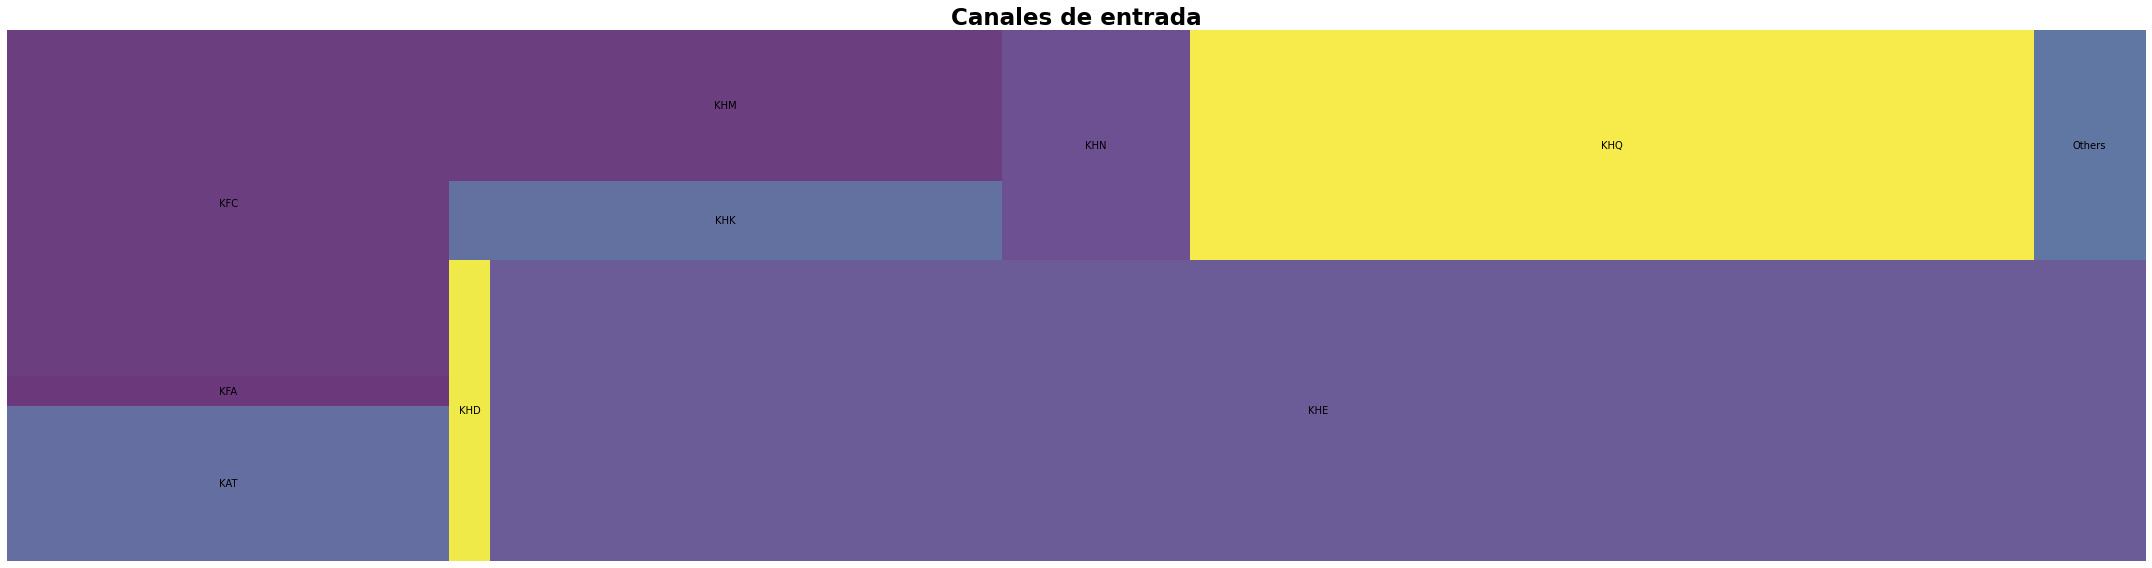

In [167]:
my_values = channel_result['number_clients'].head(15)
labels = channel_result['entry_channel'].head(15)

plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Canales de entrada",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()

In [168]:
import plotly.express as px
fig = px.pie(channel_result, values='number_clients', names='entry_channel')
fig.show()

In [169]:
product_information = pd.DataFrame( )
add = pd.DataFrame( range(10) )

for prod in list_products:
    info_product_ = socioproductscommercial [ (socioproductscommercial [prod] == 1) ]
    info_product_ = info_product_.sort_values(['pk_cid','pk_partition'], ascending=False)
    info_product_ = info_product_.groupby('pk_cid').last()

    # Espana
    spain = pd.DataFrame(spanish_regions_code).T.reset_index()
    spain.columns = ['index','Ciudad','Com.Autonoma']

    spain_result = pd.DataFrame(info_product_.groupby('region_code')['pk_partition'].count().sort_values(ascending=False).head(10))
    spain_result.reset_index(inplace=True)
    spain_result = pd.merge(spain_result, spain, left_on='region_code', right_on='index', how='left')

    add['producto'] = prod
    add['ciudad'] = spain_result['Ciudad']
    add['ciudad_num'] = spain_result['pk_partition']

    # Extranjero
    abroad_result = pd.DataFrame(info_product_.groupby('country_id')['pk_partition'].count().sort_values(ascending=False).head(11))
    abroad_result.reset_index(inplace=True)
    abroad_result = abroad_result[ abroad_result['country_id'] != 'ES']

    country_match = {}
    for key, value in paises_code.items():
        country_match[key] = value[1]

    abroad_result['Pais'] = abroad_result['country_id'].replace(country_match)

    add['pais'] = abroad_result['Pais']
    add['pais_num'] = abroad_result['pk_partition']

    # Channel
    channel_result = pd.DataFrame(info_product_.groupby('entry_channel')['pk_partition'].count().sort_values(ascending=False).head(10))
    channel_result.reset_index(inplace=True)

    add['entry_channel'] = channel_result['entry_channel']
    add['entry_channel_num'] = channel_result['pk_partition']

    product_information = pd.concat( [product_information, add], ignore_index=True )

product_information.drop(0, axis=1, inplace=True)


In [170]:
if run == True:
    product_information.to_csv(PATH_DATA+'informacion_productos.csv')

## Estudio de la permanencia <a class="anchor" id="12"></a>

[Tabla de Contenidos](#0)

El objetivo de este apartado es obtener la permanencia en meses de los clientes que han contratado cierto producto. Para ello se trabaja con el dataset de productos y se crea una función *obtener_permanencia* que permite obtener la permanencia de cada producto. 

Posteriormente se guardan los resultados en un diccionario, y se grafica este diccionario ya sea con los meses de manera individual o agrupándolos en grupos de varios meses (para así tener una mejor imagen de cómo se distribuye la permanencia de ese producto y poder resolver la pregunta de cuánta gente cumple la permanencia). 

In [171]:
def obtener_permanencia (products_sorted, prod, first_partition, last_partition):
    prev = 'prev'
    diff = 'diff'
    prev_date = 'prev_date'

    prod_df = products_sorted[['pk_cid','pk_partition',prod]]

    prod_df[prev] = prod_df.groupby('pk_cid')[prod].shift(1) # columna con valor del mes anterior 
    prod_df.loc[:,diff] = prod_df[prod] - prod_df[prev] # +1: alta, 0: no cambio, -1: baja

    prod_df.fillna(-2, inplace=True)

    # Consideramos el primer mes como origen
    prod_df[diff] = np.where( (prod_df[prev] == -2) & (prod_df[prod] == 1) , 1, prod_df[diff] )

    # Nos quedamos con casos: 1 y -1.
    prod_df = prod_df[ (prod_df[diff] == 1) | (prod_df[diff] == -1) ]

    prod_df.loc[:,prev_date] = prod_df.groupby('pk_cid')['pk_partition'].shift(1)

    prod_df = prod_df[ prod_df[diff] == -1 ]

    prod_df['perm'] = round((prod_df['pk_partition'] - prod_df[prev_date])/np.timedelta64(1, 'M')) # diferencia en meses

    permanencia = vc_to_dict(prod_df, 'perm', 16) # pasamos el resultado a diccionario

    return permanencia


def vc_to_dict(prod_df, col, imax):
    dicc = {}
    result = prod_df[col].value_counts().sort_index()

    for i in range(1,imax+1):
        if i in result.index:
            dicc[i] = result[i] 
        else:
            dicc[i] = 0   
            
    return dicc


def dicc_mean(dicc):
    accu = 0
    count = 0
    for x in dicc:
        accu += x*dicc[x]
        count += dicc[x]
    
    return accu/count

In [172]:
import warnings
warnings.filterwarnings("ignore")

first_partition = '2018-01-28'
last_partition = '2019-05-28'

products = pd.read_csv(PATH_DATA+'products_df.csv', encoding='utf-8')
products.drop(columns=['Unnamed: 0'], inplace=True)

products_sorted = products.sort_values(by=['pk_cid', 'pk_partition'])
products_sorted['pk_partition'] = pd.to_datetime(products_sorted['pk_partition'])

list_products = ["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "pension_plan", "emc_account", "debit_card", "em_account_p", "em_acount"]

permanencias = {}

for prod in list_products:
    permanencia = obtener_permanencia (products_sorted, prod, first_partition, last_partition)
    permanencias[prod] = permanencia

permanencias_df = pd.DataFrame(permanencias)
permanencias_df 

short_term_deposit  loans  mortgage  funds  securities  long_term_deposit  \
1                  235      0         0     52         128                189   
2                  362      0         0     45         107                268   
3                 4664      2         1     37          60                132   
4                   57      1         0     30          24                124   
5                    1      0         0     24          31                162   
6                    9      1         0     39          17                246   
7                    0      2         0     20          15                223   
8                    0      2         0     15          11                256   
9                    4      0         1     19          15                280   
10                   0      0         0     22           8                289   
11                   2      1         0     21           8                153   
12                   4      2         0     19           7                269   
13                   1      0         0     25           8                589   
14                   0      2         0     10           4                 81   
15                   0      1         0      7           5                 61   
16                   0      0         0      4           7                 66   

    em_account_pp  credit_card  payroll_account  pension_plan  emc_account  \
1               0         3910             1561         10830         1197   
2               0         2348              840          5609          702   
3               0         1014              636          3216          530   
4               0          602              527          2208          360   
5               0          440             2273          1419          296   
6               0          312              415          1315          293   
7               0          249              453          1541          260   
8               0          180              387           629          233   
9               0          124              310           447          204   
10              0          108              277           422          183   
11              0          101             1255           372          185   
12              0           80              106           507          148   
13              0           59              123           246          132   
14              0           72               82           203          113   
15              0           47               67           110           79   
16              0           43               63            79           86   

    debit_card  em_account_p  em_acount  
1        31121             0      13378  
2         8258             0       7182  
3         4302             0       4725  
4         2479             0       3937  
5         1967             0       3194  
6         1664             0       3117  
7         1475             0       2665  
8          804             0       2137  
9          697             0       1877  
10         653             0       1907  
11         455             0       1550  
12         479             0       1219  
13         449             0       1135  
14         263             0       1058  
15         261             0        909  
16         197             0        929

In [173]:
if run == True:
    permanencias_df.to_csv(PATH_DATA+'permanencias.csv')

In [174]:
prod = 'payroll_account'
perm = obtener_permanencia (products_sorted, prod, first_partition, last_partition)

mean = dicc_mean(perm)
print('La permanencia media de {} es {} meses'.format(prod, mean))

perm = pd.DataFrame(perm, index=['mes']).T
perm = perm.reset_index()

fig = px.bar(perm, x="index", y="mes", title="Permanencia de los clientes para "+prod)
fig.update_layout(
    xaxis = dict(tickmode = 'linear', dtick = 1),
    yaxis_title='Número de clientes',
    xaxis_title='Número de meses'
)
fig.show()

La permanencia media de payroll_account es 5.62944 meses


In [175]:
def cambiar_duraciones(vector, duraciones):
    new_vector = {}
    for x in duraciones:
        #print(duraciones[x][0])
        for i in range( duraciones[x][0], duraciones[x][1]+1 ):
            #print(i)
            if i in vector:
                if x in new_vector:
                    new_vector[x] += vector[i]
                else:
                    new_vector[x] = vector[i]
    
    return new_vector

In [176]:
prod = 'payroll_account'
perm = obtener_permanencia (products_sorted, prod, first_partition, last_partition)

duraciones = {'1-2 meses':[1,2], '3-6 meses':[3,6], '7-12 meses':[7,12], 'Más de 12 meses':[13,20]}

new_perm = cambiar_duraciones(perm, duraciones)
new_perm = pd.DataFrame(new_perm, index=['mes']).T
new_perm = new_perm.reset_index()

fig = px.bar(new_perm, x="index", y="mes", title="Permanencia de los clientes para "+prod)
fig.update_layout(
  yaxis_title='Número de clientes',
  xaxis_title=''
)
fig.show()

## Estudio de la antigüedad de los clientes <a class="anchor" id="13"></a>

[Tabla de Contenidos](#0)

Similarmente al apartado anterior, en este caso se estudia la antigüedad de los clientes que tienen contratado actualmente el producto a consultar. Al igual que en permanencia, se agrupan los valores en meses para así obtener una imagen más global de la antigüedad de la cartera de clientes. 

In [177]:
prod = 'em_acount'
prev = 'prev'
diff = 'diff'
prev_date = 'prev_date'

prod_df = products_sorted[['pk_cid','pk_partition',prod]]
prod_df[prev] = prod_df.groupby('pk_cid')[prod].shift(1)
prod_df.loc[:,diff] = 0

prod_df.fillna(-2, inplace=True)

prod_df[diff] = np.where( (prod_df[prev] == -2) & (prod_df[prod] == 1) , 1, prod_df[diff] )

prod_df[diff] = np.where( (prod_df[prod] == 1) & (prod_df['pk_partition'] == last_partition), -1, prod_df[diff] )

prod_df = prod_df[ (prod_df[diff] == -1) | (prod_df[diff] == 1) ]
prod_df.loc[:,prev_date] = prod_df.groupby('pk_cid')['pk_partition'].shift(1)

prod_df = prod_df[ (prod_df['pk_partition'] == last_partition) ]
prod_df['perm'] = round((prod_df['pk_partition'] - prod_df[prev_date])/np.timedelta64(1, 'M'))

prod_df.head(20)

pk_cid pk_partition  em_acount  prev  diff  prev_date  perm
5523396   16203   2019-05-28          1  1.00    -1        NaT   NaN
5523395   16502   2019-05-28          1  1.00    -1        NaT   NaN
5523398   17457   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523390   17799   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523394   18704   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523393   19268   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523407   19684   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523410   20333   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523400   21551   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523399   21719   2019-05-28          1  1.00    -1        NaT   NaN
5523403   22212   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523402   22635   2019-05-28          1  1.00    -1 2019-02-28  3.00
5523401   22648   2019-05-28          1  1.00    -1 2018-05-28 12.00
5523378   24415   2019-05-28          1  1.00    -1 2019-01-28  4.00
5523377   24763   2019-05-28          1  1.00    -1        NaT   NaN
5523369   25036   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523368   25054   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523370   25398   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523373   26018   2019-05-28          1  1.00    -1 2018-01-28 16.00
5523372   26163   2019-05-28          1  1.00    -1 2018-01-28 16.00

In [178]:
def obtener_antiguedad (products_sorted, prod, first_partition, last_partition):
    prev = 'prev'
    diff = 'diff'
    prev_date = 'prev_date'

    prod_df = products_sorted[['pk_cid','pk_partition',prod]]
    prod_df[prev] = prod_df.groupby('pk_cid')[prod].shift(1)
    prod_df.loc[:,diff] = 0

    prod_df.fillna(-2, inplace=True)

    prod_df[diff] = np.where( (prod_df[prev] == -2) & (prod_df[prod] == 1) , 1, prod_df[diff] )

    prod_df[diff] = np.where( (prod_df[prod] == 1) & (prod_df['pk_partition'] == last_partition), -1, prod_df[diff] )

    prod_df = prod_df[ (prod_df[diff] == -1) | (prod_df[diff] == 1) ]
    prod_df.loc[:,prev_date] = prod_df.groupby('pk_cid')['pk_partition'].shift(1)

    prod_df = prod_df[ (prod_df['pk_partition'] == last_partition) ]
    prod_df['perm'] = round((prod_df['pk_partition'] - prod_df[prev_date])/np.timedelta64(1, 'M'))

    antiguedad = vc_to_dict(prod_df, 'perm', 16)

    return antiguedad

In [179]:
antiguedades = {}

for prod in list_products:
    
    antiguedad = obtener_antiguedad (products_sorted, prod, first_partition, last_partition)
    antiguedades[prod] = antiguedad

antiguedades_df = pd.DataFrame(antiguedades)
antiguedades_df 

short_term_deposit  loans  mortgage  funds  securities  long_term_deposit  \
1                    0      0         0      1           3                  1   
2                    0      1         0      0           2                  3   
3                    0      0         0      0           5                 23   
4                    0      0         0      2           4                 20   
5                    0      0         0      1           4                 66   
6                    0      0         0      2           2                 53   
7                    0      0         0      1           3                 63   
8                    0      0         0      2           2                 52   
9                    0      0         0      0           2                 33   
10                   0      0         0      1           5                 72   
11                   0      0         0      1           6                 68   
12                   0      0         0      6           5                 55   
13                   0      1         0      3           3                 22   
14                   0      0         0      3           0                 16   
15                   0      0         0      1           1                  9   
16                   2     10        13    606         805               2447   

    em_account_pp  credit_card  payroll_account  pension_plan  emc_account  \
1               0            7               38            38           16   
2               0            5               27            26            7   
3               0            0               44            33           12   
4               0            2               53            35            9   
5               0            1              139            42            9   
6               0            2               84            42            6   
7               0            1               39            38           10   
8               0            2               35            35            9   
9               0            1               24            24            6   
10              0            8               45            46           10   
11              0           11               41            35            5   
12              0            5               32            22            9   
13              0            7               45            34           14   
14              0           15               35            49           12   
15              0            9               34            31            9   
16              0         2205            10255          5753        13774   

    debit_card  em_account_p  em_acount  
1           51             0       1432  
2           68             0       1942  
3           75             0       1990  
4           63             0       2783  
5           63             0       2278  
6           59             0       7137  
7           70             0      14362  
8           73             0      14153  
9           57             0       9517  
10          84             0      10563  
11          56             0       1650  
12          62             0       1760  
13          68             0       1769  
14          83             0       2024  
15          64             0       2147  
16       18519             2     198312

In [180]:
if run == True:
    antiguedades_df.to_csv(PATH_DATA+'antiguedades.csv')

In [181]:
prod = 'securities'
antig = obtener_antiguedad (products_sorted, prod, first_partition, last_partition)

mean = dicc_mean(antig)
print('La antigüedad media de {} es {} meses'.format(prod, mean))

antig = pd.DataFrame(antig, index=['mes']).T
antig = antig.reset_index()

fig = px.bar(antig, x="index", y="mes", title="Antigüedad de los clientes para "+prod)
fig.update_layout(
    xaxis = dict(tickmode = 'linear', dtick = 1),
    yaxis_title='Número de clientes',
    xaxis_title='Número de meses'
)
fig.show()

La antigüedad media de securities es 15.534037558685446 meses


In [182]:
prod = 'securities'
antig = obtener_antiguedad (products_sorted, prod, first_partition, last_partition)

duraciones = {'1-2 meses':[1,2], '3-6 meses':[3,6], '7-12 meses':[7,12], 'Más de 12 meses':[13,20]}

new_antig = cambiar_duraciones(antig, duraciones)
new_antig = pd.DataFrame(new_antig, index=['mes']).T
new_antig = new_antig.reset_index()

fig = px.bar(new_antig, x="index", y="mes", title="Antigüedad de los clientes para "+prod)
fig.update_layout(
  yaxis_title='Número de clientes',
  xaxis_title=''
)
fig.show()

In [183]:
new_antig

index  mes
0        1-2 meses    5
1        3-6 meses   15
2       7-12 meses   23
3  Más de 12 meses  809

## Combinaciones de productos <a class="anchor" id="14"></a>

[Tabla de Contenidos](#0)

En este último apartado se obtienen las combinaciones de productos más comunes. Para los clientes con cierto producto se observa que otros productos también son contratados por estos mismos. Esta información se presenta en una tabla que se incluye en el dashboard. 

Donde las 2 primeras columnas hacen referencia al producto en cuestión o producto de referencia y el producto complementario. Los totales indican el número de clientes que han solicitado ambos productos, el total de clientes con el producto 1 y con el producto 2; y la última columna corresponde al % de clientes que teniendo contratado el producto 1 también tienen contratado el producto 2. 

In [184]:
most_popular_products = products_df[["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "payroll", "pension_plan"]].sum(axis=0)

most_popular_products = pd.DataFrame(most_popular_products.sort_values()).reset_index()
most_popular_products.columns = ['product','units']

most_popular_products
fig = px.bar(most_popular_products, x="product", y="units", title="Wide-Form Input")
fig.show()

0.00    1121507
1.00    3996751
2.00     587717
3.00     177489
4.00      57927
5.00      17584
6.00       3258
7.00        625
8.00         66
dtype: int64

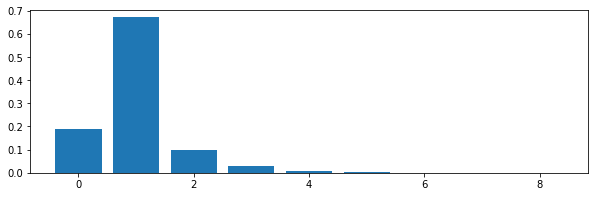

In [185]:
products_by_customer = products_df[ list_products ].sum(axis=1).value_counts().sort_index()

display(products_by_customer)

products_by_customer = products_df[ list_products ].sum(axis=1).value_counts(normalize=True).sort_index()
fig, ax = plt.subplots(figsize=[10,3])
ax.bar(products_by_customer.index, products_by_customer[:])
plt.show()

In [186]:
x = 1
list_products

vector = np.arange(len(list_products))
comb_2 = []

for y in vector[vector > x]:
  comb_2.append([x,y])

comb_2

[[1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 9],
 [1, 10],
 [1, 11],
 [1, 12],
 [1, 13]]

In [187]:
two_pack = pd.DataFrame(columns=['producto_1','producto_2','total','total_1','total_2'])
for x, y in comb_2:
    col_x = list_products[x]
    col_y = list_products[y]
    df_x = products_df.loc[ (products_df[ col_x ] == True) ]
    df_y = products_df.loc[ (products_df[ col_y ] == True) ]
    df = products_df.loc[ (products_df[ col_x ] == True) & (products_df[ col_y ] == True) ]
    if df.shape[0] != 0:
       # pd.concat([pd.DataFrame([i], columns=['A']) for i in range(5)],
       #   ignore_index=True)
        df_ = pd.DataFrame( {'producto_1':col_x, 'producto_2':col_y, 'total':df.shape[0], 'total_1': df_x.shape[0] ,'total_2': df_y.shape[0] }, index=[0] )
        two_pack = pd.concat( [two_pack, df_], ignore_index=True) 

two_pack['prop_1'] = two_pack['total'] / two_pack['total_1'] * 100
#two_pack['prop_2'] = two_pack['total'] / two_pack['total_2'] * 100

display(two_pack.sort_values('prop_1', ascending=False))

producto_1         producto_2 total total_1  total_2 prop_1
6      loans         debit_card   363     468   562968  77.56
3      loans    payroll_account   220     468   329420  47.01
2      loans        credit_card   212     468    70866   45.3
7      loans          em_acount   209     468  4381602  44.66
4      loans       pension_plan   188     468   217802  40.17
5      loans        emc_account   117     468   326961   25.0
1      loans  long_term_deposit    21     468   100660   4.49
0      loans              funds     4     468    20099   0.85

In [188]:
x_ = "loans"

x = list_products.index(x_)
x

1

In [189]:
def two_combination(product, products_df):
  
    list_products = ["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "pension_plan", "emc_account", "debit_card", "em_account_p", "em_acount"]
    x = boolean_cols.index(product)
    vector = np.arange(len(boolean_cols))
    comb_2 = []

    for y in vector[vector > x]:
        comb_2.append([x,y])

    two_pack = pd.DataFrame(columns=['producto_1','producto_2','total','total_1','total_2'])
    for x, y in comb_2:
        col_x = boolean_cols[x]
        col_y = boolean_cols[y]
        df_x = products_df.loc[ (products_df[ col_x ] == True) ]
        df_y = products_df.loc[ (products_df[ col_y ] == True) ]
        df = products_df.loc[ (products_df[ col_x ] == True) & (products_df[ col_y ] == True) ]
        if df.shape[0] != 0:
        # pd.concat([pd.DataFrame([i], columns=['A']) for i in range(5)],
        #   ignore_index=True)
            df_ = pd.DataFrame( {'producto_1':col_x, 'producto_2':col_y, 'total':df.shape[0], 'total_1': df_x.shape[0] ,'total_2': df_y.shape[0] }, index=[0] )
            two_pack = pd.concat( [two_pack, df_], ignore_index=True) 

    two_pack['prop_1'] = two_pack['total'] / two_pack['total_1'] * 100
    #two_pack['prop_2'] = two_pack['total'] / two_pack['total_2'] * 100
    two_pack.sort_values('prop_1', ascending=False, inplace=True)

    return two_pack

two_pack = two_combination("mortgage", products_df)

In [190]:
boolean_cols = ["short_term_deposit", "loans", "mortgage", "funds", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "payroll", "pension_plan"]

two_pack = pd.DataFrame()

for col in boolean_cols:
  add = two_combination(col, products_df)
  two_pack = pd.concat( [two_pack, add] )

In [191]:
two_pack

producto_1         producto_2   total  total_1  total_2 prop_1
7   short_term_deposit          em_acount    8626    15394  4381602  56.03
6   short_term_deposit         debit_card     464    15394   562968   3.01
2   short_term_deposit  long_term_deposit     365    15394   100660   2.37
5   short_term_deposit        emc_account     353    15394   326961   2.29
4   short_term_deposit    payroll_account     328    15394   329420   2.13
..                 ...                ...     ...      ...      ...    ...
1         em_account_p            payroll       5       34   205787  14.71
2         em_account_p       pension_plan       5       34   217802  14.71
1            em_acount       pension_plan   16562  4381602   217802   0.38
0            em_acount            payroll   15958  4381602   205787   0.36
0              payroll       pension_plan  205787   205787   217802  100.0

[79 rows x 6 columns]

In [192]:
if run == True:
    two_pack.to_csv(PATH_DATA+'combinations.csv')